<a href="https://colab.research.google.com/github/kwongsz/BT5153_2025Grp13/blob/main/BT5153_Project_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Project Strategy Summary — AI Restaurant Recommender (Scalable RAG)

---

## 🧠 Objective

Build a Retrieval-Augmented Generation (RAG) system that recommends restaurants in Philadelphia using Yelp reviews, tips, and metadata. The goal is to retrieve meaningful content and generate engaging, personalized responses using a scalable, modular design. The architecture is built to support real-time conversational interaction and be Colab-compatible.

---

## 🔄 Retrieval Unit Design

- **One row = one chunk of content**
- All chunks stored in a **unified FAISS vector store**
- **Chunk types**:
  - `profile`: Restaurant metadata and business attributes
  - `tip`: Helpful tips from users (filtered by compliments)
  - `review`: Sampled user reviews (hybrid strategy)

Each chunk includes:
- `rag_text_chunk`: The main text body for embedding
- `chunk_type`, `business_id`, `business_name`
- Metadata: `stars`, `categories_list`, `price_range`, `latitude`, `longitude`, `detected_lang`
- Unique ID: `chunk_id = {business_id}_{chunk_type}_{n}`

---

## 🧹 Review & Tip Sampling (Prototype Phase)

For **reviews**:
- Up to 10 per business:
  - 3 most useful
  - 2 most recent
  - 5 random (if available)

For **tips**:
- Up to 5 per business
- Filtered for quality:
  - Compliment count > 0
  - Minimum character threshold (e.g., > 25 characters)

**Sampling cap applied at ingestion for prototype; future versions will filter at retrieval.**

---

## 📦 Chunking + Embedding

- Each chunk is formatted into a `rag_text_chunk` with friendly, context-rich phrasing:
  - Profile: *"Craft Hall is a brewery with 4.0 stars..."*
  - Tip: *"Try the smoked wings, especially late-night."*
  - Review: *"The food was amazing and staff friendly..."*
- Average chunk size: ~512 tokens
- **Embedding Model**: `bge-m3` (multilingual, Colab-compatible, 512-token cap)
- All embeddings are normalized for cosine similarity

---

## 🧠 Vector Indexing

- **Framework**: FAISS (`IndexFlatIP`)
- **Embedding Model**: `bge-m3` from Hugging Face
- **Indexing Structure**:
  - Only embeddings are indexed; metadata is stored in a companion DataFrame
  - Full metadata is preserved for post-retrieval filtering, logging, and prompt assembly
  - Example metadata:

```json
{
  "chunk_id": "abc123_review_0",
  "business_id": "abc123",
  "business_name": "Sakana",
  "chunk_type": "review",
  "stars": 4.5,
  "categories_list": ["Sushi", "Japanese"],
  "price_range": 2,
  "latitude": 39.95,
  "longitude": -75.16,
  "detected_lang": "en"
}
```

---

## 🔍 Retrieval + Re-Ranking Flow

1. **User Query** is embedded using the same model (`bge-m3`)
2. **Retrieve Top-K chunks (default K=30)** from FAISS
3. **Optional Re-ranking**:
   - If enabled (`rerank=True`), rerank with `BAAI/bge-reranker-v2-m3`
   - If disabled, proceed with FAISS cosine similarity scores
4. **Optional Category Filtering**:
   - Fuzzy match user query against semantic category vocab
   - If no matches, fallback to full list of retrieved chunks
5. **Group by business_id**
6. **Rank businesses** using:
   - Number of matched chunks
   - Weighted chunk types (e.g., review > tip > profile)
   - Aggregate similarity or rerank score

---

## 🧩 Prompt Assembly Strategy

- **Top 3 restaurants**, with **up to 3 chunks each**
- Prompt includes:
  - User query
  - Language-specific instruction (aligned to `user_query_lang`)
  - Structured blocks:

```plaintext
### Green Eggs Café
- Review: "Hands down the best French toast."
- Tip: Go early on weekends.
- Profile: Popular brunch cafe with vegan options.
```

- **Token cap**: ~3500 tokens (truncate if needed)
- **Instruction formatting** ensures tone, friendliness, and language alignment

---

## 💬 LLM Generation Layer

- **Primary Model**: `Qwen2.5-1.5B-Instruct`
  - Instruction-tuned, multilingual (29+ languages)
  - 128K context support
  - Friendly tone, optimized for chat-style generation
  - Colab-compatible at ~7.5 GB (fp16)

- **Fallback**: `Qwen2.5-0.5B-Instruct`
  - Lightweight (0.5B parameters), fast and responsive
  - Same tokenizer and multilingual capabilities
  - Ideal for testing and constrained environments

- Model selected using a toggle:

```python
USE_QWEN2_5_MAIN = True  # Set to False to use Qwen2.5-0.5B-Instruct
```

---

## 📤 Post-Generation Handling

- Use raw LLM output directly (no parsing)
- **Soft filtering**:
  - Cap at 3 restaurants
  - Remove hallucinated duplicates
- **Traceability**:
  - Log all `chunk_id`s used in prompt
  - Optional toggle to show them inline
- **Logging** includes:
  - `user_query`, `user_query_lang`
  - `selected_business_ids`, `chunk_ids_in_prompt`
  - `llm_response_text`, `model_used`, `response_time_ms`

---

## ⚙️ Tools + Runtime Environment

- **Embedding + Retrieval**: FAISS + Hugging Face (`bge-m3`)
- **Re-ranking**: `BAAI/bge-reranker-v2-m3` cross-encoder
- **LLMs**:
  - `Qwen2.5-1.5B-Instruct` (primary)
  - `Qwen2.5-0.5B-Instruct` (fallback)
- **Notebook Runtime**: Google Colab (T4 GPU, 16GB VRAM)
- **Scope**: Yelp Open Dataset (Philadelphia restaurants only)

---

## ✅ Deliverable

A modular, Colab-based AI recommender prototype that:

- Accepts free-text user queries in any language
- Retrieves and ranks relevant restaurant insights
- Assembles a tone-aware, language-aware generation prompt
- Produces grounded recommendations using fast LLMs
- Allows toggles for re-ranking and model fallback
- Logs full traceability for QA, evaluation, and reproducibility


# Yelp dataset was downloaded and uploaded to Google Drive folder prior to this step. Yelp server does not allow direct download from within notebook session.
https://business.yelp.com/data/resources/open-dataset/

# Collapsed steps include pre-processing, chunking and FAISS indexing. No need to re-run again.

In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# unzip the Yelp Dataset, no need to run again
!unzip /content/gdrive/MyDrive/BT5153_2025/project/Yelp-JSON.zip -d /content/gdrive/MyDrive/BT5153_2025/project/

Archive:  /content/gdrive/MyDrive/BT5153_2025/project/Yelp-JSON.zip
   creating: /content/gdrive/MyDrive/BT5153_2025/project/Yelp JSON/
  inflating: /content/gdrive/MyDrive/BT5153_2025/project/Yelp JSON/Yelp Dataset Documentation & ToS copy.pdf  
  inflating: /content/gdrive/MyDrive/BT5153_2025/project/__MACOSX/Yelp JSON/._Yelp Dataset Documentation & ToS copy.pdf  
  inflating: /content/gdrive/MyDrive/BT5153_2025/project/Yelp JSON/yelp_dataset.tar  
  inflating: /content/gdrive/MyDrive/BT5153_2025/project/__MACOSX/Yelp JSON/._yelp_dataset.tar  


In [ ]:
# unzip the tar file, no need to run again
!tar -xvf '/content/gdrive/MyDrive/BT5153_2025/project/Yelp JSON/yelp_dataset.tar' -C '/content/gdrive/MyDrive/BT5153_2025/project/'

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


## We will only be using the business, review and tip json for this project. The ultimate goal is a restaurant RAG recommender, we don't really need to know which user wrote which review and where they checked in.

## Do not re-run prior steps. Yelp dataset has already been unzipped and original file deleted to save on Drive space.

In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd

# Initialize an empty DataFrame
df_business = pd.DataFrame()

# Read in the JSON file chunk by chunk
chunksize = 100000
for chunk in pd.read_json('/content/gdrive/MyDrive/BT5153_2025/project/yelp_academic_dataset_business.json', lines=True, chunksize=chunksize):
    df_business = pd.concat([df_business, chunk], ignore_index=True)

df_business.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [ ]:
print(f"Shape of business data: {df_business.shape}\n")
print(f"Values for is_open:\n{df_business['is_open'].value_counts()}\n")
print(f"Values for city:\n{df_business['city'].value_counts()}\n")
print(f"Unique values for categories:\n{df_business['categories'].nunique()}\n")
print(f"Values for categories:\n{df_business['categories'].value_counts()}\n")

Shape of business data: (150346, 14)

Values for is_open:
is_open
1    119698
0     30648
Name: count, dtype: int64

Values for city:
city
Philadelphia         14569
Tucson                9250
Tampa                 9050
Indianapolis          7540
Nashville             6971
                     ...  
Wesley Chapel  FL        1
Monchanin                1
Lower Southampton        1
CHELTENHAM               1
Reno Sparks              1
Name: count, Length: 1416, dtype: int64

Unique values for categories:
83160

Values for categories:
categories
Beauty & Spas, Nail Salons                                                                                                                           1012
Restaurants, Pizza                                                                                                                                    935
Nail Salons, Beauty & Spas                                                                                                                      

## Per the Yelp developer document, "Restaurants" is a parent category for all restaurant-type busineses. We will proceed under assumption that "Restaurants" tag is always present for the subset we wish to study.
https://docs.developer.yelp.com/docs/resources-categories

In [ ]:
# Filter for all Restaurant businesses in Philadelphia that are open
# Performing operation by chunks to circumvent RAM limitations

# Define chunk size
chunksize = 10000  # Adjust this as needed

# Initialize an empty list to store filtered chunks
philly_restaurants = []

# Iterate through df_business in chunks
for i in range(0, len(df_business), chunksize):
    chunk = df_business[i:i + chunksize]  # Get a chunk of df_business

    # Filter the chunk for Philadelphia restaurants
    filtered_chunk = chunk[
        (chunk['city'] == 'Philadelphia') &
        (chunk['is_open'] == 1) &
        (chunk['categories'].str.contains('restaurants', case=False))
    ]

    # Append the filtered chunk to the list
    philly_restaurants.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df_philly_restaurants = pd.concat(philly_restaurants, ignore_index=True)

# Display the first few rows of the final DataFrame
print(f"Shape of business data: {df_philly_restaurants.shape}\n")
print(f"Values for is_open:\n{df_philly_restaurants['is_open'].value_counts()}\n")
print(f"Values for city:\n{df_philly_restaurants['city'].value_counts()}\n")
print(f"Unique values for categories:\n{df_philly_restaurants['categories'].nunique()}\n")
print(f"Values for categories:\n{df_philly_restaurants['categories'].value_counts()}\n")
df_philly_restaurants.head()

Shape of business data: (3525, 14)

Values for is_open:
is_open
1    3525
Name: count, dtype: int64

Values for city:
city
Philadelphia    3525
Name: count, dtype: int64

Unique values for categories:
2714

Values for categories:
categories
Restaurants, Pizza                                                           109
Pizza, Restaurants                                                            77
Chinese, Restaurants                                                          61
Restaurants, Chinese                                                          60
Restaurants, Mexican                                                          26
                                                                            ... 
Cheesesteaks, Restaurants, Soul Food, Halal, American (Traditional)            1
Restaurants, Asian Fusion, Seafood, Steakhouses                                1
Shopping Centers, Shopping, Restaurants, Fashion, Department Stores, Food      1
Chicken Shop, Restaurants, Foo

business_id                name             address  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries         935 Race St   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar         205 Race St   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP       1224 South St   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall  901 N Delaware Ave   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa    3604 Chestnut St   

           city state postal_code   latitude  longitude  stars  review_count  \
0  Philadelphia    PA       19107  39.955505 -75.155564    4.0            80   
1  Philadelphia    PA       19106  39.953949 -75.143226    4.0           245   
2  Philadelphia    PA       19147  39.943223 -75.162568    4.5           205   
3  Philadelphia    PA       19123  39.962582 -75.135657    3.5            65   
4  Philadelphia    PA       19104  39.954573 -75.194894    3.0            56   

   is_open                                         attributes  \
0        1  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
1        1  {'RestaurantsReservations': 'True', 'Restauran...   
2        1  {'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...   
3        1  {'OutdoorSeating': 'True', 'RestaurantsPriceRa...   
4        1  {'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...   

                                          categories  \
0  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
1                  Sushi Bars, Restaurants, Japanese   
2                                Korean, Restaurants   
3  Eatertainment, Arts & Entertainment, Brewpubs,...   
4  Restaurants, Automotive, Delis, Gas Stations, ...   

                                               hours  
0  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
1  {'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...  
2  {'Monday': '11:30-20:30', 'Tuesday': '11:30-20...  
3  {'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'...  
4  {'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...

In [ ]:
# Checking number of reviews and stars available for Philly restaurants
print(f"Values for review_count:\n{df_philly_restaurants['review_count'].describe()}\n")
print(f"Values for stars:\n{df_philly_restaurants['stars'].describe()}")

Values for review_count:
count    3525.000000
mean      140.535319
std       291.768622
min         5.000000
25%        15.000000
50%        46.000000
75%       146.000000
max      5721.000000
Name: review_count, dtype: float64

Values for stars:
count    3525.000000
mean        3.585106
std         0.836943
min         1.000000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: stars, dtype: float64


In [ ]:
# Check for duplicate business_id
print(f"Number of duplicate business_id: {df_philly_restaurants['business_id'].duplicated().sum()}\n")

# Check for null values
null_values = df_philly_restaurants.isnull().sum()

# Check for blank values (empty strings) in object (string) columns
blank_values = df_philly_restaurants.select_dtypes(include=['object']).apply(lambda x: x.str.len() == 0).sum()

# Create a DataFrame to store the results
missing_values_df = pd.DataFrame({
    'Null Values': null_values,
    'Blank Values': blank_values
})

# Fill NaN with 0 in 'Blank Values' column (as it applies to non-string columns)
missing_values_df['Blank Values'] = missing_values_df['Blank Values'].fillna(0)

# Convert 'Missing Values' column to integers
missing_values_df = missing_values_df.astype(int)

# Display the results
print(missing_values_df)

Number of duplicate business_id: 0

              Null Values  Blank Values
address                 0            24
attributes             39             0
business_id             0             0
categories              0             0
city                    0             0
hours                 476             0
is_open                 0             0
latitude                0             0
longitude               0             0
name                    0             0
postal_code             0             0
review_count            0             0
stars                   0             0
state                   0             0


## Overall the Philly restaurant business dataset is quite clean, restaurants have >= 5 reviews. Nulls for attributes and hours which are condensed values. Blank addresses are less of a concern as long as we have latitude/longitude.
## Checkpoint- Philly Restaurants extracted and saved to CSV file.

In [ ]:
# Save to folder as csv file
file_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants.csv'
df_philly_restaurants.to_csv(file_path, index=False)
print(f"Saved to {file_path}")

Saved to /content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants.csv


## 🧹 Business Metadata Cleaning + Attribute Parsing

This section prepares restaurant business metadata by:

---

#### ✅ Step 1: Preprocessing Basic Fields

- **`categories`** → split into a clean list in `categories_list`
- **`hours`** → expanded into structured daily opening/closing times
  - Missing days are filled with `None`
  - A human-readable summary (`hours_summary`) is created

---

#### ✅ Step 2: Initial Parsing of `attributes` Field

- The `attributes` column contains a nested dictionary (sometimes as stringified JSON)
- This step:
  - Uses `ast.literal_eval()` to convert strings to Python dictionaries
  - Flattens 1-level nested dictionaries (e.g., `"Ambience": "{'romantic': True}"`)
  - Outputs a flat dataframe `df_extracted`

---

#### 🔍 Step 3: Diagnostic Value Inspection

- Before final cleaning, we inspect the **unique values** for each attribute field to spot irregularities or nested formats
- Helps in identifying inconsistencies (e.g., `'True'` vs. `True`, `'None'` vs. `None`)

---

#### 🔄 Step 4: Robust Re-parsing with Value Normalization

A second, stricter parse was applied to ensure:

- `'True'` / `'False'` → converted to booleans
- `'None'`, `None`, `'null'` → converted to `pd.NA`
- Stringified nested dicts → flattened recursively
- Quotes, unicode prefixes (`u"..."`) → stripped
- All missing values unified to `pd.NA`

---

#### 🚫 Step 5: Drop Zero-Use Columns

- Identified columns with **zero unique non-null values**
- These are dropped to clean up the dataframe
- Final cleaned attribute dataframe stored as `df_parsed`

---

✅ Ready for visualization and cardinality checks!

In [ ]:
# Mount Google Drive and import required libraries
import sys, os
import pandas as pd
import ast

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

# Load the Philadelphia restaurant dataset from CSV
df_philly_restaurants = pd.read_csv('/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants.csv')
print("✅ Loaded df_philly_restaurants from CSV")
print(f"Shape: {df_philly_restaurants.shape}")

Mounted at /content/gdrive
✅ Loaded df_philly_restaurants from CSV
Shape: (3525, 14)


In [ ]:
# Work on a copy of the original data
df = df_philly_restaurants.copy()

# Parse categories into list format
df['categories_list'] = (
    df['categories']
    .fillna('')
    .str.split(',')
    .apply(lambda lst: [c.strip() for c in lst if isinstance(c, str) and c.strip()])
)

# Normalize time strings into HH:MM format
def normalize_time(t):
    h, m = t.split(':')
    return f"{int(h):02}:{int(m):02}"

# Expand hours dictionary into structured columns + human-readable summary
def expand_hours_column(hours_str):
    try:
        hours_dict = ast.literal_eval(hours_str)
        summary = []
        structured = {}
        for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
            if day in hours_dict:
                open_time, close_time = hours_dict[day].split('-')
                open_norm = normalize_time(open_time)
                close_norm = normalize_time(close_time)
                structured[f'{day.lower()}_open'] = open_norm
                structured[f'{day.lower()}_close'] = close_norm
                summary.append(f"{day}: {open_norm} to {close_norm}")
            else:
                structured[f'{day.lower()}_open'] = None
                structured[f'{day.lower()}_close'] = None
        structured['hours_summary'] = "Opening hours - " + "; ".join(summary)
        return pd.Series(structured)
    except:
        fallback = {f'{day.lower()}_open': None for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}
        fallback.update({f'{day.lower()}_close': None for day in fallback})
        fallback['hours_summary'] = None
        return pd.Series(fallback)

# Apply hours parsing and merge into original DataFrame
df_expanded_hours = df['hours'].apply(expand_hours_column)
df = pd.concat([df, df_expanded_hours], axis=1)

# Drop original columns now that expanded forms exist
df.drop(columns=['categories', 'hours'], inplace=True)

print("✅ categories_list parsed and hours expanded")
print(f"New shape: {df.shape}")

✅ categories_list parsed and hours expanded
New shape: (3525, 35)


In [ ]:
# Extract top-level and 1-level nested attributes (no normalization yet)
parsed_rows_first_pass = []

for raw in df['attributes'].fillna('{}'):
    try:
        outer = ast.literal_eval(raw) if raw.strip() not in ('', '{}') else {}
    except:
        outer = {}
    row = {}
    for k, v in outer.items():
        if isinstance(v, str) and v.strip().startswith('{') and v.strip().endswith('}'):
            try:
                nested = ast.literal_eval(v)
                for subk, subv in nested.items():
                    row[f"{k}_{subk}"] = subv
            except:
                row[k] = v
        else:
            row[k] = v
    parsed_rows_first_pass.append(row)

df_first_pass = pd.DataFrame(parsed_rows_first_pass)
print("✅ First pass attribute parsing complete")
df_first_pass.head()


✅ First pass attribute parsing complete


RestaurantsDelivery OutdoorSeating BusinessAcceptsCreditCards  \
0               False          False                      False   
1                True           True                       True   
2                None           None                       True   
3                True           True                       True   
4                True          False                       True   

  BusinessParking_garage BusinessParking_street BusinessParking_validated  \
0                  False                   True                     False   
1                   None                   True                      None   
2                  False                   True                     False   
3                  False                  False                     False   
4                  False                   True                     False   

  BusinessParking_lot BusinessParking_valet BikeParking  \
0               False                 False        True   
1               False                 False         NaN   
2               False                 False        True   
3                True                 False         NaN   
4               False                 False        True   

  RestaurantsPriceRange2  ... Music BestNights DietaryRestrictions_dairy-free  \
0                      1  ...   NaN        NaN                            NaN   
1                      2  ...   NaN        NaN                            NaN   
2                      1  ...   NaN        NaN                            NaN   
3                      2  ...   NaN        NaN                            NaN   
4                      1  ...   NaN        NaN                            NaN   

  DietaryRestrictions_gluten-free DietaryRestrictions_vegan  \
0                             NaN                       NaN   
1                             NaN                       NaN   
2                             NaN                       NaN   
3                             NaN                       NaN   
4                             NaN                       NaN   

  DietaryRestrictions_kosher DietaryRestrictions_halal  \
0                        NaN                       NaN   
1                        NaN                       NaN   
2                        NaN                       NaN   
3                        NaN                       NaN   
4                        NaN                       NaN   

  DietaryRestrictions_soy-free DietaryRestrictions_vegetarian  \
0                          NaN                            NaN   
1                          NaN                            NaN   
2                          NaN                            NaN   
3                          NaN                            NaN   
4                          NaN                            NaN   

  RestaurantsCounterService  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 78 columns]

In [ ]:
# Print number of unique values for each extracted attribute
for col in df_first_pass.columns:
    unique_vals = df_first_pass[col].dropna().unique()
    print(f"{col} ({len(unique_vals)} unique): {unique_vals}")

RestaurantsDelivery (3 unique): ['False' 'True' 'None']
OutdoorSeating (3 unique): ['False' 'True' 'None']
BusinessAcceptsCreditCards (3 unique): ['False' 'True' 'None']
BusinessParking_garage (2 unique): [False True]
BusinessParking_street (2 unique): [True False]
BusinessParking_validated (2 unique): [False True]
BusinessParking_lot (2 unique): [False True]
BusinessParking_valet (2 unique): [False True]
BikeParking (3 unique): ['True' 'False' 'None']
RestaurantsPriceRange2 (5 unique): ['1' '2' '3' '4' 'None']
RestaurantsTakeOut (3 unique): ['True' 'False' 'None']
ByAppointmentOnly (2 unique): ['False' 'True']
WiFi (7 unique): ["u'free'" "'free'" "u'no'" "'no'" "'paid'" "u'paid'" 'None']
Alcohol (7 unique): ["u'none'" "'full_bar'" "'none'" "u'full_bar'" "u'beer_and_wine'"
 "'beer_and_wine'" 'None']
Caters (3 unique): ['True' 'False' 'None']
RestaurantsReservations (3 unique): ['True' 'False' 'None']
RestaurantsGoodForGroups (3 unique): ['True' 'False' 'None']
RestaurantsAttire (7 uniq

In [ ]:
# Normalize raw attribute values into Python-native formats
def normalize_value(v):
    if v is None or v == 'None':
        return None
    if isinstance(v, str):
        s = v.strip()
        if s.startswith('{') and s.endswith('}'):
            try: return ast.literal_eval(s)
            except: return s
        if s == 'True': return True
        if s == 'False': return False
        if s.isdigit(): return int(s)
        if (s.startswith("u'") and s.endswith("'")) or (s.startswith('u"') and s.endswith('"')):
            return s[2:-1]
        if (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
            return s[1:-1]
        return s
    return v

# Second pass: fully normalized parsing
parsed_rows_cleaned = []
for raw in df['attributes'].fillna('{}'):
    try:
        outer = ast.literal_eval(raw) if raw.strip() not in ('', '{}') else {}
    except:
        outer = {}
    row = {}
    for k, v in outer.items():
        norm = normalize_value(v)
        if isinstance(norm, dict):
            for subk, subv in norm.items():
                row[f"{k}_{subk}"] = normalize_value(subv)
        else:
            row[k] = norm
    parsed_rows_cleaned.append(row)

df_parsed = pd.DataFrame(parsed_rows_cleaned)
print("✅ Second-pass attribute normalization complete")
df_parsed.head()


✅ Second-pass attribute normalization complete


RestaurantsDelivery OutdoorSeating BusinessAcceptsCreditCards  \
0               False          False                      False   
1                True           True                       True   
2                None           None                       True   
3                True           True                       True   
4                True          False                       True   

  BusinessParking_garage BusinessParking_street BusinessParking_validated  \
0                  False                   True                     False   
1                   None                   True                      None   
2                  False                   True                     False   
3                  False                  False                     False   
4                  False                   True                     False   

  BusinessParking_lot BusinessParking_valet BikeParking  \
0               False                 False        True   
1               False                 False         NaN   
2               False                 False        True   
3                True                 False         NaN   
4               False                 False        True   

   RestaurantsPriceRange2  ... Music BestNights  \
0                     1.0  ...   NaN        NaN   
1                     2.0  ...   NaN        NaN   
2                     1.0  ...   NaN        NaN   
3                     2.0  ...   NaN        NaN   
4                     1.0  ...   NaN        NaN   

  DietaryRestrictions_dairy-free DietaryRestrictions_gluten-free  \
0                            NaN                             NaN   
1                            NaN                             NaN   
2                            NaN                             NaN   
3                            NaN                             NaN   
4                            NaN                             NaN   

  DietaryRestrictions_vegan DietaryRestrictions_kosher  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

  DietaryRestrictions_halal DietaryRestrictions_soy-free  \
0                       NaN                          NaN   
1                       NaN                          NaN   
2                       NaN                          NaN   
3                       NaN                          NaN   
4                       NaN                          NaN   

  DietaryRestrictions_vegetarian RestaurantsCounterService  
0                            NaN                       NaN  
1                            NaN                       NaN  
2                            NaN                       NaN  
3                            NaN                       NaN  
4                            NaN                       NaN  

[5 rows x 78 columns]

In [ ]:
# Replace all forms of missing values with pd.NA
df_parsed = df_parsed.replace({None: pd.NA})
df_parsed = df_parsed.where(df_parsed.notna(), pd.NA)
print("▶ Missing values unified to pd.NA")

# Drop columns with 0 non-null unique values
zero_unique_cols = [col for col in df_parsed.columns if df_parsed[col].dropna().nunique() == 0]
print(f"Columns with zero unique non-null values: {zero_unique_cols}")

df_parsed.drop(columns=zero_unique_cols, inplace=True)
print(f"✅ Dropped {len(zero_unique_cols)} zero-value columns")
print(f"New df_parsed shape: {df_parsed.shape}")

▶ Missing values unified to pd.NA
Columns with zero unique non-null values: ['GoodForMeal', 'BusinessParking', 'Ambience', 'Music', 'BestNights']
✅ Dropped 5 zero-value columns
New df_parsed shape: (3525, 73)


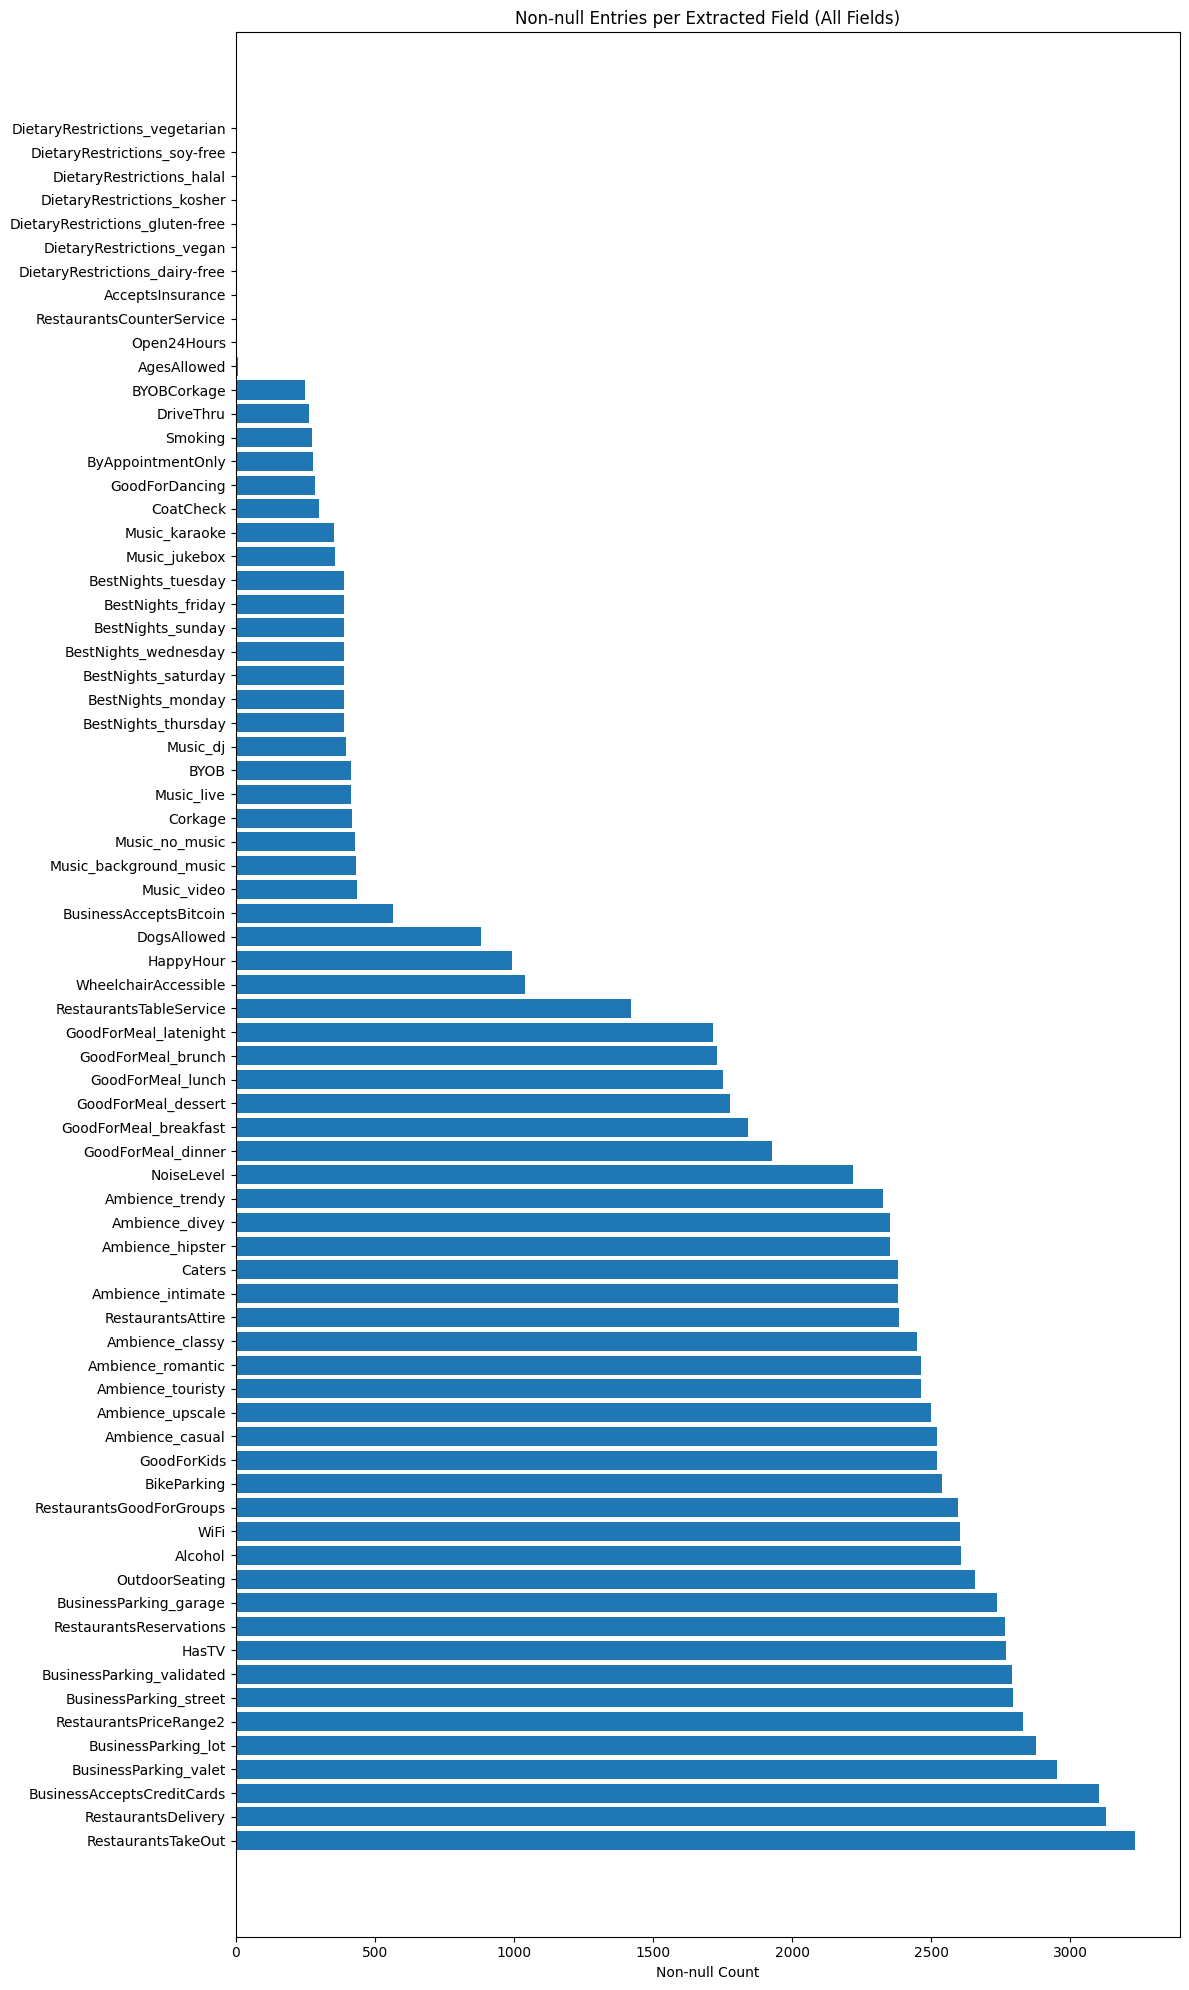

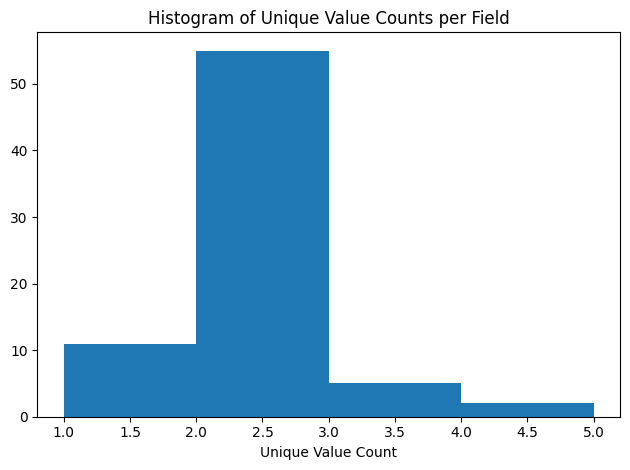

In [ ]:
# Final check to ensure no excessively high cardinality features

import matplotlib.pyplot as plt

# Compute non-null and unique value counts for each field
non_null_counts = df_parsed.notna().sum()
unique_counts = df_parsed.nunique(dropna=True)

# Sort for plotting
non_null_counts = non_null_counts.sort_values(ascending=False)

# Plot 1: Non-null entries per field
plt.figure(figsize=(12, 20))
plt.barh(non_null_counts.index, non_null_counts.values)
plt.xlabel('Non-null Count')
plt.title('Non-null Entries per Extracted Field (All Fields)')
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of unique value counts across fields
plt.figure()
plt.hist(unique_counts.values, bins=range(unique_counts.min(), unique_counts.max() + 2))
plt.xlabel('Unique Value Count')
plt.title('Histogram of Unique Value Counts per Field')
plt.tight_layout()

plt.show()

In [ ]:
# Merge the cleaned df_parsed back to the original df by index
df_merged = pd.concat([df.drop(columns=['attributes']), df_parsed], axis=1)

print("Merged cleaned attribute fields back to original DataFrame.")
print(f"New DataFrame shape: {df_merged.shape}")
df_merged.head()

# For RAG, null value is treated as lack of data - so we don't want to impute fields with blank/unknown values in. This part differs from ML approaches.

Merged cleaned attribute fields back to original DataFrame.
New DataFrame shape: (3525, 107)


business_id                name             address  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries         935 Race St   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar         205 Race St   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP       1224 South St   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall  901 N Delaware Ave   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa    3604 Chestnut St   

           city state  postal_code   latitude  longitude  stars  review_count  \
0  Philadelphia    PA        19107  39.955505 -75.155564    4.0            80   
1  Philadelphia    PA        19106  39.953949 -75.143226    4.0           245   
2  Philadelphia    PA        19147  39.943223 -75.162568    4.5           205   
3  Philadelphia    PA        19123  39.962582 -75.135657    3.5            65   
4  Philadelphia    PA        19104  39.954573 -75.194894    3.0            56   

   ...  AcceptsInsurance AgesAllowed DietaryRestrictions_dairy-free  \
0  ...              <NA>        <NA>                           <NA>   
1  ...              <NA>        <NA>                           <NA>   
2  ...              <NA>        <NA>                           <NA>   
3  ...              <NA>        <NA>                           <NA>   
4  ...              <NA>        <NA>                           <NA>   

  DietaryRestrictions_gluten-free DietaryRestrictions_vegan  \
0                            <NA>                      <NA>   
1                            <NA>                      <NA>   
2                            <NA>                      <NA>   
3                            <NA>                      <NA>   
4                            <NA>                      <NA>   

  DietaryRestrictions_kosher DietaryRestrictions_halal  \
0                       <NA>                      <NA>   
1                       <NA>                      <NA>   
2                       <NA>                      <NA>   
3                       <NA>                      <NA>   
4                       <NA>                      <NA>   

  DietaryRestrictions_soy-free DietaryRestrictions_vegetarian  \
0                         <NA>                           <NA>   
1                         <NA>                           <NA>   
2                         <NA>                           <NA>   
3                         <NA>                           <NA>   
4                         <NA>                           <NA>   

  RestaurantsCounterService  
0                      <NA>  
1                      <NA>  
2                      <NA>  
3                      <NA>  
4                      <NA>  

[5 rows x 107 columns]

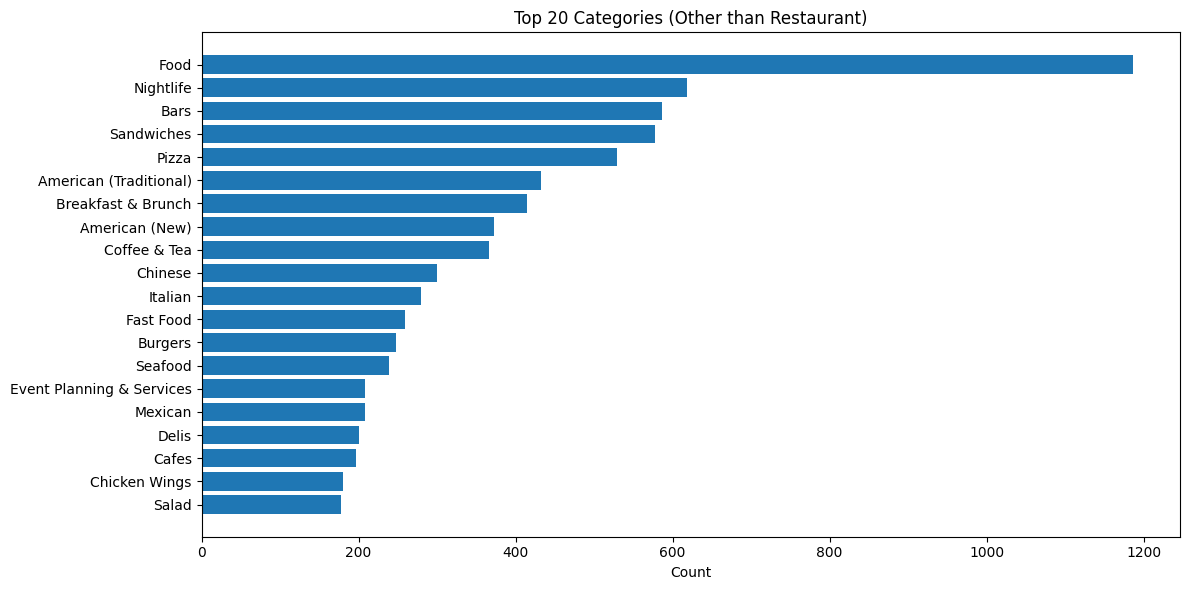

In [ ]:
# Flatten the list of all categories
from collections import Counter

all_categories = [cat for sublist in df['categories_list'] for cat in sublist]
category_counts = Counter(all_categories)

# Convert to DataFrame for easier viewing
df_category_counts = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])
df_category_counts = df_category_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Exclude the "Restaurants" category and show top 20 others
df_top_non_restaurant = df_category_counts[df_category_counts['Category'] != 'Restaurants'].head(20)

plt.figure(figsize=(12, 6))
plt.barh(df_top_non_restaurant['Category'][::-1], df_top_non_restaurant['Count'][::-1])
plt.xlabel('Count')
plt.title('Top 20 Categories (Other than Restaurant)')
plt.tight_layout()
plt.show()

Values for review_count:
count    3525.000000
mean      140.535319
std       291.768622
min         5.000000
25%        15.000000
50%        46.000000
75%       146.000000
max      5721.000000
Name: review_count, dtype: float64



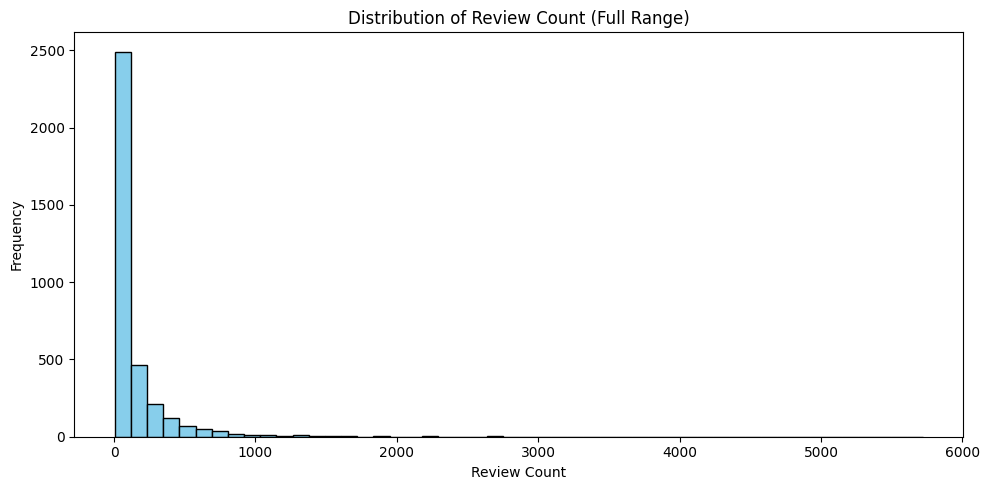

In [ ]:
# Describe number of reviews for Philly restaurants
print(f"Values for review_count:\n{df_merged['review_count'].describe()}\n")

# Simple EDA for Philly restaurants - distribution of review_count as graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['review_count'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Count (Full Range)')
plt.tight_layout()
plt.show()

Values for stars:
count    3525.000000
mean        3.585106
std         0.836943
min         1.000000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: stars, dtype: float64


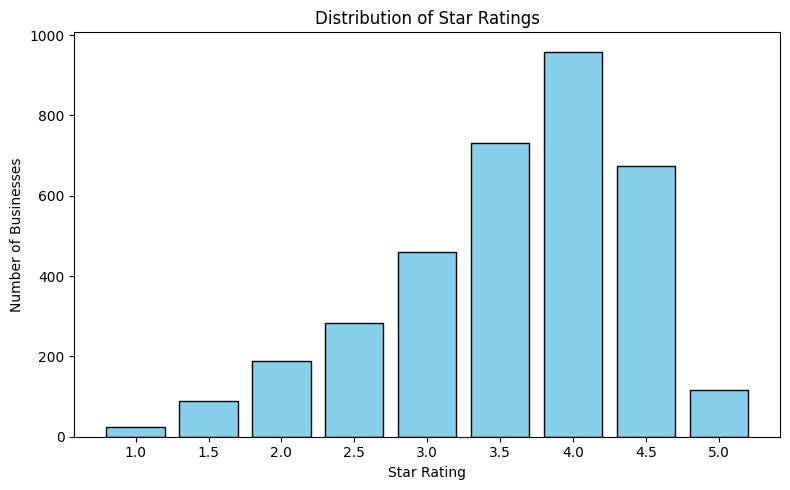

In [ ]:
# EDA for Star Ratings
print(f"Values for stars:\n{df_philly_restaurants['stars'].describe()}")

# Create histogram-like bar plot with adjacent bars for star ratings from 1.0 to 5.0
star_counts = df['stars'].value_counts().sort_index()

# Create full range of star values to ensure all are present
star_range = [round(x * 0.5, 1) for x in range(2, 11)]  # [1.0, 1.5, ..., 5.0]
star_counts = star_counts.reindex(star_range, fill_value=0)

# Plot as bar chart
plt.figure(figsize=(8, 5))
plt.bar(star_counts.index.astype(str), star_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Star Rating')
plt.ylabel('Number of Businesses')
plt.title('Distribution of Star Ratings')
plt.tight_layout()
plt.show()

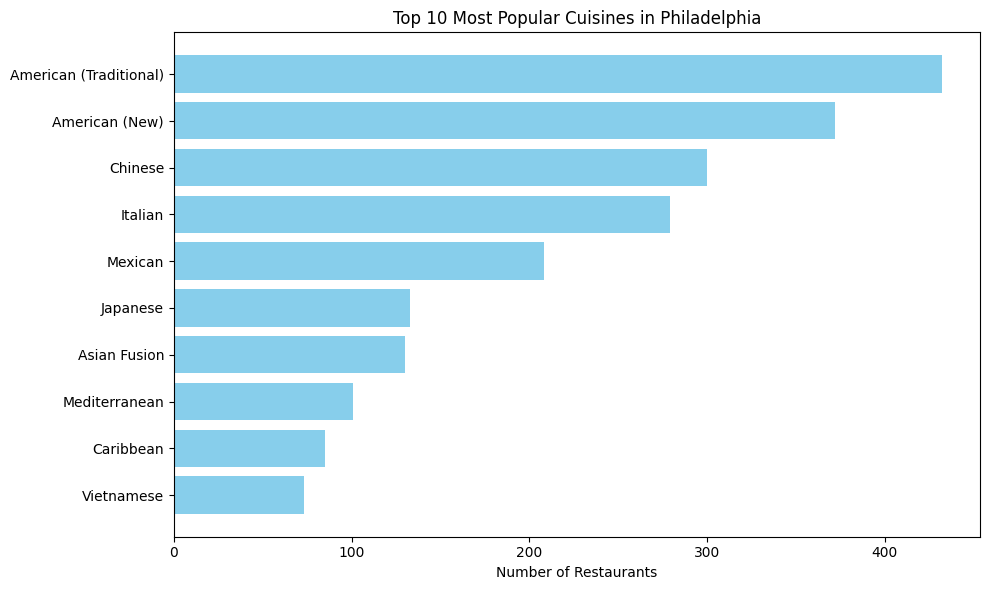

In [ ]:
# Explode the categories_list to get one category per row
df_exploded = df_merged.explode('categories_list')

# Group by category and calculate required stats
df_cuisine_stats = (
    df_exploded.groupby('categories_list')
    .agg(avg_stars=('stars', 'mean'), avg_reviews=('review_count', 'mean'), count=('business_id', 'count'))
    .reset_index()
)

# List of national/regional cuisine types extracted from Yelp documnetation https://docs.developer.yelp.com/docs/resources-categories
full_cuisine_list = [
    "Afghan", "African", "Senegalese", "South African", "American (New)", "American (Traditional)", "Andalusian",
    "Arabic", "Argentine", "Armenian", "Asian Fusion", "Asturian", "Australian", "Austrian", "Bangladeshi",
    "Basque", "Belgian", "Brazilian", "British", "Bulgarian", "Burmese", "Cambodian", "Canadian (New)",
    "Caribbean", "Catalan", "Chilean", "Chinese", "Cuban", "Czech", "Danish", "Dutch", "Ecuadorian", "Egyptian",
    "English", "Eritrean", "Ethiopian", "Filipino", "Finnish", "French", "Georgian", "German", "Greek", "Guamanian",
    "Haitian", "Hawaiian", "Himalayan/Nepalese", "Honduran", "Hong Kong Style Cafe", "Hungarian", "Icelandic", "Indian",
    "Indonesian", "International", "Irish", "Israeli", "Italian", "Jamaican", "Japanese", "Jewish", "Korean",
    "Laotian", "Latin American", "Lebanese", "Malaysian", "Mediterranean", "Mexican", "Middle Eastern", "Mongolian",
    "Moroccan", "Nepalese", "New Mexican Cuisine", "New Zealand", "Nicaraguan", "Pakistani", "Pan Asian",
    "Persian/Iranian", "Peruvian", "Polish", "Portuguese", "Puerto Rican", "Russian", "Scandinavian", "Scottish",
    "Singaporean", "Slovakian", "Somali", "South African", "Spanish", "Sri Lankan", "Swedish", "Swiss Food", "Syrian",
    "Taiwanese", "Tex-Mex", "Thai", "Turkish", "Ukrainian", "Uruguayan", "Uzbek", "Venezuelan", "Vietnamese", "Welsh",
    "Yugoslav"
]

# Filter and sort by number of restaurants
df_cuisine_filtered = (
    df_cuisine_stats[df_cuisine_stats['categories_list'].isin(full_cuisine_list)]
    .sort_values(by='count', ascending=False)
)

# Format results
df_cuisine_filtered_pretty = df_cuisine_filtered.rename(columns={
    'categories_list': 'Cuisine Type',
    'avg_stars': 'Average Star Rating',
    'avg_reviews': 'Average Review Count',
    'count': 'Number of Restaurants'
})[
    ['Cuisine Type', 'Number of Restaurants', 'Average Star Rating', 'Average Review Count']
].reset_index(drop=True)

# Round to 2 decimal places
df_cuisine_filtered_pretty['Average Star Rating'] = df_cuisine_filtered_pretty['Average Star Rating'].round(2)
df_cuisine_filtered_pretty['Average Review Count'] = df_cuisine_filtered_pretty['Average Review Count'].round(2)

# Plotting a horizontal bar chart for top 10 most popular cuisines by number of restaurants
top_cuisines = df_cuisine_filtered_pretty.head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_cuisines['Cuisine Type'][::-1], top_cuisines['Number of Restaurants'][::-1], color='skyblue')
plt.xlabel('Number of Restaurants')
plt.title('Top 10 Most Popular Cuisines in Philadelphia')
plt.tight_layout()
plt.show()

df_cuisine_filtered_pretty.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).format({
    "Average Star Rating": "{:.2f}",
    "Average Review Count": "{:.2f}"
})

In [ ]:
# Visualise the geographical spread of Philly restaurants on a map

import folium
from folium.plugins import MarkerCluster

# Load and filter dataset for Philadelphia bounding box
bounds = dict(lat_min=39.87, lat_max=40.14, lon_min=-75.28, lon_max=-74.95)
df_map = df_merged[
    df_merged['latitude'].between(bounds['lat_min'], bounds['lat_max']) &
    df_merged['longitude'].between(bounds['lon_min'], bounds['lon_max'])
]

# Create a Folium map centered on Philadelphia
map_center = [39.9526, -75.1652]  # City Hall coordinates
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap')

# Add clustered restaurant markers
marker_cluster = MarkerCluster(name='Restaurants').add_to(m)
for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(marker_cluster)

# Save the map to an HTML file
map_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_map.html'
m.save(map_path)

# Display the map inline (if supported) or provide link
m

In [ ]:
# Show restaurant distribution in heatmap form instead

import folium
from folium.plugins import HeatMap

# Create a Folium heatmap centered on Philadelphia
m = folium.Map(location=[39.9526, -75.1652], zoom_start=12)

# Add heatmap layer
heat_data = df_map[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# Save the map to an HTML file
map_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_heatmap.html'
m.save(map_path)

# Display the map inline
m

In [ ]:
# Save dataframe as Parquet file
# List datatypes will be flattened to string if saved as CSV
file_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.parquet'
df_merged.to_parquet(file_path, index=False)
print(f"Data Shape of Cleaned Dataframe: {df_merged.shape}")
print(f"Saved cleaned DataFrame to {file_path}")

Data Shape of Cleaned Dataframe: (3525, 107)
Saved cleaned DataFrame to /content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.parquet


In [ ]:
# Save as CSV file for export to view in LLM
file_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.csv'
df_merged.to_csv(file_path, index=False)

## 🧹 Review Pre-processing and Sampling Strategy

To ensure high-quality review content in our vector store, we apply a two-phase pipeline: **content quality filtering** and **hybrid sampling per business**.

---

### ✅ Phase 1: Content Filtering

#### 🔹 Step 1: Drop Null Reviews
Some reviews are missing text. These are dropped before applying any further filters.

#### 🔹 Step 2: High-Impact Review Filter
We define `is_high_impact_review()` to eliminate reviews that are too short, vague, or unhelpful.

---

### ✅ Phase 2: Hybrid Sampling Strategy (Per Business)

To balance relevance, recency, and diversity, we sample up to **10 reviews per business** using the following logic:

- **Top 3** most useful reviews (`useful` votes)
- **Top 2** most recent reviews (by `date`)
- **Up to 5** random reviews from the remaining pool
- **Businesses with fewer than 10 reviews** retain all available reviews

This simulates query-time filtering and ensures fair representation across businesses without overloading the vector store.

---

### ✅ Outcome

This dual-layer filtering and sampling pipeline:
- Removes low-impact reviews
- Keeps the most semantically rich, diverse, and timely content
- Improves retrieval and generation quality in the final RAG system

In [ ]:
# Mount Google Drive

import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

# Load business IDs

from tqdm import tqdm
import pandas as pd
import re

business_df = pd.read_parquet('/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.parquet')
business_ids = set(business_df['business_id'].unique())

# Define high-impact review filter
def is_high_impact_review(text, min_words=8, min_chars=50):
    if not isinstance(text, str):
        return False
    alnum = re.sub(r'[^A-Za-z0-9]', '', text)
    if len(alnum.strip()) < 3:
        return False
    if len(text.strip()) < min_chars:
        return False
    if len(text.strip().split()) < min_words:
        return False
    unique_words = set(text.lower().strip().split())
    if len(unique_words) == 1:
        return False
    return True

# Initialize empty DataFrame
df_filtered = pd.DataFrame()

# Chunked loading with progress bar
chunksize = 100000
review_path = '/content/gdrive/MyDrive/BT5153_2025/project/yelp_academic_dataset_review.json'

print("📥 Starting review chunk processing...")
for i, chunk in enumerate(tqdm(pd.read_json(review_path, lines=True, chunksize=chunksize),
                               desc="Processing review chunks")):
    # Step 1: Filter by business_id
    filtered_chunk = chunk[chunk['business_id'].isin(business_ids)]

    # Step 2: Drop null/blank text
    filtered_chunk = filtered_chunk[filtered_chunk['text'].notna()]
    filtered_chunk = filtered_chunk[filtered_chunk['text'].str.strip() != ""]

    # Step 3: High-impact filter
    filtered_chunk = filtered_chunk[filtered_chunk['text'].apply(is_high_impact_review)]

    # Accumulate
    df_filtered = pd.concat([df_filtered, filtered_chunk], ignore_index=True)

# Done
print(f"✅ Filtered Review DataFrame Shape: {df_filtered.shape}")
df_filtered.head()

Mounted at /content/gdrive
📥 Starting review chunk processing...


Processing review chunks: 70it [03:47,  3.26s/it]

✅ Filtered Review DataFrame Shape: (510217, 9)


review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  oyaMhzBSwfGgemSGuZCdwQ  Dd1jQj7S-BFGqRbApFzCFw  YtSqYv1Q_pOltsVPSx54SA   
2  Xs8Z8lmKkosqW5mw_sVAoA  IQsF3Rc6IgCzjVV9DE8KXg  eFvzHawVJofxSnD7TgbZtg   
3  JBWZmBy69VMggxj3eYn17Q  aFa96pz67TwOFu4Weq5Agg  kq5Ghhh14r-eCxlVmlyd8w   
4  YcLXh-3UC9y6YFAI9xxzPQ  G0DHgkSsDozqUPWtlxVEMw  oBhJuukGRqPVvYBfTkhuZA   

   stars  useful  funny  cool  \
0      5       1      0     1   
1      5       0      0     0   
2      5       0      0     0   
3      5       0      0     0   
4      4       0      0     0   

                                                text                date  
0  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
1  Tremendous service (Big shout out to Douglas) ... 2013-06-24 11:21:25  
2  My absolute favorite cafe in the city. Their b... 2014-11-12 15:30:27  
3  My boyfriend and I tried this deli for the fir... 2018-08-23 21:39:38  
4  The only reason I didn't give this restaurant ... 2015-03-05 03:37:54

In [ ]:
# Check for potential review duplicates across user_id, business_id, and text
duplicate_reviews = df_filtered[
    df_filtered.duplicated(subset=['user_id', 'business_id', 'text'], keep=False)
]

# Display summary
if duplicate_reviews.empty:
    print("✅ No exact duplicate reviews found.")
else:
    print(f"⚠️ Found {len(duplicate_reviews)} exact duplicate reviews across {duplicate_reviews['business_id'].nunique()} businesses.")
    display(duplicate_reviews.sort_values(by='business_id').head(10))  # Preview top 10

# Deduplication process
original_count = len(df_filtered)
df_filtered = df_filtered.sort_values(by='date', ascending=False)

# Keep most recent review per (user_id, business_id, text) combo
df_filtered = df_filtered.drop_duplicates(
    subset=['user_id', 'business_id', 'text'],
    keep='first'
).reset_index(drop=True)

# Summary
new_count = len(df_filtered)
removed_count = original_count - new_count
print(f"✅ Deduplicated reviews. Removed {removed_count} duplicate record(s). Final count: {new_count}")

⚠️ Found 1521 exact duplicate reviews across 524 businesses.


review_id                 user_id  \
100888  jfaq5JBtk3wJON0rgmhRbw  YMkdlZLq9mJU1OpYhVPj2w   
103437  rJVI8_aDQkcSYeXINqv1cw  gOYHwG5wfwVmQ6IT-Q3vVA   
101131  ZnriEfMDdf113o2DDhEbHg  YMkdlZLq9mJU1OpYhVPj2w   
93415   _JWJlOI6Xg3mxNP19vZPOw  gOYHwG5wfwVmQ6IT-Q3vVA   
57184   ZhxigVyLKwnPotGJ-kwBzw  OvLK0lhry6uoM4a--zRs8g   
77469   qmOFcojVsnGTxCnMsGT48g  OvLK0lhry6uoM4a--zRs8g   
484183  WIzH4ECZpK0-Z-PUdxcOzA  jz3FoVc4oaROw6LKJXlNmA   
500606  MV75tp4XA1YsQKCV_9PspA  aRZkstJ6Z8j5NeV-K37WRQ   
493554  RMN4Vh6B7RVi6_h1JZ6MeQ  VjHe0GwJW2i1F7hiSwQ--w   
480435  S_3xYTFuCHS9nxKOF6YwUw  jz3FoVc4oaROw6LKJXlNmA   

                   business_id  stars  useful  funny  cool  \
100888  -0TffRSXXIlBYVbb5AwfTg      4       0      1     0   
103437  -0TffRSXXIlBYVbb5AwfTg      4       0      0     0   
101131  -0TffRSXXIlBYVbb5AwfTg      3       0      0     1   
93415   -0TffRSXXIlBYVbb5AwfTg      5       0      0     0   
57184   -0TffRSXXIlBYVbb5AwfTg      5       0      0     0   
77469   -0TffRSXXIlBYVbb5AwfTg      5       0      0     0   
484183  -1B9pP_CrRBJYPICE5WbRA      5       0      0     0   
500606  -1B9pP_CrRBJYPICE5WbRA      4       0      0     0   
493554  -1B9pP_CrRBJYPICE5WbRA      4       1      0     0   
480435  -1B9pP_CrRBJYPICE5WbRA      5       0      0     0   

                                                     text                date  
100888  Came here for a friend's 21st birthday party! ... 2018-06-23 06:56:18  
103437  This restaurant is a must if you are looking f... 2021-01-23 20:13:58  
101131  Came here for a friend's 21st birthday party! ... 2019-11-09 15:07:37  
93415   This restaurant is a must if you are looking f... 2020-08-15 21:03:16  
57184   Great find in philly! Yelpers thanks for the t... 2017-05-01 02:47:03  
77469   Great find in philly! Yelpers thanks for the t... 2017-04-30 02:03:36  
484183  Went to dinner at Spice with friends last nigh... 2016-06-19 14:53:42  
500606  The food here was delicious and the service wa... 2017-07-04 17:48:18  
493554  The chicken dry pot is amazing, but very spicy... 2017-07-16 19:57:34  
480435  Went to dinner at Spice with friends last nigh... 2016-06-22 12:14:49

✅ Deduplicated reviews. Removed 772 duplicate record(s). Final count: 509445


In [ ]:
import random
from collections import defaultdict
from tqdm import tqdm

# Define chunk size
chunk_size = 1000  # Adjust if needed based on Colab RAM

# Get unique business_ids
unique_biz_ids = df_filtered['business_id'].unique()
total_chunks = (len(unique_biz_ids) + chunk_size - 1) // chunk_size

# Initialize list to collect sampled reviews
sampled_records = []

# Process each chunk of business_ids
for i in tqdm(range(total_chunks), desc="Sampling reviews by business"):
    chunk_biz_ids = unique_biz_ids[i * chunk_size : (i + 1) * chunk_size]
    chunk_df = df_filtered[df_filtered['business_id'].isin(chunk_biz_ids)]

    # Group by business_id
    grouped_reviews = defaultdict(list)
    for _, row in chunk_df.iterrows():
        grouped_reviews[row['business_id']].append(row)

    for biz_id, reviews in grouped_reviews.items():
        reviews_list = list(reviews)

        if len(reviews_list) <= 10:
            selected = reviews_list
        else:
            # 1. Top 3 most useful
            top_useful = sorted(reviews_list, key=lambda x: x['useful'], reverse=True)[:3]
            top_useful_ids = {r['review_id'] for r in top_useful}

            # 2. Top 2 most recent not already used
            top_recent = [
                r for r in sorted(reviews_list, key=lambda x: x['date'], reverse=True)
                if r['review_id'] not in top_useful_ids
            ][:2]
            top_recent_ids = {r['review_id'] for r in top_recent}

            # 3. Random up to 5 from remaining
            excluded_ids = top_useful_ids.union(top_recent_ids)
            remaining = [r for r in reviews_list if r['review_id'] not in excluded_ids]
            random_sample = random.sample(remaining, min(5, len(remaining)))

            # Combine all selected reviews
            selected = top_useful + top_recent + random_sample

        sampled_records.extend(selected)

# Convert to DataFrame
df_sampled_reviews = pd.DataFrame(sampled_records)
print(f"✅ Final Sampled Review DataFrame Shape: {df_sampled_reviews.shape}")
df_sampled_reviews.head()

Sampling reviews by business: 100%|██████████| 4/4 [00:51<00:00, 12.77s/it]


✅ Final Sampled Review DataFrame Shape: (33737, 9)


review_id                 user_id  \
375987  S617GBeKAGJv51_w-j3Dzw  ZX9aq6fKbGaF6hXSnkDiAA   
275200  TxrfMon-ayPSEaHHYAw4ig  7lNgj9Wv999fSPV_mSoWyQ   
460511  NtufwXoLpiNFbC9_JlJeYg  74MEs3l1jQTaBPpOgv8t7w   
0       ynuz9C33_PqA9rSkvM8L8g  hDMM20MqoKVi4VMKamyfqQ   
9413    pm_VBsm2FHPu74dkuxZSow  SLNBXLNuVPObQp1GjOYIEg   

                   business_id  stars  useful  funny  cool  \
375987  nIlmZLuMs0JuBRvAHSIf8Q      5      20     17    15   
275200  nIlmZLuMs0JuBRvAHSIf8Q      1      15      0     0   
460511  nIlmZLuMs0JuBRvAHSIf8Q      2      13      4     0   
0       nIlmZLuMs0JuBRvAHSIf8Q      5       0      0     0   
9413    nIlmZLuMs0JuBRvAHSIf8Q      5       0      0     0   

                                                     text                date  
375987  Limoncello cupcake runaway with me then get in... 2014-04-12 22:59:09  
275200  I had an awful experience with them. BRIDES BE... 2016-06-06 18:16:50  
460511  I came here to pick up a birthday cake for a g... 2011-06-18 06:19:51  
0       Delivered a beautiful cake for my daughter's B... 2022-01-19 19:46:34  
9413    Love their cupcakes and ice cream!!!  Customer... 2021-10-16 12:35:55

In [ ]:
review_counts = df_sampled_reviews.groupby('business_id')['review_id'].count().reset_index()
review_counts.columns = ['business_id', 'sampled_review_count']

print(review_counts['sampled_review_count'].value_counts().sort_index())

# Check for duplicate review_ids
duplicate_reviews = df_sampled_reviews[df_sampled_reviews.duplicated(subset='review_id', keep=False)]

if duplicate_reviews.empty:
    print("✅ No duplicate reviews found in df_sampled_reviewas.")
else:
    print(f"⚠️ {len(duplicate_reviews)} duplicate reviews found:")
    display(duplicate_reviews)

sampled_review_count
5      107
6      116
7       84
8       85
9       80
10    3053
Name: count, dtype: int64
✅ No duplicate reviews found in df_sampled_reviewas.
Sampled Review DataFrame Shape: (33749, 9)


review_id                 user_id             business_id  \
39534  wNu9HLw8ZSqmef4XlmrdNg  3QnoTcrxuafMCoTzW_AH7A  kxX2SOes4o-D3ZQBkiMRfA   
35214  kUIo6GuLZGeWhUs1juO3tg  -G7Zkl1wIWBBmD0KRy_sCw  kxX2SOes4o-D3ZQBkiMRfA   
45402  -5c1uu_wgjciT99GR-XiyQ  47CQPJ65mfkgcE0aN04eDg  kxX2SOes4o-D3ZQBkiMRfA   
45947  hO-lMVPI7vH5gt3P5FnwDw  bgdFMsxMlOrUIvjRnLJPlw  kxX2SOes4o-D3ZQBkiMRfA   
27588  HLTHtpkwYhGJk5JxsL0Hrg  BLFynQAIQ5gJr_OFvoth4A  kxX2SOes4o-D3ZQBkiMRfA   

       stars  useful  funny  cool  \
39534      5      24     13    23   
35214      5      23     11    18   
45402      5       0      0     0   
45947      5       0      0     0   
27588      5       0      0     0   

                                                    text                date  
39534  Awesome find!! I can safely say after my first... 2017-03-24 10:55:39  
35214  Zaika on Grant Avenue in Northeast Philly, is ... 2017-04-28 13:32:57  
45402  I have been going to Zaika for more than 10 ye... 2021-12-04 19:09:37  
45947  Pick up is currently through the storefront. T... 2021-08-30 14:21:36  
27588  This resturant surpassed my expectations. The ... 2018-11-21 21:22:24

📏 Review Text Length Stats:
 count    33737.000000
mean       608.607612
std        566.786114
min         50.000000
25%        237.000000
50%        433.000000
75%        782.000000
max       5000.000000
Name: text_length, dtype: float64

📝 Review Word Count Stats:
 count    33737.000000
mean       111.870735
std        103.955687
min          8.000000
25%         43.000000
50%         80.000000
75%        144.000000
max        980.000000
Name: text_wordcount, dtype: float64


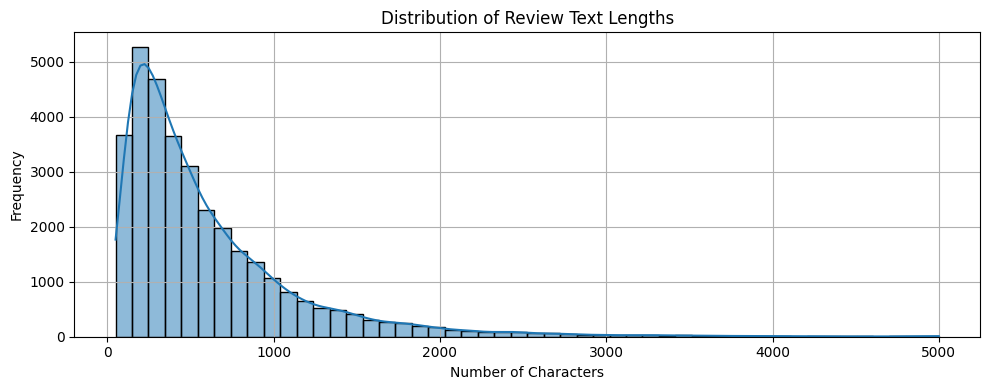


🔍 Short Review Examples (<40 chars):


Empty DataFrame
Columns: [text, text_length]
Index: []


🔍 Long Review Examples (>1000 chars):


text  text_length
186262  "Of all the gin joints in all the towns in all...         5000
276001  We go to this location almost daily because it...         4999
50704   In addition to the lockdown/SIP and eschewing ...         4999
216811  You've probably heard about the newest gal in ...         4999
364807  A while ago I reviewed this pizza place on Yel...         4999

In [ ]:
# --- Analyze Review Quality (for vector store readiness) ---

# Compute lengths
df_sampled_reviews['text_length'] = df_sampled_reviews['text'].str.len()
df_sampled_reviews['text_wordcount'] = df_sampled_reviews['text'].str.split().apply(len)

# Stats
text_length_stats = df_sampled_reviews['text_length'].describe()
wordcount_stats = df_sampled_reviews['text_wordcount'].describe()

# Print summary
print("📏 Review Text Length Stats:\n", text_length_stats)
print("\n📝 Review Word Count Stats:\n", wordcount_stats)

# Identify edge cases
short_reviews = df_sampled_reviews[df_sampled_reviews['text_length'] < 40].sort_values('text_length')
long_reviews = df_sampled_reviews[df_sampled_reviews['text_length'] > 1000].sort_values('text_length', ascending=False).head(5)

# Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df_sampled_reviews['text_length'], bins=50, kde=True)
plt.title("Distribution of Review Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show edge cases
from IPython.display import display

print("\n🔍 Short Review Examples (<40 chars):")
display(short_reviews[['text', 'text_length']])

print("\n🔍 Long Review Examples (>1000 chars):")
display(long_reviews[['text', 'text_length']])

In [ ]:
# Save reviews as CSV file
file_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_reviews_sampled.csv'
df_sampled_reviews.to_csv(file_path, index=False)
print(f"Saved sampled reviews to {file_path}")

Saved sampled reviews to /content/gdrive/MyDrive/BT5153_2025/project/philly_reviews_sampled.csv


## 🧹 Tip Data Pre-processing Strategy

As part of our data preparation pipeline, we perform both **business relevance filtering** and **content quality filtering** for user-submitted tips. This ensures that only high-quality, semantically rich tips are considered for downstream chunking and embedding.

### ✅ Step 1: Business Matching
We restrict tips to only those that belong to restaurants in our filtered Philadelphia dataset:
- Filter by `business_id` using the cleaned business metadata (`philly_restaurants_cleaned.parquet`)

### ✅ Step 2: High-Impact Tip Filtering
To avoid low-value tips (e.g., "Yum!", "Nice", emoji-only), we define a custom filter `is_high_impact_text()` with the following criteria:
- Minimum 4 words
- Minimum 20 characters
- Must include alphanumeric characters
- Rejects single repeated words (e.g., "nice nice nice")

This filter is applied **immediately during data loading**, before tip sampling or selection.

### ✅ Result
Only tips that are both:
- Linked to valid restaurants, and
- Meaningful in content

...will be passed to the next stage of processing (e.g., compliment-based ranking, chunk creation).


## ✅ Tip Sampling Strategy (Prototype Phase)

To limit vector store size and simulate relevance filtering in a production system, we apply a hybrid tip sampling strategy **per business**:

- **Top 3 tips by `compliment_count`**
- **1 most recent tip**
- **1 random tip (if available)**
- **Maximum of 5 tips per business**

This ensures:
- High community endorsement (top compliments)
- Freshness (recency-aware retrieval)
- Diversity (randomness)
- Efficiency for vector storage and query performance

All tips are also filtered upfront using `is_high_impact_text()` to remove short, low-value, or emoji-only entries.

In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

import pandas as pd
import re

# Load list of business_ids from your cleaned restaurant CSV
business_df = pd.read_parquet('/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.parquet')
business_ids = set(business_df['business_id'].unique())

# High-impact text filter function
def is_high_impact_text(text, min_words=4, min_chars=20):
    if not isinstance(text, str):
        return False
    alnum_content = re.sub(r'[^A-Za-z0-9]', '', text)
    if len(alnum_content.strip()) < 3:
        return False
    if len(text.strip()) < min_chars:
        return False
    if len(text.strip().split()) < min_words:
        return False
    unique_words = set(text.lower().strip().split())
    if len(unique_words) == 1:
        return False
    return True

# Initialize an empty DataFrame
df_tip_filtered = pd.DataFrame()

# Read in chunks and filter by business_id and content
chunksize = 100000
tip_path = '/content/gdrive/MyDrive/BT5153_2025/project/yelp_academic_dataset_tip.json'

for chunk in pd.read_json(tip_path, lines=True, chunksize=chunksize):
    filtered_chunk = chunk[
        chunk['business_id'].isin(business_ids) &
        chunk['text'].apply(is_high_impact_text)
    ]
    df_tip_filtered = pd.concat([df_tip_filtered, filtered_chunk], ignore_index=True)

# Show results
print(f"Filtered Tip DataFrame Shape: {df_tip_filtered.shape}")
df_tip_filtered.head()

Mounted at /content/gdrive
Filtered Tip DataFrame Shape: (51682, 5)


user_id             business_id  \
0  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
1  YnlCpuaBa3qWBp4te8pGmA  XIKYdKWq72zUYsq8NBxcCQ   
2  Rr4cLb6Go91FT134o6RsKg  eMiN8nm70jjKg8izikVWDA   
3  xU4GbT4VKMpyOxNJAuP3hQ  s2JiYzE7i68cXIV6YEcVTw   
4  gHUJQESZY_UESjTxh0HpOw  -CRjqZ4GxZ6lIa_qMj7-yw   

                                     text                date  \
0  It's open even when you think it isn't 2013-08-18 00:56:08   
1     The honey glazed salmon is amazing! 2018-01-14 15:00:01   
2                   Mmm Yummy Crab Fries! 2011-10-16 23:43:10   
3           Fish and chips are very good. 2011-08-09 23:28:29   
4       Solid late night Chinese take out 2017-03-18 03:43:34   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [ ]:
duplicate_tips = df_tip_filtered[
    df_tip_filtered.duplicated(subset=['user_id', 'business_id', 'text'], keep=False)
]

# Show results
if duplicate_tips.empty:
    print("✅ No exact duplicate tips found.")
else:
    print(f"⚠️ Found {len(duplicate_tips)} exact duplicate tips across {duplicate_tips['business_id'].nunique()} businesses.")
    display(duplicate_tips.sort_values(by='business_id').head(10))  # Preview top 10

⚠️ Found 153 exact duplicate tips across 66 businesses.


user_id             business_id  \
7175   Y29ug4ybsxWaTtuF48jsEA  -1B9pP_CrRBJYPICE5WbRA   
8195   Y29ug4ybsxWaTtuF48jsEA  -1B9pP_CrRBJYPICE5WbRA   
34095  oCU5WijvcyVbEODneHuLyA  0-7N3z_cb3Z1xMGDrbez6w   
32961  oCU5WijvcyVbEODneHuLyA  0-7N3z_cb3Z1xMGDrbez6w   
13012  fCvMnJU1Z-XhAjKg99wK3Q  0-JRAY0LpBazDuA9761U5w   
23621  fCvMnJU1Z-XhAjKg99wK3Q  0-JRAY0LpBazDuA9761U5w   
39220  ZFdB5gus0Pw3l7Whdfln4Q  03jQGGJ2ch0uHTtW-UUUqg   
38453  ZFdB5gus0Pw3l7Whdfln4Q  03jQGGJ2ch0uHTtW-UUUqg   
37417  ZFdB5gus0Pw3l7Whdfln4Q  03jQGGJ2ch0uHTtW-UUUqg   
39792  ZFdB5gus0Pw3l7Whdfln4Q  03jQGGJ2ch0uHTtW-UUUqg   

                                                    text                date  \
7175   10% yelp check in offer. Indian pancake comes ... 2014-01-12 01:09:31   
8195   10% yelp check in offer. Indian pancake comes ... 2014-01-12 01:11:26   
34095  Really wonderful food on my third visit. Still... 2017-10-21 02:06:33   
32961  Really wonderful food on my third visit. Still... 2017-10-21 02:06:33   
13012  New Years Day, "Hangover Cure pizza. Available... 2016-12-23 15:17:58   
23621  New Years Day, "Hangover Cure pizza. Available... 2016-12-23 15:16:44   
39220  HORRIBLE, HORRIBLE service from Michelle! If y... 2016-10-22 01:59:54   
38453  HORRIBLE, HORRIBLE service from Michelle! If y... 2016-10-22 02:03:39   
37417  HORRIBLE, HORRIBLE service from Michelle! If y... 2016-10-22 02:32:38   
39792  HORRIBLE, HORRIBLE service from Michelle! If y... 2016-10-23 03:58:40   

       compliment_count  
7175                  0  
8195                  0  
34095                 0  
32961                 0  
13012                 0  
23621                 0  
39220                 0  
38453                 0  
37417                 0  
39792                 0

In [ ]:
# Store original count
original_count = len(df_tip_filtered)

# Sort by date so newest comes first
df_tip_filtered = df_tip_filtered.sort_values(by='date', ascending=False)

# Deduplicate — keep most recent tip per user/business/text combo
df_tip_filtered = df_tip_filtered.drop_duplicates(
    subset=['user_id', 'business_id', 'text'],
    keep='first'
).reset_index(drop=True)

# Store new count
new_count = len(df_tip_filtered)

# Calculate how many were removed
removed_count = original_count - new_count
print(f"✅ Deduplicated tips. Removed {removed_count} duplicate record(s). Final count: {new_count}")


✅ Deduplicated tips. Removed 80 duplicate record(s). Final count: 51602


In [ ]:
# Count how many rows are missing 'text'
missing_text_count = df_tip_filtered['text'].isna().sum()
print(f"🗑️ Tips with no text dropped: {missing_text_count}")

# Drop tips with no text
df_tip_filtered.dropna(subset=['text'], inplace=True)

# Show results
print(f"✅ Filtered Tip DataFrame Shape: {df_tip_filtered.shape}")
df_tip_filtered.head()

🗑️ Tips with no text dropped: 0
✅ Filtered Tip DataFrame Shape: (51602, 5)


user_id             business_id  \
0  T4Uk_zyBFvIUsBVninUqRg  wuH4TPUo8oJo4E59xZKsNg   
1  1hpjYVYWT1e5lb2r9Utbkw  YaLKDgS_zIYIm6jkXWCxgA   
2  Yj2Ae5dTR-9Sjnm4XY3kOA  b9sLRv_j1eijFIEso8-RQg   
3  BmVwbsL8l0imz4slonyMaA  oDl1Zh9L7rM3o5RNur0kZA   
4  5TMVGp0rNE-REubFDDuIpg  3j08Cje2YWUuRxV60BiVFw   

                                                text                date  \
0  I cant lie, i love this pizza especially after... 2022-01-19 05:23:53   
1  Great Pizza . The delivery to awhile but the w... 2022-01-18 23:40:23   
2  Love their pretzels!!! They have the best pret... 2022-01-18 19:16:36   
3  Their Bahn Mi's are so good, especially for th... 2022-01-18 18:48:01   
4                       Great food with nice morning 2022-01-18 18:31:37   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [ ]:
import random
from tqdm import tqdm

# Prepare unique business_ids and batching
business_ids = df_tip_filtered['business_id'].drop_duplicates().values
chunk_size = 1000
total_chunks = (len(business_ids) + chunk_size - 1) // chunk_size

# Sort globally for deterministic sampling
df_tip_filtered = df_tip_filtered.sort_values(by=['compliment_count', 'date'], ascending=[False, False])

sampled_tip_records = []

for i in tqdm(range(total_chunks), desc="Sampling tips by business"):
    biz_chunk = business_ids[i * chunk_size : (i + 1) * chunk_size]
    chunk_df = df_tip_filtered[df_tip_filtered['business_id'].isin(biz_chunk)]

    for biz_id, group in chunk_df.groupby('business_id'):
        tips = group.copy()

        if len(tips) <= 5:
            selected = tips
        else:
            used_indices = []

            # 1. Top 3 by compliment_count
            top_complimented = tips.sort_values(by='compliment_count', ascending=False).head(3)
            used_indices = top_complimented.index.tolist()

            # 2. Most recent tip not already used
            remaining = tips.drop(index=used_indices)
            top_recent = remaining.sort_values(by='date', ascending=False).head(1)
            used_indices += top_recent.index.tolist()

            # 3. Random tip from remaining
            remaining = tips.drop(index=used_indices)
            random_tip = remaining.sample(1) if not remaining.empty else pd.DataFrame()

            # Combine all selected
            selected = pd.concat([top_complimented, top_recent, random_tip])

        sampled_tip_records.extend(selected.to_dict(orient='records'))

# Final sampled tip-level DataFrame
df_sampled_tips = pd.DataFrame(sampled_tip_records)
print("✅ Tip sampling complete.")
print(f"Shape: {df_sampled_tips.shape}")
df_sampled_tips.head()

Sampling tips by business: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


✅ Tip sampling complete.
Shape: (11915, 5)


user_id             business_id  \
0  N9hqTPQu2bmI8c2Pj8F1ww  -0TffRSXXIlBYVbb5AwfTg   
1  3pcLlMGnwIterSzPdo5EdA  -0TffRSXXIlBYVbb5AwfTg   
2  TSDPfGvLh7pMcKWzRh9BQw  -0TffRSXXIlBYVbb5AwfTg   
3  wsowmVdJ1FK7ep6romvDFA  -0TffRSXXIlBYVbb5AwfTg   
4  JPhD3lECmXelDiaMDtzH1w  -0TffRSXXIlBYVbb5AwfTg   

                                                text                date  \
0  If you signed up to get their emails, they'll ... 2015-02-25 00:12:12   
1                 Awesome Sunday Brunch with mimosa. 2021-11-25 01:30:59   
2         Deliciously spicy and flavor packed food!! 2021-04-06 19:03:51   
3  The place has a nice setting on the street. Fo... 2020-10-02 22:41:52   
4           Try the Malai Kofta Bukhara, it's yummy! 2017-03-29 01:03:50   

   compliment_count  
0                 2  
1                 0  
2                 0  
3                 0  
4                 0

In [ ]:
# Count number of sampled tips per business
tip_counts = df_sampled_tips.groupby('business_id')['text'].count().reset_index()
tip_counts.columns = ['business_id', 'sampled_tip_count']

# Show distribution of how many tips were sampled per business
print("📊 Tip count per business:")
print(tip_counts['sampled_tip_count'].value_counts().sort_index())

# Check for duplicate tips — using (user_id, business_id, text)
duplicate_tips = df_sampled_tips[
    df_sampled_tips.duplicated(subset=['user_id', 'business_id', 'text'], keep=False)
]

if duplicate_tips.empty:
    print("✅ No duplicate tips found in df_sampled_tips.")
else:
    print(f"⚠️ Found {len(duplicate_tips)} duplicate tips:")
    display(duplicate_tips)

📊 Tip count per business:
sampled_tip_count
1     452
2     322
3     291
4     199
5    1830
Name: count, dtype: int64
✅ No duplicate tips found in df_sampled_tips.


📏 Tip Text Length Stats:
 count    11915.000000
mean        68.365254
std         55.107507
min         20.000000
25%         38.000000
50%         57.000000
75%         77.000000
max        500.000000
Name: text_length, dtype: float64

📝 Tip Word Count Stats:
 count    11915.000000
mean        12.187495
std          9.985818
min          4.000000
25%          6.000000
50%         10.000000
75%         14.000000
max        100.000000
Name: text_wordcount, dtype: float64


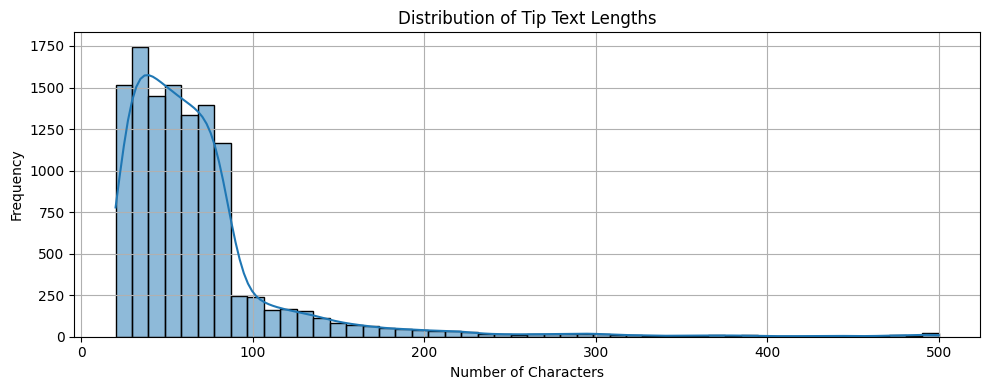


🔍 Short Tip Examples (<20 chars):


Empty DataFrame
Columns: [text, text_length]
Index: []


🔍 Long Tip Examples (>300 chars):


text  text_length
4143  I have been a customer of Anthony's for many y...          500
8793  February 22, 7pm. Goodfellas with a special me...          500
2233  Order the pastel, coxinha, and/or pichana (top...          499
6455  When I went home to philly I stopped by the fo...          498
1747  Flies everywhere. One of the wait staff even p...          498

In [ ]:
# --- Analyze Tip Quality (for vector store readiness) ---

# Compute lengths
df_sampled_tips['text_length'] = df_sampled_tips['text'].str.len()
df_sampled_tips['text_wordcount'] = df_sampled_tips['text'].str.split().apply(len)

# Stats
text_length_stats = df_sampled_tips['text_length'].describe()
wordcount_stats = df_sampled_tips['text_wordcount'].describe()

# Print summary
print("📏 Tip Text Length Stats:\n", text_length_stats)
print("\n📝 Tip Word Count Stats:\n", wordcount_stats)

# Identify edge cases
short_tips = df_sampled_tips[df_sampled_tips['text_length'] < 20].sort_values('text_length')
long_tips = df_sampled_tips[df_sampled_tips['text_length'] > 300].sort_values('text_length', ascending=False).head(5)

# Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df_sampled_tips['text_length'], bins=50, kde=True)
plt.title("Distribution of Tip Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show edge cases
from IPython.display import display

print("\n🔍 Short Tip Examples (<20 chars):")
display(short_tips[['text', 'text_length']])

print("\n🔍 Long Tip Examples (>300 chars):")
display(long_tips[['text', 'text_length']])


In [ ]:
# Save tips as CSV file
file_path = '/content/gdrive/MyDrive/BT5153_2025/project/philly_tips_sampled.csv'
df_sampled_tips.to_csv(file_path, index=False)
print(f"Saved sampled reviews to {file_path}")

Saved sampled reviews to /content/gdrive/MyDrive/BT5153_2025/project/philly_tips_sampled.csv


## Chunk Generation (Profiles, Reviews, Tips)

### ✅ Profile Chunk Generation Summary (`business_df` → `df_profile_chunks`)

We processed the cleaned Yelp business data for Philadelphia to generate semantically rich profile chunks, formatted for RAG-based retrieval.

---

### 📥 Starting Point
- **Input**: `business_df` from `philly_restaurants_cleaned.csv`
- **Each row** represents one unique restaurant business (based on `business_id`)

---

### 🏗️ Chunk Construction
Each profile chunk is a single `rag_text_chunk`, composed in natural language using available metadata:

**Included Elements:**
- 🏷️ Business name, address, city  
- ⭐ Star rating and review count  
- 🧾 Price range (stored as integer 1–4, where higher = more expensive)
- 🍽️ Filtered categories (removing generic "Restaurants", "Food")  
- 🧩 Features:  
  - Outdoor seating, delivery, takeout  
  - Wi-Fi, wheelchair access  
  - Alcohol availability, group/kid-friendly  
  - Reservations, happy hour (excluded for fast food / retail)  
- 🌱 Dietary options: vegan, halal, gluten-free  
- ⏰ Derived hours summary:  
  - “Open late on most days”  
  - “Open 24 hours on several days”  
- 🎵 Music-related attributes: live, DJ, karaoke  
- 🎭 Ambience features: romantic, trendy, divey, etc.  
- 👗 Dress code (included only if not "casual")  

---

### 🧹 Cleaning and Safeguards
- Null-safe field access with `.get()` lookups  
- Categories parsed into `categories_list` and cleaned for deduplication  
- Conditional inclusion of optional fields (attire, music, etc.)  
- Filtered noisy/irrelevant features for retail chains and non-dining venues  

---

### 📏 Quality Checks
We validated text quality across all profile chunks:
- Computed character and word count  
- Estimated token length (~word_count / 0.75 for MiniLM/BGE)  
- Verified all chunks fall below 768-token safety limit  

Histograms were plotted to visually inspect distribution and catch outliers.

---

### 🧠 Metadata and Output Schema
Each chunk includes:
- `business_id` (internal identifier for retrieval grouping)  
- `business_name` (used for display only)  
- `chunk_type = "profile"`  
- `rag_text_chunk` (LLM-friendly profile description)  
- `stars`, `categories_list`, `price_range`, `latitude`, `longitude`

---

### 📦 Final Output
- DataFrame: `df_profile_chunks`  
- Ready for vector embedding  
- Fully aligned with unified RAG chunking strategy across all content types (review, tip, profile)


In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

import pandas as pd
# Load the business dataset
business_df = pd.read_parquet('/content/gdrive/MyDrive/BT5153_2025/project/philly_restaurants_cleaned.parquet')
print(f"✅ Business DataFrame Shape: {business_df.shape}")

Mounted at /content/gdrive
✅ Business DataFrame Shape: (3525, 107)


In [ ]:
import ast

# --- Setup mappings and helpers ---
price_map = {1: "$", 2: "$$", 3: "$$$", 4: "$$$$"}

# Define lists of relevant columns
dietary_cols = [col for col in business_df.columns if col.startswith("DietaryRestrictions_")]
meal_cols = [col for col in business_df.columns if col.startswith("GoodForMeal_")]
ambience_cols = [col for col in business_df.columns if col.startswith("Ambience_")]
music_cols = ["Music_dj", "Music_live", "Music_karaoke"]

# Helper: Clean categories
def clean_categories(raw):
    if isinstance(raw, str):
        try:
            cat_list = ast.literal_eval(raw)
            if isinstance(cat_list, list):
                return list(dict.fromkeys([c for c in cat_list if c.lower() not in ["restaurants", "food"]]))
        except:
            return []
    elif isinstance(raw, list):
        return list(dict.fromkeys([c for c in raw if c.lower() not in ["restaurants", "food"]]))
    return []

# Helper: Flag retail/fast-food types
def is_retail_type(cat_list):
    keywords = ["convenience", "smoothie", "ice cream", "coffee", "gas station", "bakery", "food truck", "fast food"]
    return any(any(k in c.lower() for k in keywords) for c in cat_list or [])

# Helper: Derive open hours summary
def corrected_opening_summary(row):
    hours_cols = [col for col in row.index if col.startswith("hours.")]
    late_days, full_day_open = 0, 0
    for col in hours_cols:
        hours_str = row[col]
        if isinstance(hours_str, str):
            try:
                intervals = hours_str.split(", ")
                for interval in intervals:
                    open_time, close_time = interval.split("-")
                    if close_time in ["23:30", "23:45", "24:00", "00:00"]:
                        late_days += 1
                    if open_time == "00:00" and close_time == "23:59":
                        full_day_open += 1
            except:
                continue
    remarks = []
    if late_days >= 3: remarks.append("Open late on most days")
    if full_day_open >= 3: remarks.append("Open 24 hours on several days")
    return ". ".join(remarks) + "." if remarks else ""

# --- Main chunk generator ---
def generate_rag_text(row):
    parts = []

    name = row.get("name", "This restaurant")
    addr, city = row.get("address", ""), row.get("city", "")
    stars, reviews = row.get("stars", "N/A"), row.get("review_count", 0)
    parts.append(f"{name} is a restaurant located at {addr}, {city}.")
    parts.append(f"It has a rating of {stars} stars based on {reviews} reviews.")

    cats = clean_categories(row.get("categories_list"))
    if cats:
        parts.append(f"Categories include: {', '.join(cats)}.")
    price = price_map.get(row.get("RestaurantsPriceRange2"))
    if price:
        parts.append(f"Price range: {price}.")

    is_retail = is_retail_type(cats)
    features = []
    if row.get("OutdoorSeating"): features.append("outdoor seating")
    if row.get("Delivery"): features.append("delivery service")
    if row.get("Takeout"): features.append("takeout")
    if row.get("WiFi") in ["free", "paid"]: features.append(f"{row['WiFi']} Wi-Fi")
    if row.get("WheelchairAccessible"): features.append("wheelchair access")
    if row.get("RestaurantsGoodForGroups"): features.append("group-friendly seating")
    if row.get("GoodForKids"): features.append("kid-friendly environment")
    if row.get("Alcohol") in ["beer_and_wine", "full_bar"]: features.append("alcohol service")
    if not is_retail and row.get("RestaurantsReservations"): features.append("reservation support")
    if not is_retail and row.get("HappyHour"): features.append("happy hour specials")
    if features:
        parts.append("Additional features include: " + ", ".join(features) + ".")

    dietary = [col.replace("DietaryRestrictions_", "").replace("-", " ") for col in dietary_cols if row.get(col) is True]
    if dietary:
        parts.append("Dietary options available: " + ", ".join(dietary) + ".")

    meals = [col.replace("GoodForMeal_", "").replace("_", " ") for col in meal_cols if row.get(col) is True]
    if meals:
        parts.append("Popular for: " + ", ".join(meals) + ".")

    amb = [col.replace("Ambience_", "").replace("_", " ") for col in ambience_cols if row.get(col) is True]
    if amb:
        parts.append("Ambience is " + ", ".join(amb) + ".")

    attire = row.get("RestaurantsAttire")
    if isinstance(attire, str) and attire.lower() != "casual":
        parts.append(f"Recommended attire: {attire}.")

    music = [col.replace("Music_", "").replace("_", " ") for col in music_cols if row.get(col) is True]
    if music:
        parts.append("Music includes: " + ", ".join(music) + ".")

    parts.append(corrected_opening_summary(row))

    return " ".join(parts).strip()

# --- Apply the generator ---
df_profile_chunks = business_df.copy()
df_profile_chunks["rag_text_chunk"] = df_profile_chunks.apply(generate_rag_text, axis=1)
df_profile_chunks = df_profile_chunks[["business_id", "rag_text_chunk"]]

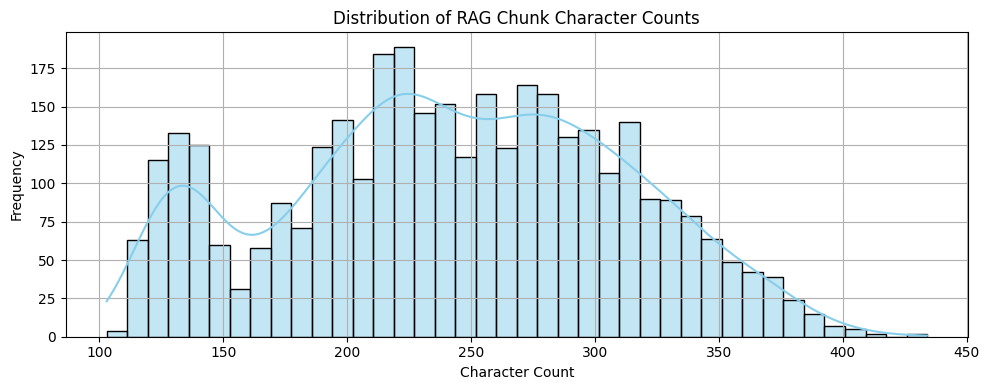

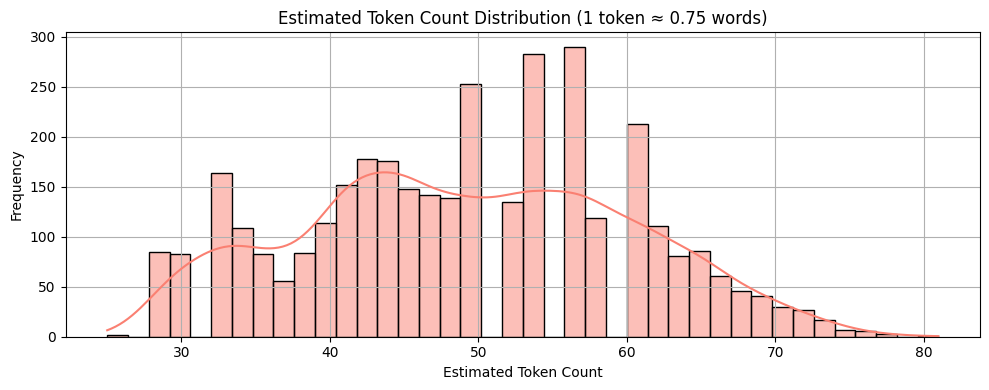

char_count   word_count  token_estimate
count  3525.000000  3525.000000     3525.000000
mean    242.414752    37.109787       49.142411
std      68.345042     8.210146       10.956141
min     103.000000    19.000000       25.000000
25%     195.000000    31.000000       41.000000
50%     242.000000    37.000000       49.000000
75%     294.000000    43.000000       57.000000
max     434.000000    61.000000       81.000000

business_id  \
2052  hNlvlGJsTXLJxeJ4RPsaeA   
3409  JHRlwxxKY0JJcU97rJ-Bug   
934   t3PkHzVTvPA8qRxKe9TIkQ   
943   DIG_4Jkj7YxgK7vha3XO6A   
3279  n6GeIePXC0G3eS8UPGvloQ   

                                         rag_text_chunk  
2052  Alamodak Restaurant and Hookah Lounge is a res...  
3409  Cuba Libre Restaurant & Rum Bar - Philadelphia...  
934   Booker's Restaurant and Bar is a restaurant lo...  
943   Red Lobster is a restaurant located at 9140 Ro...  
3279  Chops Restaurant & Bar is a restaurant located...

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Create temporary series (no changes to df_profile_chunks)
char_counts = df_profile_chunks["rag_text_chunk"].str.len()
word_counts = df_profile_chunks["rag_text_chunk"].str.split().apply(len)
token_estimates = (word_counts / 0.75).astype(int)

# Plot character count distribution
plt.figure(figsize=(10, 4))
sns.histplot(char_counts, bins=40, kde=True, color="skyblue")
plt.title("Distribution of RAG Chunk Character Counts")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot estimated token distribution
plt.figure(figsize=(10, 4))
sns.histplot(token_estimates, bins=40, kde=True, color="salmon")
plt.title("Estimated Token Count Distribution (1 token ≈ 0.75 words)")
plt.xlabel("Estimated Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display summary stats
display(pd.DataFrame({
    "char_count": char_counts.describe(),
    "word_count": word_counts.describe(),
    "token_estimate": token_estimates.describe()
}))

# Show top 5 longest chunks
top_long = token_estimates.sort_values(ascending=False).head(5).index
df_profile_chunks.loc[top_long, ["business_id", "rag_text_chunk"]]


In [ ]:
# Metadata fields to retain from business_df
metadata_fields = [
    "business_id",
    "name",
    "stars",
    "review_count",
    "categories_list",
    "latitude",
    "longitude",
    "RestaurantsPriceRange2"
]

# Pull and rename metadata fields
business_metadata = business_df[metadata_fields].copy()
business_metadata = business_metadata.rename(columns={
    "RestaurantsPriceRange2": "price_range",
    "name": "business_name"
})

# Merge metadata into profile chunks
df_profile_chunks = df_profile_chunks.merge(business_metadata, on="business_id", how="left")

# Add RAG-specific fields
df_profile_chunks["chunk_type"] = "profile"

# Reorder final column layout
df_profile_chunks = df_profile_chunks[[
    "business_id", "business_name", "chunk_type", "rag_text_chunk",
    "stars", "review_count", "categories_list", "price_range", "latitude", "longitude"
]]

print(f"✅ Profile Chunk DataFrame Shape: {df_profile_chunks.shape}")
df_profile_chunks.head()

✅ Profile Chunk DataFrame Shape: (3525, 10)


business_id       business_name chunk_type  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    profile   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar    profile   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP    profile   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall    profile   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa    profile   

                                      rag_text_chunk  stars  review_count  \
0  St Honore Pastries is a restaurant located at ...    4.0            80   
1  Tuna Bar is a restaurant located at 205 Race S...    4.0           245   
2  BAP is a restaurant located at 1224 South St, ...    4.5           205   
3  Craft Hall is a restaurant located at 901 N De...    3.5            65   
4  Wawa is a restaurant located at 3604 Chestnut ...    3.0            56   

                                     categories_list  price_range   latitude  \
0  [Restaurants, Food, Bubble Tea, Coffee & Tea, ...          1.0  39.955505   
1                [Sushi Bars, Restaurants, Japanese]          2.0  39.953949   
2                              [Korean, Restaurants]          1.0  39.943223   
3  [Eatertainment, Arts & Entertainment, Brewpubs...          2.0  39.962582   
4  [Restaurants, Automotive, Delis, Gas Stations,...          1.0  39.954573   

   longitude  
0 -75.155564  
1 -75.143226  
2 -75.162568  
3 -75.135657  
4 -75.194894

In [ ]:
# Final checks for profile chunk
nulls = df_profile_chunks.isnull().sum()
df_info = df_profile_chunks.info()

print(f"✅ Profile Chunk Null Values:\n{nulls}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3525 entries, 0 to 3524
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   business_id      3525 non-null   object 
 1   business_name    3525 non-null   object 
 2   chunk_type       3525 non-null   object 
 3   rag_text_chunk   3525 non-null   object 
 4   stars            3525 non-null   float64
 5   review_count     3525 non-null   int64  
 6   categories_list  3525 non-null   object 
 7   price_range      2830 non-null   float64
 8   latitude         3525 non-null   float64
 9   longitude        3525 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 275.5+ KB
✅ Profile Chunk Null Values:
business_id          0
business_name        0
chunk_type           0
rag_text_chunk       0
stars                0
review_count         0
categories_list      0
price_range        695
latitude             0
longitude            0
dtype: int64



### ✅ Review & Tip Chunk Generation Summary (`reviews_df`, `tips_df` → `df_review_chunks`, `df_tip_chunks`)

We extracted and processed user-generated content from Yelp’s Philadelphia dataset to form semantically rich review and tip chunks suitable for vector-based retrieval.

---

#### 📥 Starting Point

- **Input (Reviews)**: `reviews_df` containing up to 10 reviews per business:
  - 3 most useful
  - 2 most recent
  - 5 random (if available)

- **Input (Tips)**: `tips_df` containing up to 5 tips per business.

Each row = one user opinion tied to a `business_id`.

---

#### 🏗️ Chunk Construction

Each review or tip is transformed into a natural, standalone `rag_text_chunk`.

**Review Chunks** include:
- Full review text
- Often longer, detailed, and covers:
  - Food quality
  - Service experience
  - Atmosphere or complaints
  - Emotional tone

**Tip Chunks** include:
- Short, actionable insights
- Often formatted like suggestions or exclamations:
  - “Try the brisket sandwich!”
  - “Great for late-night snacks.”

---

#### 🧹 Cleaning and Safeguards

- Deduplicated reviews and tips using:
  - `review_id` for reviews
  - `(user_id, business_id, text)` for tips

- Trimmed excessively long or short entries
- Removed entries with:
  - Missing or null text
  - Zero-character chunks
- Tips filtered with:
  - `compliment_count > 0`
  - Reasonable length threshold (e.g., > 25 characters)

---

#### 🔄 Metadata and Consistency

Each chunk was standardized with:
- `chunk_type`: `"review"` or `"tip"`
- `rag_text_chunk`: Cleaned and safe for LLM input
- `business_id`: Backend key for grouping
- `business_name`: For all display and charting purposes
- `stars`: Star rating of the business (from metadata)
- `categories_list`: Cleaned list of business categories
- `price_range`, `latitude`, `longitude`: Location and price info
- ✅ `chunk_id`: Format = `{business_id}_{chunk_type}_{N}` based on order of appearance

---

#### 📏 Quality Checks

- Character count and word count histograms were generated
- Estimated token length verified to be within MiniLM/BGE safety range (~512–768 tokens)
- Ensured chunks are meaningful and syntactically complete

---

#### 📦 Final Output

- `df_review_chunks`: up to 10 rich review samples per business
- `df_tip_chunks`: short-form, high-signal user tips
- Both dataframes align with the unified schema used for vector store ingestion
- Fully ready for embedding with `rag_text_chunk`


In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

import pandas as pd

# Load the reviews dataset
reviews_df = pd.read_csv('/content/gdrive/MyDrive/BT5153_2025/project/philly_reviews_sampled.csv')
print(f"✅ Reviews DataFrame Shape: {reviews_df.shape}")

# Load the tips dataset
tips_df = pd.read_csv('/content/gdrive/MyDrive/BT5153_2025/project/philly_tips_sampled.csv')
print(f"✅ Tips DataFrame Shape: {tips_df.shape}")

Mounted at /content/gdrive
✅ Reviews DataFrame Shape: (33737, 9)
✅ Tips DataFrame Shape: (11915, 5)


In [ ]:
# Merge review data with business metadata
df_review_chunks = reviews_df.merge(
    business_df[[
        "business_id", "name", "categories_list", "RestaurantsPriceRange2", "latitude", "longitude"
    ]],
    on="business_id", how="left"
)

# Rename price field for consistency
df_review_chunks = df_review_chunks.rename(columns={
    "RestaurantsPriceRange2": "price_range",
    "name": "business_name"
})

# Create RAG-specific fields
df_review_chunks["rag_text_chunk"] = df_review_chunks["text"].astype(str).str.strip()
df_review_chunks["chunk_type"] = "review"

# Finalize column order
df_review_chunks = df_review_chunks[[
    "business_id", "business_name", "chunk_type", "rag_text_chunk",
    "stars", "categories_list", "price_range", "latitude", "longitude"
]]

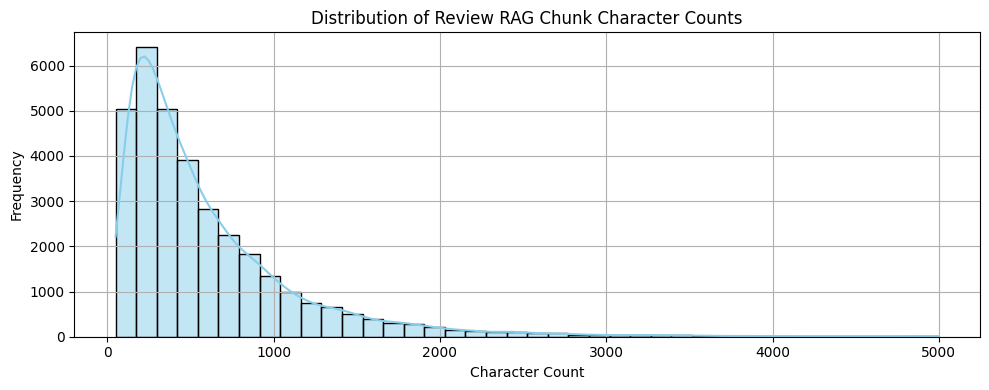

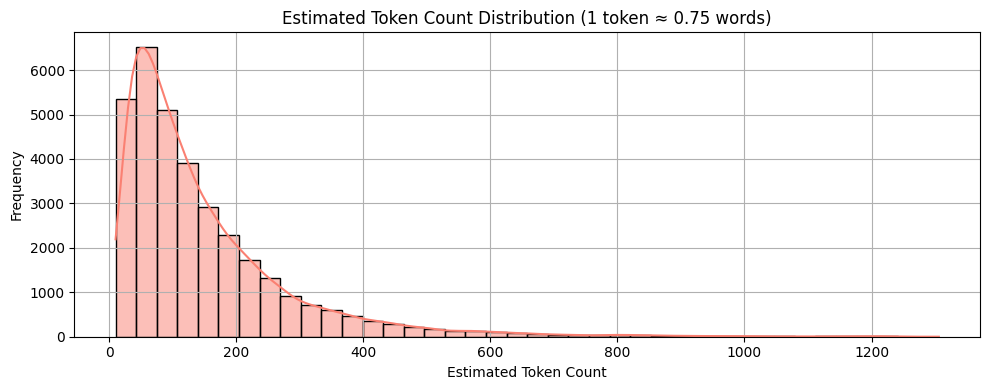

char_count    word_count  token_estimate
count  33737.000000  33737.000000    33737.000000
mean     608.607612    111.870735      148.827963
std      566.786114    103.955687      138.608771
min       50.000000      8.000000       10.000000
25%      237.000000     43.000000       57.000000
50%      433.000000     80.000000      106.000000
75%      782.000000    144.000000      192.000000
max     5000.000000    980.000000     1306.000000

business_id  \
27187  N3wKFf3q6vJi0g5g0Y1ICw   
693    NJe5fkia_63rdKXRdJlmkA   
25525  AddC68mgkczAcxHnzgByPw   
30451  emeIVZ3qJEb070uh1cucXQ   
29019  cLlBDZxYJ1dt1JgMuZnXew   

                                          rag_text_chunk  
27187  We go to this location almost daily because it...  
693    Hmmm. The majority of reviews here are either ...  
25525  I walked in and began to suspect that I was no...  
30451  I have to say I had high hopes for this place ...  
29019  Olly was not 'A-OK.' It was alright. \n\nI was...

In [ ]:
# Inspect Review RAG Chunk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# Temporary series for analysis (no changes to df_review_chunks)
char_counts = df_review_chunks["rag_text_chunk"].str.len()
word_counts = df_review_chunks["rag_text_chunk"].str.split().apply(len)
token_estimates = (word_counts / 0.75).astype(int)

# Plot character count distribution
plt.figure(figsize=(10, 4))
sns.histplot(char_counts, bins=40, kde=True, color="skyblue")
plt.title("Distribution of Review RAG Chunk Character Counts")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot estimated token distribution
plt.figure(figsize=(10, 4))
sns.histplot(token_estimates, bins=40, kde=True, color="salmon")
plt.title("Estimated Token Count Distribution (1 token ≈ 0.75 words)")
plt.xlabel("Estimated Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display summary stats
display(pd.DataFrame({
    "char_count": char_counts.describe(),
    "word_count": word_counts.describe(),
    "token_estimate": token_estimates.describe()
}))

# Show top 5 longest chunks
top_long = token_estimates.sort_values(ascending=False).head(5).index
df_review_chunks.loc[top_long, ["business_id", "rag_text_chunk"]]

In [ ]:
print(f"✅ Review Chunk DataFrame Shape: {df_review_chunks.shape}")
print(df_review_chunks.dtypes)
df_review_chunks.head()

✅ Review Chunk DataFrame Shape: (33737, 9)
business_id         object
business_name       object
chunk_type          object
rag_text_chunk      object
stars                int64
categories_list     object
price_range        float64
latitude           float64
longitude          float64
dtype: object


business_id                           business_name chunk_type  \
0  nIlmZLuMs0JuBRvAHSIf8Q  Bredenbeck's Bakery & Ice Cream Parlor     review   
1  nIlmZLuMs0JuBRvAHSIf8Q  Bredenbeck's Bakery & Ice Cream Parlor     review   
2  nIlmZLuMs0JuBRvAHSIf8Q  Bredenbeck's Bakery & Ice Cream Parlor     review   
3  nIlmZLuMs0JuBRvAHSIf8Q  Bredenbeck's Bakery & Ice Cream Parlor     review   
4  nIlmZLuMs0JuBRvAHSIf8Q  Bredenbeck's Bakery & Ice Cream Parlor     review   

                                      rag_text_chunk  stars  \
0  Limoncello cupcake runaway with me then get in...      5   
1  I had an awful experience with them. BRIDES BE...      1   
2  I came here to pick up a birthday cake for a g...      2   
3  Delivered a beautiful cake for my daughter's B...      5   
4  Love their cupcakes and ice cream!!!  Customer...      5   

                                     categories_list  price_range   latitude  \
0  [Food, Restaurants, Bakeries, Custom Cakes, Ic...          2.0  40.072499   
1  [Food, Restaurants, Bakeries, Custom Cakes, Ic...          2.0  40.072499   
2  [Food, Restaurants, Bakeries, Custom Cakes, Ic...          2.0  40.072499   
3  [Food, Restaurants, Bakeries, Custom Cakes, Ic...          2.0  40.072499   
4  [Food, Restaurants, Bakeries, Custom Cakes, Ic...          2.0  40.072499   

   longitude  
0 -75.202403  
1 -75.202403  
2 -75.202403  
3 -75.202403  
4 -75.202403

In [ ]:
# Merge tip data with business metadata
df_tip_chunks = tips_df.merge(
    business_df[[
        "business_id", "name", "categories_list", "RestaurantsPriceRange2", "latitude", "longitude", "stars"
    ]],
    on="business_id", how="left"
)

# Rename price field for consistency
df_tip_chunks = df_tip_chunks.rename(columns={
    "RestaurantsPriceRange2": "price_range",
    "name": "business_name"
})

# Create RAG-specific fields
df_tip_chunks["rag_text_chunk"] = df_tip_chunks["text"].astype(str).str.strip()
df_tip_chunks["chunk_type"] = "tip"

# Finalize column order
df_tip_chunks = df_tip_chunks[[
    "business_id", "business_name", "chunk_type", "rag_text_chunk",
    "stars", "categories_list", "price_range", "latitude", "longitude"
]]

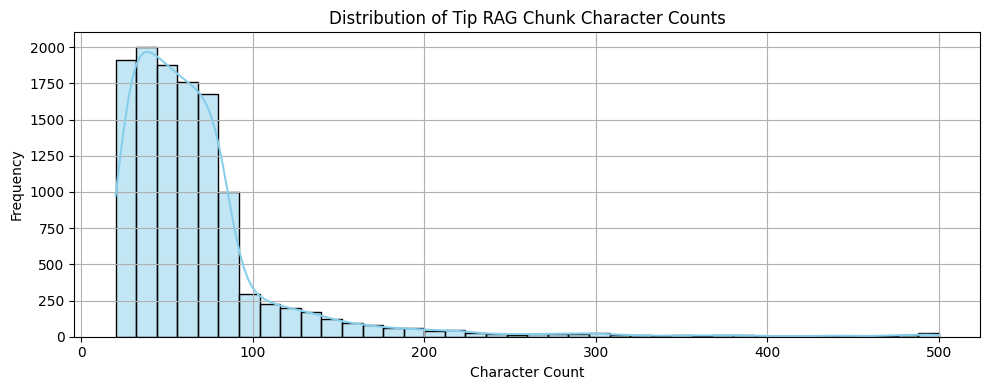

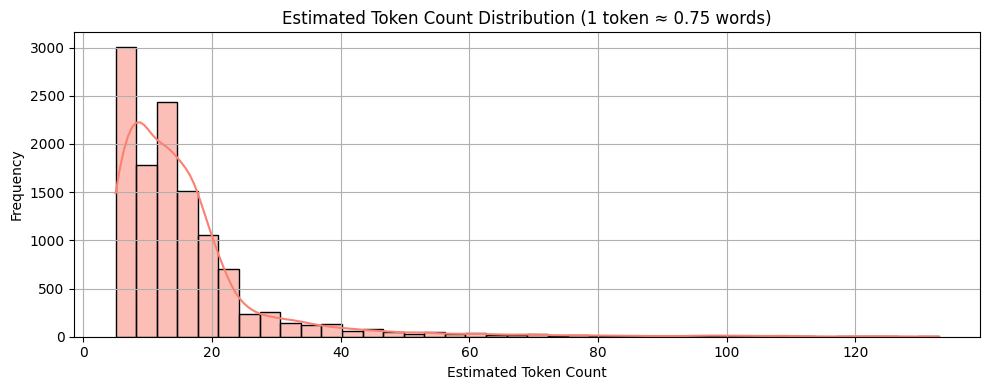

char_count    word_count  token_estimate
count  11915.000000  11915.000000    11915.000000
mean      68.365254     12.187495       15.909526
std       55.107507      9.985818       13.330349
min       20.000000      4.000000        5.000000
25%       38.000000      6.000000        8.000000
50%       57.000000     10.000000       13.000000
75%       77.000000     14.000000       18.000000
max      500.000000    100.000000      133.000000

business_id  \
6455   Z69P_L-gUbZpa6SQ57RuGg   
1180   HYNJFIp1x-8GjkxGcVetZg   
11771  5UjINogSwLL6SKRM5mEZng   
10161  X2JkEvWPO7_dEPHne7qJKg   
1747   P2Lm1g_RztvIaH4daQsXoQ   

                                          rag_text_chunk  
6455   When I went home to philly I stopped by the fo...  
1180   Amazing is all I got!!! My girls from work wen...  
11771  This hole in the wall was really dirty when I ...  
10161  They should really start sampling the stuff th...  
1747   Flies everywhere. One of the wait staff even p...

In [ ]:
# Adapted inspection for df_tip_chunks instead of df_review_chunks
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# Temporary series for analysis (no changes to df_tip_chunks)
char_counts = df_tip_chunks["rag_text_chunk"].str.len()
word_counts = df_tip_chunks["rag_text_chunk"].str.split().apply(len)
token_estimates = (word_counts / 0.75).astype(int)

# Plot character count distribution
plt.figure(figsize=(10, 4))
sns.histplot(char_counts, bins=40, kde=True, color="skyblue")
plt.title("Distribution of Tip RAG Chunk Character Counts")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot estimated token distribution
plt.figure(figsize=(10, 4))
sns.histplot(token_estimates, bins=40, kde=True, color="salmon")
plt.title("Estimated Token Count Distribution (1 token ≈ 0.75 words)")
plt.xlabel("Estimated Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display summary stats
display(pd.DataFrame({
    "char_count": char_counts.describe(),
    "word_count": word_counts.describe(),
    "token_estimate": token_estimates.describe()
}))

# Show top 5 longest chunks
top_long = token_estimates.sort_values(ascending=False).head(5).index
df_tip_chunks.loc[top_long, ["business_id", "rag_text_chunk"]]

In [ ]:
print(f"✅ Tip Chunk DataFrame Shape: {df_tip_chunks.shape}")
print(df_tip_chunks.dtypes)
df_tip_chunks.head()

✅ Tip Chunk DataFrame Shape: (11915, 9)
business_id         object
business_name       object
chunk_type          object
rag_text_chunk      object
stars              float64
categories_list     object
price_range        float64
latitude           float64
longitude          float64
dtype: object


business_id                          business_name chunk_type  \
0  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits        tip   
1  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits        tip   
2  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits        tip   
3  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits        tip   
4  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits        tip   

                                      rag_text_chunk  stars  \
0  If you signed up to get their emails, they'll ...    4.5   
1                 Awesome Sunday Brunch with mimosa.    4.5   
2         Deliciously spicy and flavor packed food!!    4.5   
3  The place has a nice setting on the street. Fo...    4.5   
4           Try the Malai Kofta Bukhara, it's yummy!    4.5   

                                     categories_list  price_range   latitude  \
0  [Cocktail Bars, Food Delivery Services, Nightl...          2.0  39.948508   
1  [Cocktail Bars, Food Delivery Services, Nightl...          2.0  39.948508   
2  [Cocktail Bars, Food Delivery Services, Nightl...          2.0  39.948508   
3  [Cocktail Bars, Food Delivery Services, Nightl...          2.0  39.948508   
4  [Cocktail Bars, Food Delivery Services, Nightl...          2.0  39.948508   

   longitude  
0 -75.161969  
1 -75.161969  
2 -75.161969  
3 -75.161969  
4 -75.161969

### 📦 Unified Chunk Assembly: `df_profile_chunks`, `df_review_chunks`, `df_tip_chunks` → `all_chunks`

We consolidated the three chunk types — profile, review, and tip — into a single DataFrame for downstream embedding and retrieval.

---

#### 🧱 Standardized Chunk Schema

Each chunk follows the same structure, enabling uniform embedding and indexing. All columns are aligned across `df_profile_chunks`, `df_review_chunks`, and `df_tip_chunks`:

- `business_id`: Unique backend identifier  
- `business_name`: Display label (may repeat for chain stores)  
- `chunk_type`: `"profile"`, `"review"`, or `"tip"`  
- `rag_text_chunk`: Cleaned natural-language content  
- `stars`: Star rating of the business  
- `categories_list`: Cleaned list of categories  
- `price_range`: Integer 1–4 (nullable)  
- `latitude`, `longitude`: Location info  
- `detected_lang`: Language code detected from chunk text (e.g., `"en"`, `"zh"`)  
- ✅ `chunk_id`: Unique identifier in format `{business_id}_{chunk_type}_{N}`  

---

#### 🔄 Pre-Merge Processing Steps

- Ensured each source chunk DataFrame includes all required columns  
- Filled missing metadata fields (e.g., `price_range`, `categories_list`) with `pd.NA`  
- Reordered columns for consistency  
- Converted `price_range` to nullable integer (`Int64`)  
- Merged `business_name` from restaurant metadata using `business_id`  
- Added `detected_lang` using `langdetect` for downstream filtering and multilingual prompt alignment  

---

#### 🆔 Chunk ID Generation

Each chunk receives a unique, human-readable `chunk_id` for downstream tracing and retrieval:

```
chunk_id = {business_id}_{chunk_type}_{sequence_number}
```

- Used as `id_` in LlamaIndex  
- Stored in `.metadata["chunk_id"]` for LangChain  

---

#### 🏗️ Final Merge

The unified DataFrame is created with:

```python
all_chunks = pd.concat([df_profile_chunks, df_review_chunks, df_tip_chunks], ignore_index=True)
```

Final steps:
- Applied column sorting and reordering  
- Verified no missing `business_name` entries  
- Confirmed all rows are chunked and metadata-ready  
- Applied language detection (`detected_lang`) to all `rag_text_chunk` entries  

---

#### 👁️ Sample Output (One Chunk per Type)

**Profile Chunk**  
> *"Dim Sum Garden is a Chinese restaurant located at 1020 Race St in Philadelphia. It has 4.5 stars from 2154 reviews. Known for its pork soup dumplings and fast service. Offers delivery, takeout, and wheelchair access. Open late on most days."*

**Review Chunk**  
> *"The soup dumplings are amazing! Hot, fresh, and flavorful. Service was fast even on a busy Saturday night."*

**Tip Chunk**  
> *"Definitely try the pork soup dumplings. Best in the city!"*

---

#### ✅ Output

- **DataFrame**: `all_chunks`  
- **Ready for**: Embedding, vector indexing (FAISS), and semantic retrieval  
- **Includes**: `detected_lang` for language-aware retrieval and multilingual prompting  
- Supports disambiguation of chain stores by retaining `business_id` for uniqueness and `business_name` for display

In [ ]:
# Define the required column schema (excluding chunk_id for now)
chunk_columns = [
    "business_id", "business_name", "chunk_type", "rag_text_chunk",
    "stars", "categories_list", "price_range", "latitude", "longitude"
]

# Ensure all three chunk types conform to the schema
for df in [df_profile_chunks, df_review_chunks, df_tip_chunks]:
    for col in chunk_columns:
        if col not in df.columns:
            df[col] = pd.NA
    df = df[chunk_columns]  # Local reorder

# Reassign reordered DataFrames (since reordering in loop won't persist)
df_profile_chunks = df_profile_chunks[chunk_columns]
df_review_chunks = df_review_chunks[chunk_columns]
df_tip_chunks = df_tip_chunks[chunk_columns]

# Merge all chunks together
all_chunks = pd.concat([df_profile_chunks, df_review_chunks, df_tip_chunks], ignore_index=True)

# Convert price_range to nullable integer type
all_chunks["price_range"] = all_chunks["price_range"].astype("Int64")

# Create a unique, human-readable chunk_id
all_chunks["chunk_id"] = (
    all_chunks["business_id"].astype(str) + "_" +
    all_chunks["chunk_type"].astype(str) + "_" +
    all_chunks.groupby(["business_id", "chunk_type"]).cumcount().astype(str)
)

# Final column arrangement
preferred_order = [
    'chunk_id',
    'business_id',
    'business_name',
    'chunk_type',
    'rag_text_chunk',
    'stars',
    'categories_list',
    'price_range',
    'latitude', 'longitude'
]
remaining_cols = [col for col in all_chunks.columns if col not in preferred_order]
all_chunks = all_chunks[preferred_order + remaining_cols]

# Confirm
print("✅ Final columns after merge and rearrangement:")
print(all_chunks.columns.tolist())

✅ Final columns after merge and rearrangement:
['chunk_id', 'business_id', 'business_name', 'chunk_type', 'rag_text_chunk', 'stars', 'categories_list', 'price_range', 'latitude', 'longitude']


In [ ]:
# Inspection step
print(f"All Chunk DataFrame Shape: {all_chunks.shape}")
print(f"All Chunk DataFrame Dtypes:\n{all_chunks.dtypes}")

# Display 10 random rows directly
display(all_chunks.sample(n=20, random_state=42))

All Chunk DataFrame Shape: (49177, 10)
All Chunk DataFrame Dtypes:
chunk_id            object
business_id         object
business_name       object
chunk_type          object
rag_text_chunk      object
stars              float64
categories_list     object
price_range          Int64
latitude           float64
longitude          float64
dtype: object


chunk_id             business_id  \
33273   cunSJWc4s4A2kbbnFoYBow_review_0  cunSJWc4s4A2kbbnFoYBow   
28945   G1q1IeNbiRJL5bReBLFdzQ_review_3  G1q1IeNbiRJL5bReBLFdzQ   
36773   QyWxTsVvvqSEpU1KNblRbQ_review_9  QyWxTsVvvqSEpU1KNblRbQ   
31683   0De2juaQqHNUYs-vNEj9RA_review_4  0De2juaQqHNUYs-vNEj9RA   
40128      fBoo1Q7xQOZvUDfIarkETA_tip_0  fBoo1Q7xQOZvUDfIarkETA   
12044   Iyopb5uFIBT_HOgp8ipSfw_review_0  Iyopb5uFIBT_HOgp8ipSfw   
35122   XylObKandNdgPcvqdbA64w_review_2  XylObKandNdgPcvqdbA64w   
25635   zf10JmXNZFljGl3IgWW-Lg_review_1  zf10JmXNZFljGl3IgWW-Lg   
47590      _RRGOrzVgsEE4MlHHZE6iQ_tip_2  _RRGOrzVgsEE4MlHHZE6iQ   
36881   sfbg2kxnvKpmlIuCUas5TA_review_3  sfbg2kxnvKpmlIuCUas5TA   
6994    _34KJPR-T0HP9USJw1nCfw_review_4  _34KJPR-T0HP9USJw1nCfw   
36429   DQDZQp-THbeWE1uQ7CNZ5w_review_9  DQDZQp-THbeWE1uQ7CNZ5w   
12103   XPwT83sQMlVCh8_ztbyCFw_review_9  XPwT83sQMlVCh8_ztbyCFw   
36420   DQDZQp-THbeWE1uQ7CNZ5w_review_0  DQDZQp-THbeWE1uQ7CNZ5w   
24839   E-DcL1u330qwvoxXhipmUQ_review_4  E-DcL1u330qwvoxXhipmUQ   
33493   li4Yw2cG968EiymHMCdoXg_review_4  li4Yw2cG968EiymHMCdoXg   
17291   NMrjPhdqWBn1vRvaNg5GRg_review_1  NMrjPhdqWBn1vRvaNg5GRg   
1414   eOEjkrby-5R2cdYqzXiBNQ_profile_0  eOEjkrby-5R2cdYqzXiBNQ   
40816      piTT5OuV6ePIc_awSG0caQ_tip_0  piTT5OuV6ePIc_awSG0caQ   
37724      6OC8ErU_m06KABnfSXTJEA_tip_3  6OC8ErU_m06KABnfSXTJEA   

                   business_name chunk_type  \
33273  ShopRite of Front & Olney     review   
28945                Mercer Cafe     review   
36773                 Say Cheese     review   
31683         CYM Island Kitchen     review   
40128      Salam Cafe and Market        tip   
12044         Le Viet Restaurant     review   
35122           Scanlon's Saloon     review   
25635                       Mizu     review   
47590      Great Awakenings Cafe        tip   
36881       Lucky Wok Restaurant     review   
6994            Hiro Ramen House     review   
36429        Colney Delicatessen     review   
12103    Philly's Gourmet Steaks     review   
36420        Colney Delicatessen     review   
24839     George's Sandwich Shop     review   
33493         Redz Bar and Grill     review   
17291       Overbrook Pizza Shop     review   
1414                   Los Tacos    profile   
40816       Sweets & Curry House        tip   
37724                Street Side        tip   

                                          rag_text_chunk  stars  \
33273  This is the worst ShopRite. I use to frequent ...    1.0   
28945  I'm not really a fan of this spot. I've been h...    2.0   
36773  I have heard about Say Cheese many times but t...    2.0   
31683  The food is always amazing !!!!! The only issu...    4.0   
40128  Great food and friendly fast service . I will ...    5.0   
12044  Just an update - besty and I made our weekly p...    5.0   
35122  I love a corner neighborhood bar. Being new to...    5.0   
25635  Dirt cheap and surprisingly good.\n\nI normall...    4.0   
47590  This place is great! Humble and cozy and fabul...    4.5   
36881  Nov. 2012\nUpon reading good online reviews, I...    1.0   
6994   Hiro is my favorite ramen shop in Philadelphia...    5.0   
36429  I was blown away by how nice this place is on ...    3.0   
12103  Stopped in to grab a cheesesteak and it didn't...    5.0   
36420  Yes! A good beer store downtown, near Rittenho...    4.0   
24839  The PBR was excellent but they need to do some...    4.0   
33493  Stopped back in after about 3 years and it was...    4.0   
17291  A small place with a lot of heart...\n\nAnd di...    4.0   
1414   Los Tacos is a restaurant located at 5104 N 5t...    3.5   
40816                The lamb korma was so good. Love it    3.5   
37724       Amazing! \nGreat food and great vibes.\nBYOB    4.5   

                                         categories_list  price_range  \
33273  [Food, Grocery, Shopping Centers, Event Planni...            2   
28945  [Restaurants, Breakfast & Brunch, Pizza, Sandw...            2   
36773   

Chunk Type Distribution:
chunk_type
review     33737
tip        11915
profile     3525
Name: count, dtype: int64


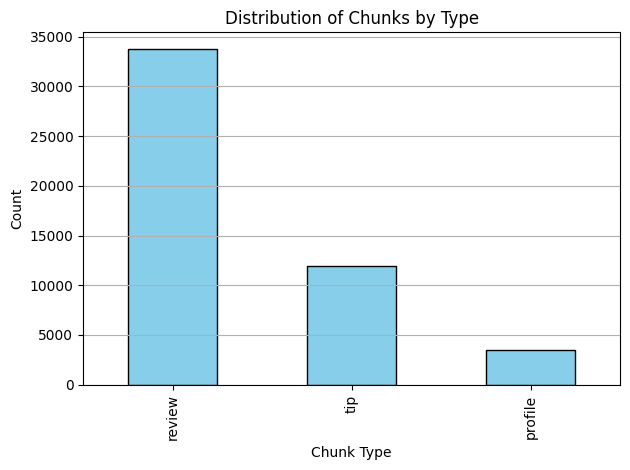

In [ ]:
# Distribution of chunks by chunk_type
chunk_type_counts = all_chunks['chunk_type'].value_counts()

# Print the raw counts
print("Chunk Type Distribution:")
print(chunk_type_counts)

# Optional: bar chart for visual overview
import matplotlib.pyplot as plt

chunk_type_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Chunks by Type")
plt.xlabel("Chunk Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Chunk Type Distribution (Overall):
chunk_type
review     33737
tip        11915
profile     3525
Name: count, dtype: int64


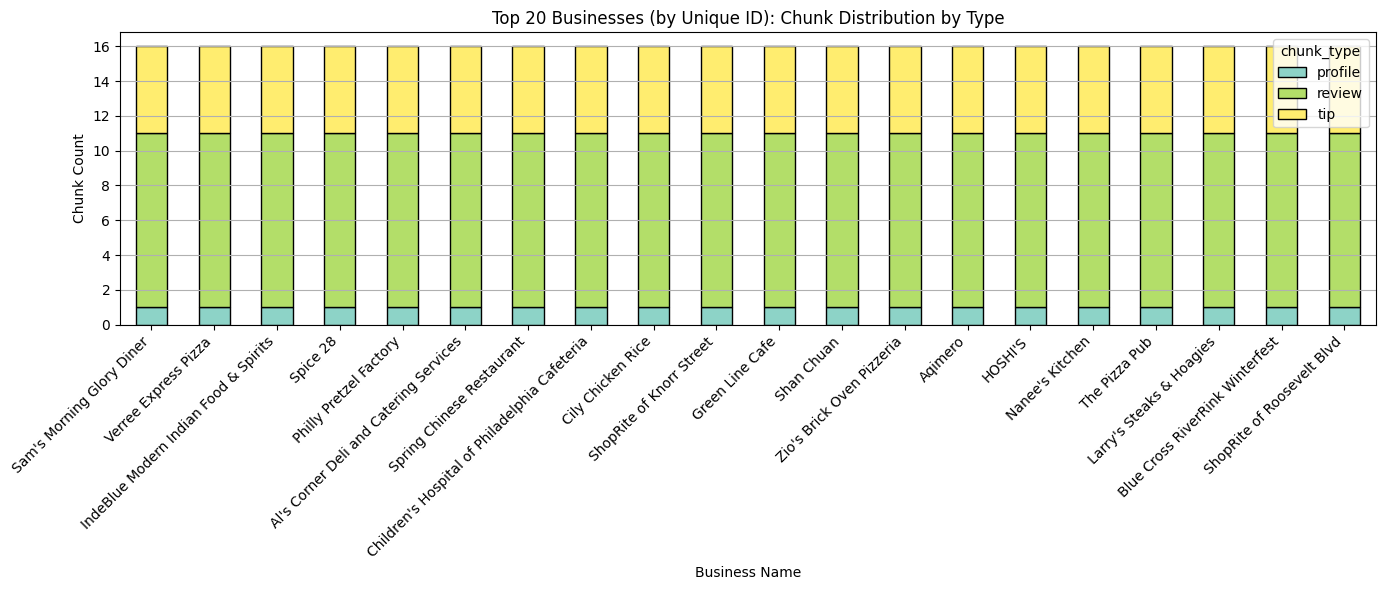

In [ ]:
import matplotlib.pyplot as plt

# 1. Chunk count by type
chunk_type_counts = all_chunks['chunk_type'].value_counts()
print("Chunk Type Distribution (Overall):")
print(chunk_type_counts)

# 2. Chunk count per business_id by type (preserve uniqueness)
chunks_per_business = (
    all_chunks.groupby(['business_id', 'chunk_type'])
    .size()
    .unstack(fill_value=0)
)

# 3. Get business_name mapping
id_to_name = (
    all_chunks.drop_duplicates(subset='business_id')[['business_id', 'business_name']]
    .set_index('business_id')['business_name']
)

# 4. Top 20 businesses by chunk volume (still by business_id)
top_business_ids = chunks_per_business.sum(axis=1).sort_values(ascending=False).head(20).index
chunks_top20 = chunks_per_business.loc[top_business_ids]

# 5. Use business_name as display label (but retain business_id uniqueness)
chunks_top20.index = [id_to_name.get(bid, 'Unknown') for bid in chunks_top20.index]

# 6. Plot
chunks_top20.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set3', edgecolor='black')
plt.title("Top 20 Businesses (by Unique ID): Chunk Distribution by Type")
plt.xlabel("Business Name")
plt.ylabel("Chunk Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

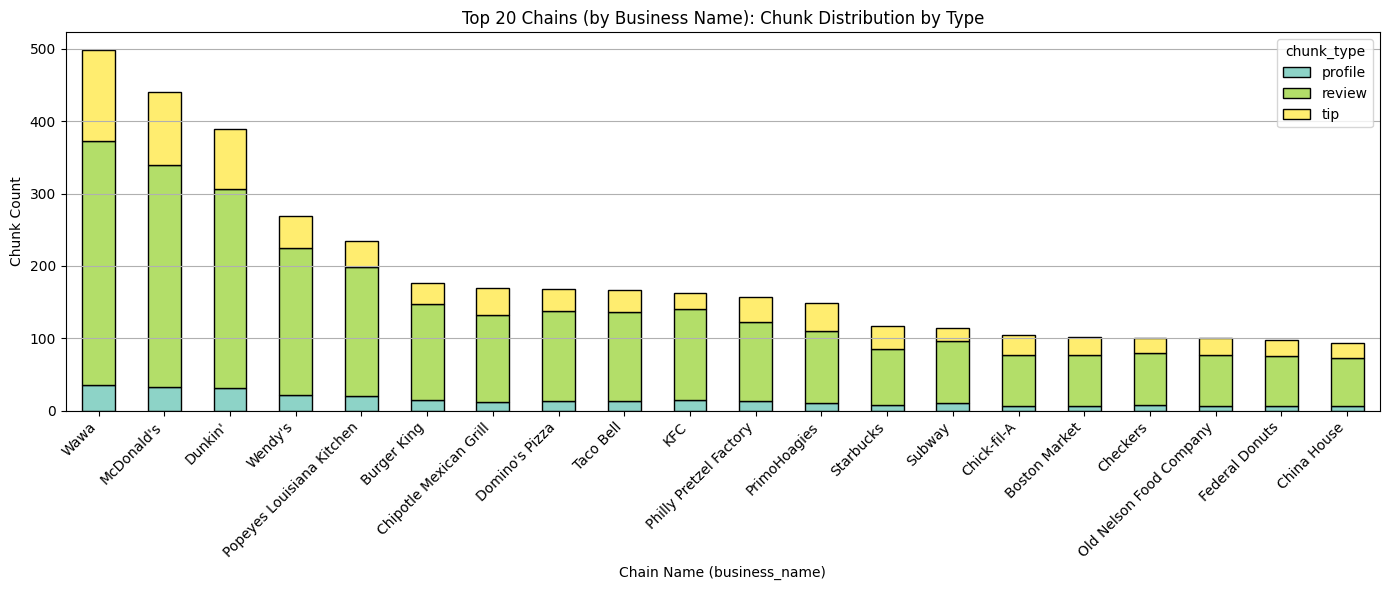

In [ ]:
# Chain restaurants share the same business name but different business_ids. Let's see which chains are most prominent in Philly.

# Group chunks by business_name (collapsing all locations of a chain)
chunks_by_chain = (
    all_chunks.groupby(['business_name', 'chunk_type'])
    .size()
    .unstack(fill_value=0)
)

# 2. Get top 20 chains by total chunks
top_chains = chunks_by_chain.sum(axis=1).sort_values(ascending=False).head(20).index
chunks_top20_chains = chunks_by_chain.loc[top_chains]

# 3. Plot stacked bar chart
chunks_top20_chains.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='Set3',
    edgecolor='black'
)
plt.title("Top 20 Chains (by Business Name): Chunk Distribution by Type")
plt.xlabel("Chain Name (business_name)")
plt.ylabel("Chunk Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
# ✅ Language check — affects embedding quality
!pip install -q langdetect

import pandas as pd
from langdetect import detect
from tqdm import tqdm
from collections import Counter

tqdm.pandas()

# ✅ Detect language from first 200 characters (avoid timeout)
print("🌍 Running language detection on RAG chunks...")
lang_detected = all_chunks['rag_text_chunk'].dropna().progress_apply(lambda x: detect(x[:200]))

# ✅ Add to main DataFrame
all_chunks.loc[lang_detected.index, 'detected_lang'] = lang_detected

# ✅ Show distribution of languages
print("\n🔤 Language Distribution:")
print(Counter(lang_detected))

# ✅ Inline display: First 50 non-English rows (don't assign a new df)
print("\n🌐 Non-English chunks (first 50):")
display(all_chunks[all_chunks["detected_lang"] != "en"].head(50))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
🌍 Running language detection on RAG chunks...


100%|██████████| 49177/49177 [02:04<00:00, 395.12it/s]


🔤 Language Distribution:
Counter({'en': 48620, 'it': 100, 'af': 58, 'da': 46, 'es': 41, 'de': 41, 'no': 41, 'nl': 40, 'fr': 30, 'ro': 26, 'ca': 18, 'cy': 17, 'so': 15, 'tl': 14, 'sv': 14, 'pt': 10, 'id': 9, 'hr': 9, 'et': 7, 'sl': 5, 'sq': 3, 'tr': 3, 'fi': 2, 'lt': 2, 'pl': 2, 'zh-cn': 1, 'sw': 1, 'vi': 1, 'hu': 1})

🌐 Non-English chunks (first 50):


chunk_id             business_id  \
5686   V8we7-uCa-SouadZmZ9Ieg_review_7  V8we7-uCa-SouadZmZ9Ieg   
6022   ehHQQflMgSUX5T3PFyjBWQ_review_3  ehHQQflMgSUX5T3PFyjBWQ   
7441   lQqHGyMrCfnPJATp7wUrZQ_review_6  lQqHGyMrCfnPJATp7wUrZQ   
7493   wjGV_sRxlhLKgvOBA8PhYQ_review_8  wjGV_sRxlhLKgvOBA8PhYQ   
9347   IBIp-yVFl2PxYS-rgc19Yg_review_0  IBIp-yVFl2PxYS-rgc19Yg   
9714   TwnzM8mJn_nT2PJf1x-9kQ_review_7  TwnzM8mJn_nT2PJf1x-9kQ   
10481  J14P8Bo0yDYYXyASbht5xQ_review_3  J14P8Bo0yDYYXyASbht5xQ   
12428  0ak-7uV9Nb7nF_l-mMCysA_review_7  0ak-7uV9Nb7nF_l-mMCysA   
12780  VwZ5NDbIu3elGQI6MzcXBA_review_5  VwZ5NDbIu3elGQI6MzcXBA   
13302  jyBbsc6LrIwdJYD9jFuiaw_review_7  jyBbsc6LrIwdJYD9jFuiaw   
13938  7__20lI7RsC9J6C-DrTzFg_review_2  7__20lI7RsC9J6C-DrTzFg   
13940  7__20lI7RsC9J6C-DrTzFg_review_4  7__20lI7RsC9J6C-DrTzFg   
16082  R5j_K2NTLREJspZNbnEZYQ_review_9  R5j_K2NTLREJspZNbnEZYQ   
17078  gG0Pp5P6BA7zk-vX3-CLCw_review_6  gG0Pp5P6BA7zk-vX3-CLCw   
17714  eOEjkrby-5R2cdYqzXiBNQ_review_7  eOEjkrby-5R2cdYqzXiBNQ   
18021  W2gSKulDUBGTfcSDk8kNvg_review_6  W2gSKulDUBGTfcSDk8kNvg   
20210  HdbG53Bt29qyqYhjl5NDOw_review_3  HdbG53Bt29qyqYhjl5NDOw   
20667  LxM8hN8jRG0rGhlDJhd8XA_review_5  LxM8hN8jRG0rGhlDJhd8XA   
20981  _IYHl6J9iB3lbeJq27pbsg_review_0  _IYHl6J9iB3lbeJq27pbsg   
20982  _IYHl6J9iB3lbeJq27pbsg_review_1  _IYHl6J9iB3lbeJq27pbsg   
21800  Mfyqn9bYNL7jVsXjXH_ymg_review_3  Mfyqn9bYNL7jVsXjXH_ymg   
22074  jc6PRKXaOwQeKtQGXoG76Q_review_1  jc6PRKXaOwQeKtQGXoG76Q   
25884  5M3AWxHBAJn6ET3AtBzmDw_review_4  5M3AWxHBAJn6ET3AtBzmDw   
26432  xGdwgy-DM98Tpy-S-GCegA_review_0  xGdwgy-DM98Tpy-S-GCegA   
26435  xGdwgy-DM98Tpy-S-GCegA_review_3  xGdwgy-DM98Tpy-S-GCegA   
26963  -rDhWLQJ28L2ttkaftdZNQ_review_3  -rDhWLQJ28L2ttkaftdZNQ   
27245  krCwF4raTYvBcCEwcbA88Q_review_0  krCwF4raTYvBcCEwcbA88Q   
27320  j2ix9c4vxxoRgS_U6IBLvQ_review_6  j2ix9c4vxxoRgS_U6IBLvQ   
27738  -Bhoyo7LL97tgt9Hze0Saw_review_5  -Bhoyo7LL97tgt9Hze0Saw   
27955  T98nJU1RgjJfRJmJv4cOaA_review_4  T98nJU1RgjJfRJmJv4cOaA   
27957  T98nJU1RgjJfRJmJv4cOaA_review_6  T98nJU1RgjJfRJmJv4cOaA   
28292  XQ_wVhRayMJGQT9J_WANkw_review_6  XQ_wVhRayMJGQT9J_WANkw   
28879  PRmGQsldPV7I5uZhEEymyw_review_2  PRmGQsldPV7I5uZhEEymyw   
29574  td_BI5T5qP01T5QfD4j3Sg_review_5  td_BI5T5qP01T5QfD4j3Sg   
29576  td_BI5T5qP01T5QfD4j3Sg_review_7  td_BI5T5qP01T5QfD4j3Sg   
29577  td_BI5T5qP01T5QfD4j3Sg_review_8  td_BI5T5qP01T5QfD4j3Sg   
30412  pXMxvdHKzCuSQhZu0MEOHg_review_5  pXMxvdHKzCuSQhZu0MEOHg   
30474  o4_cgIKWgvJ09TZeSzARmg_review_7  o4_cgIKWgvJ09TZeSzARmg   
31354  alUk6OwNhofyc90NDMDY-Q_review_5  alUk6OwNhofyc90NDMDY-Q   
31535  dIwOZoxwSpPUV3eMYFzPqw_review_6  dIwOZoxwSpPUV3eMYFzPqw   
32580  zMLA0-Qd9_4nHvovBaAMzQ_review_7  zMLA0-Qd9_4nHvovBaAMzQ   
32757  vKZhZqCa6bcdFieu0NYh0A_review_6  vKZhZqCa6bcdFieu0NYh0A   
34817  pFMGXlE1NwEXYPBgw3kRnA_review_4  pFMGXlE1NwEXYPBgw3kRnA   
35952  oSdgCWWlUI3pv1DjAADmXA_review_5  oSdgCWWlUI3pv1DjAADmXA   
36616  kPaixPxjX2qC0Z7ASbirPA_review_9  kPaixPxjX2qC0Z7ASbirPA   
36748  v5iurptJZo_7xm2Qm-3lgQ_review_4  v5iurptJZo_7xm2Qm-3lgQ   
37267     -1B9pP_CrRBJYPICE5WbRA_tip_0  -1B9pP_CrRBJYPICE5WbRA   
37297     -RckAAIJ-_KH0AzqrekYuw_tip_0  -RckAAIJ-_KH0AzqrekYuw   
37299     -RckAAIJ-_KH0AzqrekYuw_tip_2  -RckAAIJ-_KH0AzqrekYuw   
37319     -nIXhxPvxST6bTuj9jo1UQ_tip_2  -nIXhxPvxST6bTuj9jo1UQ   

                              business_name chunk_type  \
5686                 The Cheesecake Factory     review   
6022   Tortas & Pizza El Sabor De Mi Tierra     review   
7441                Santucci Square Pizza V     review   
7493            Malbec Argentine Steakhouse     review   
9347            Independence Visitor Center     review   
9714                              Cafe Lift     review   
10481                       Huff & Puff BBQ     review   
12428                           Oishii Poké     review   
12780                             Blue Corn     review   
13302        Aldo and Manny Pizza and Pasta     review   
13938                    

### Oh dear...forgot that there are non-English reviews in Yelp dataset. We have to make adjustments to model strategies for embedding and retrieval later.

### Language is now a metadata column

In [ ]:
# Save unified chunk as parquet and csv file
# Parquet file retains list structure. CSV file is for feeding into LLM if you wish to perform exploration there.
all_chunks.to_parquet('/content/gdrive/MyDrive/BT5153_2025/project/philly_chunks.parquet', index=False)
all_chunks.to_csv('/content/gdrive/MyDrive/BT5153_2025/project/philly_chunks.csv', index=False)

## 📌 Embedding + Vector Store Indexing (with `bge-m3`)

This section describes how we transform our unified RAG chunks (`all_chunks`) into dense multilingual vector representations using the `bge-m3` model, and store them in a FAISS index for fast semantic retrieval.

---

#### 🔧 Model Setup

- **Embedding model**: `BAAI/bge-m3`  
- **Tokenizer limit**: 512 tokens per chunk  
- **Output vector dimension**: 768  
- **Framework**: Hugging Face Transformers (via `sentence-transformers`)  

We use batched encoding and normalize all vectors for inner product search (cosine similarity equivalent).

---

#### 🧠 Embedding Procedure

- **Input**: `all_chunks["rag_text_chunk"]` (one chunk per row)  
- **Output**: `embedding_matrix` — NumPy array of shape `(N, 768)`  
- **Multilingual support**: Spanish, Chinese, German, etc. are embedded natively

Example:

```python
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("BAAI/bge-m3")
texts = all_chunks["rag_text_chunk"].tolist()
embeddings = model.encode(texts, batch_size=32, normalize_embeddings=True)
```
---

#### 🗃️ Vector Store: FAISS Index

We use FAISS for high-speed vector similarity search:

- **Index type**: `IndexFlatIP` (cosine similarity via inner product)  
- **Index size**: one row per chunk  
- **Colab-friendly**: small memory footprint, fast queries

Example:


```python
import faiss
import numpy as np

embedding_matrix = np.vstack(embeddings)
index = faiss.IndexFlatIP(embedding_matrix.shape[1])
index.add(embedding_matrix)
```

---

#### 🧾 Metadata Store

We retain business-level and chunk-level metadata for grouping and prompt assembly:


```python
chunk_metadata = all_chunks[[
    "chunk_id", "business_id", "business_name", "chunk_type",
    "stars", "categories_list", "price_range", "latitude", "longitude", "detected_lang"
]]
```

---

#### ✅ Output

- `embedding_matrix` (NumPy)  
- `faiss.IndexFlatIP` object  
- `chunk_metadata` for retrieval + multilingual filtering  
- Fully compatible with RAG + re-ranking pipeline


### ✅ Embedding Model Decision Summary: Why We Switched to `bge-m3`

After evaluating multiple embedding models for our RAG-based restaurant recommender, we upgraded to **`bge-m3`** to support multilingual retrieval while maintaining high performance in English.

---

#### 🔍 Models Compared

| Model                  | Token Limit | Vector Dim | Speed (Colab T4) | Retrieval Quality       | Memory Load | Notes                              |
|------------------------|-------------|------------|-------------------|---------------------------|--------------|-------------------------------------|
| `bge-m3`               | 512         | 768        | ⚡⚡ 30–35/sec      | ✅ Top-tier multilingual   | ✅ Medium     | Strong for both English and non-English |
| `bge-base-en-v1.5`     | 512         | 768        | ⚡ 30–40/sec       | ✅ Strong (English only)   | ✅ Light      | Previous default, now limited in scope |
| `Stella_EN_1.5B_v5`    | 512         | 2048       | 🐢 1–3/sec         | 🔥 Excellent (English)     | 🚫 Heavy      | Not viable on Colab T4              |
| `all-MiniLM-L6-v2`     | 384         | 384        | ⚡⚡⚡ 60–70/sec     | 👍 Decent (English only)   | ✅ Very Light | Fast fallback, but shallow embeddings |

---

#### 🌐 Why We Chose `bge-m3`

- ✅ **Multilingual support** across 100+ languages (reviews, tips, user queries)
- ✅ **Excellent performance on MTEB multilingual benchmarks**
- ✅ **Compatible with FAISS, LangChain, Hugging Face Transformers**
- ✅ **Performs well even for non-English restaurant reviews (Spanish, German, Chinese, etc.)**
- ✅ **Colab-friendly speed and memory footprint (~570MB)**

---

#### 🗓️ Model Recency and Popularity

- **Released:** August 2024 by Beijing Academy of AI (BAAI)
- Outperforms most multilingual sentence encoders, including LaBSE and MiniLM
- Featured in multilingual retrieval leaderboards on MTEB
- Ideal for globally-aware RAG pipelines (travel, food, reviews)

---

#### 📌 Final Embedding Strategy

- **Embedding model:** `bge-m3`
- **Tokenizer limit:** 512 tokens per chunk
- **Frameworks:** Hugging Face Transformers + FAISS (flat cosine index)
- **Multilingual readiness:** `detected_lang` used in metadata for chunk filtering or reranking

We will re-embed all `rag_text_chunk` entries with `bge-m3` to ensure consistent cross-lingual similarity, allowing us to support English and overseas users in the same pipeline.

---

### ✅ Embedding + Vector Store Indexing — Finalized Decisions

---

#### 🧠 Embedding Setup

| Decision Point            | Choice              | Notes                                               |
|---------------------------|---------------------|-----------------------------------------------------|
| **Embedding model**       | `BAAI/bge-m3`       | Multilingual, 512 token cap                         |
| **Batch size**            | `128`               | Tuned for Colab T4 memory efficiency                |
| **Normalization**         | `True`              | Required for cosine similarity (`IndexFlatIP`)      |
| **Output dimension**      | `1024`              | Set by BGE-M3, used to initialize FAISS             |

---

#### 💾 Embedding Storage & Recovery

| Decision Point            | Choice                          | Notes                                              |
|---------------------------|----------------------------------|----------------------------------------------------|
| **Save per batch**        | ✅ `.npy` files per batch        | Enables resumability and audit trail              |
| **Resume support**        | ✅ Scan existing files           | Skips completed batches automatically             |
| **Save directory**        | `/content/embeddings_batches/` | Filename format: `embed_batch_{n}.npy`            |

---

#### 🧲 FAISS Indexing

| Decision Point            | Choice                    | Notes                                               |
|---------------------------|---------------------------|-----------------------------------------------------|
| **Index type**            | `IndexFlatIP`             | Cosine similarity via normalized vectors            |
| **Add embeddings live**   | ✅ Yes                    | Embeddings added to FAISS after each batch          |
| **Checkpoint frequency**  | Every 5 batches           | Saved as `.checkpoint`                              |
| **Final index path**      | `/project/faiss_index_bge_m3.index` | Used for retrieval                              |
| **Crash recovery**        | ✅ `try/except` handler   | Saves `.interrupted` index if interrupted           |

---

#### 🧪 Crash Handling & Logging

| Decision Point            | Choice      | Notes                                               |
|---------------------------|-------------|-----------------------------------------------------|
| **Colab-disconnect safe** | ✅ Yes      | Can resume mid-process                             |
| **Batch-level traceability** | ✅ Yes   | Files and logs per batch for debugging


In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

import pandas as pd

# Load unified chunks parquet file
all_chunks = pd.read_parquet('/content/gdrive/MyDrive/BT5153_2025/project/philly_chunks.parquet')
print(f"✅ All Chunk DataFrame Shape: {all_chunks.shape}")

Mounted at /content/gdrive
✅ All Chunk DataFrame Shape: (49177, 11)


In [ ]:
# ✅ Required setup
!pip install -q faiss-cpu sentence-transformers

import os
import numpy as np
import pandas as pd
import faiss
import torch
from tqdm import tqdm
from glob import glob
from sentence_transformers import SentenceTransformer

# ✅ Configuration
chunk_save_dir = "/content/embeddings_batches"
embedding_save_path = "/content/gdrive/MyDrive/BT5153_2025/project/chunk_embeddings.npy"
index_save_path = "/content/gdrive/MyDrive/BT5153_2025/project/faiss_index_bge_m3.index"
batch_prefix = "embed_batch_"
BATCH_SIZE = 1024
DIM = 1024  # bge-m3 output dimension

os.makedirs(chunk_save_dir, exist_ok=True)

# ✅ Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("BAAI/bge-m3", trust_remote_code=True).to(device)

# ✅ Prepare input
texts = all_chunks["rag_text_chunk"].fillna("").tolist()

# ✅ Detect already processed batches
saved_batches = sorted(glob(os.path.join(chunk_save_dir, f"{batch_prefix}*.npy")))
existing_batches = {int(f.split("_")[-1].split(".")[0]) for f in saved_batches}

# ✅ Init FAISS index
index = faiss.IndexFlatIP(DIM)
all_embeddings = []

# ✅ Define safe encoding wrapper
def safe_encode(model, texts, batch_size, device):
    while batch_size >= 16:
        try:
            with torch.no_grad():
                return model.encode(
                    texts,
                    normalize_embeddings=True,
                    batch_size=batch_size,
                    show_progress_bar=False,
                    device=device
                ).astype("float32")
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"⚠️ OOM at batch_size={batch_size} — retrying with batch_size={batch_size//2}")
                torch.cuda.empty_cache()
                batch_size //= 2
            else:
                raise e
    raise RuntimeError("❌ Unable to encode batch — batch sizeem too small.")

# ✅ Embedding + indexing loop (resumable and GPU-safe)
try:
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Embedding + Indexing"):
        batch_id = i // BATCH_SIZE
        embed_path = os.path.join(chunk_save_dir, f"{batch_prefix}{batch_id}.npy")

        if batch_id in existing_batches and os.path.exists(embed_path):
            embeddings = np.load(embed_path)
        else:
            batch_texts = texts[i:i + BATCH_SIZE]
            embeddings = safe_encode(model, batch_texts, batch_size=BATCH_SIZE, device=device)
            np.save(embed_path, embeddings)

        index.add(embeddings)
        all_embeddings.append(embeddings)

        # Periodic checkpoint
        if batch_id % 5 == 0:
            faiss.write_index(index, index_save_path + ".checkpoint")

except KeyboardInterrupt:
    print("⚠️ Interrupted — saving current state...")
    if all_embeddings:
        full_matrix = np.vstack(all_embeddings)
        np.save(embedding_save_path, full_matrix)
    faiss.write_index(index, index_save_path + ".interrupted")
    raise

# ✅ Final save
all_embeddings = np.vstack(all_embeddings)
np.save(embedding_save_path, all_embeddings)
faiss.write_index(index, index_save_path)
print(f"✅ Finished — embeddings saved to {embedding_save_path}, FAISS index to {index_save_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]


Embedding + Indexing:   6%|▌         | 3/49 [00:13<03:11,  4.15s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:   8%|▊         | 4/49 [00:33<07:52, 10.49s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  10%|█         | 5/49 [00:56<11:05, 15.12s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  12%|█▏        | 6/49 [01:18<12:23, 17.29s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  14%|█▍        | 7/49 [01:38<12:51, 18.38s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  16%|█▋        | 8/49 [01:56<12:32, 18.35s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  18%|█▊        | 9/49 [02:16<12:22, 18.56s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  20%|██        | 10/49 [02:37<12:33, 19.33s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  22%|██▏       | 11/49 [03:01<13:10, 20.80s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  24%|██▍       | 12/49 [03:20<12:30, 20.27s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  27%|██▋       | 13/49 [03:41<12:22, 20.62s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  29%|██▊       | 14/49 [04:00<11:44, 20.12s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  31%|███       | 15/49 [04:19<11:15, 19.86s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  33%|███▎      | 16/49 [04:40<11:00, 20.01s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  35%|███▍      | 17/49 [05:00<10:43, 20.12s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  37%|███▋      | 18/49 [05:19<10:13, 19.79s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  39%|███▉      | 19/49 [05:40<10:00, 20.02s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  41%|████      | 20/49 [05:59<09:30, 19.67s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  43%|████▎     | 21/49 [06:21<09:36, 20.60s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  45%|████▍     | 22/49 [06:41<09:08, 20.31s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  47%|████▋     | 23/49 [06:59<08:28, 19.54s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  49%|████▉     | 24/49 [07:22<08:33, 20.56s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  51%|█████     | 25/49 [07:39<07:47, 19.47s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  53%|█████▎    | 26/49 [07:57<07:21, 19.22s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  55%|█████▌    | 27/49 [08:18<07:16, 19.83s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  57%|█████▋    | 28/49 [08:39<07:01, 20.09s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  59%|█████▉    | 29/49 [08:58<06:31, 19.60s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  61%|██████    | 30/49 [09:16<06:02, 19.09s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  63%|██████▎   | 31/49 [09:38<06:02, 20.16s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  65%|██████▌   | 32/49 [09:57<05:34, 19.65s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  67%|██████▋   | 33/49 [10:15<05:07, 19.23s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  69%|██████▉   | 34/49 [10:32<04:40, 18.67s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing:  71%|███████▏  | 35/49 [10:49<04:12, 18.06s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512



Embedding + Indexing:  73%|███████▎  | 36/49 [11:12<04:15, 19.68s/it]

⚠️ OOM at batch_size=1024 — retrying with batch_size=512
⚠️ OOM at batch_size=512 — retrying with batch_size=256



Embedding + Indexing: 100%|██████████| 49/49 [12:25<00:00, 15.22s/it]


✅ Finished — embeddings saved to /content/gdrive/MyDrive/BT5153_2025/project/chunk_embeddings.npy, FAISS index to /content/gdrive/MyDrive/BT5153_2025/project/faiss_index_bge_m3.index


In [ ]:
# Step 1: Count expected batches
total_texts = len(texts)
expected_batches = (total_texts + BATCH_SIZE - 1) // BATCH_SIZE
print(f"📦 Expected number of batches: {expected_batches}")

# Step 2: List saved batches
saved_batches = sorted(glob(os.path.join(chunk_save_dir, f"{batch_prefix}*.npy")))
print(f"📂 Found {len(saved_batches)} saved batches")

# Step 3: Check FAISS index size (after loading it)
index = faiss.read_index(index_save_path)
print(f"🧠 FAISS index contains {index.ntotal} vectors")

# Step 4: Compare totals
if len(saved_batches) == expected_batches and index.ntotal == total_texts:
    print("✅ All embeddings processed and indexed successfully!")
else:
    print("⚠️ Mismatch detected:")
    if len(saved_batches) != expected_batches:
        print(f"  ❌ Missing batches: {expected_batches - len(saved_batches)}")
    if index.ntotal != total_texts:
        print(f"  ❌ Missing vectors in FAISS: {total_texts - index.ntotal}")

📦 Expected number of batches: 49
📂 Found 49 saved batches
🧠 FAISS index contains 49177 vectors
✅ All embeddings processed and indexed successfully!


# FAISS indexing has been completed. No need to re-run previous steps - model loading begins from here.

## 🧲 Top-K FAISS Retrieval with 🧠 Category Filtering + 🔁 Optional BGE Re-Ranking

Our retrieval system uses **precomputed embeddings** for all `rag_text_chunk` entries, enabling fast real-time semantic search via FAISS. User queries are embedded on the fly and matched against the indexed vectors. Optionally, results can be refined by fuzzy category filtering and reranked using a powerful multilingual cross-encoder.

---

### 📌 Retrieval Pipeline (Query-Time)

1. **Query Embedding**: Encode user input with `bge-m3` (multilingual, cosine-normalized)
2. **FAISS Top-K Search**:  
   - Index type: `FAISS IndexFlatIP` (cosine similarity)
   - Retrieve Top-K (default: `K=30`) most similar chunks from all precomputed embeddings
3. **Optional Category Filter**:
   - Use fuzzy matching on user query against known category vocabulary
   - Retain only chunks whose `categories_list` intersects with matched categories

---

### 🧠 Business-Level Grouping and Scoring

After retrieval, chunks are grouped by `business_id`. Each business is scored using:

- Aggregated chunk similarity scores
- Weighted chunk types: `review > tip > profile`
- Number of matched chunks

Top-N businesses (typically 3–5) are then selected for recommendation.

---

### 🔁 Optional BGE Re-Ranking (Cross-Encoder)

To improve relevance before grouping, a second-stage reranker can be applied:

- **Model**: `BAAI/bge-reranker-v2-m3`
- **Type**: Cross-encoder (uses both `query` and `chunk text`)
- **Output**: Float relevance score for each chunk
- **Effect**: Chunks are reranked before grouping, boosting semantic precision and LLM quality

---

### 🎛️ Configuration Switches

You can control both reranking and category filtering dynamically:

```python
retrieve_top_k_chunks(
    query="Best vegan pizza in West Philly",
    top_k=30,
    rerank=True,
    category_filter=True
)
```

- `rerank=True`: Enables cross-encoder reranking with BGE reranker
- `category_filter=True`: Filters chunks to only those matching fuzzy-detected categories

---

### ✅ Design Advantages

- ⚡ Uses precomputed embeddings for fast retrieval (no re-encoding chunks)
- 🔍 Enables fuzzy semantic category filtering for user intent alignment
- 🔁 Optional reranking boosts quality for ambiguous queries
- 🧩 Modular, multilingual, and ready for production-scale extensions

---

This upgraded pipeline offers a balanced combination of **speed, explainability, and modularity**, well-suited for retrieval-augmented recommendation tasks in constrained environments like Google Colab.

### ✅ Restaurant Ranking Extensions — Team Decisions

| Feature                                | Decision | Notes |
|----------------------------------------|----------|-------|
| 🧱 Group by `business_id`              | ✅ Yes   | Aggregate chunks and rank restaurants using scoring logic |
| 🎛 Filtering (e.g., cuisine, stars)    | ✅ Yes   | Optional post-retrieval filters based on metadata |
| 🔍 Chunk Traceability for Explainability | ✅ Yes   | Retain chunk-level info (text, score, type) per recommendation |

---

### 🧲 Top-K Semantic Retrieval + 🔁 Optional BGE Re-Ranking — Finalized Decisions

---

#### 🧠 Query Embedding & Retrieval

| Decision Point               | Choice             | Notes                                                  |
|------------------------------|--------------------|--------------------------------------------------------|
| **Query embedding model**    | `BAAI/bge-m3`      | Same as used for chunk embeddings                      |
| **Normalization**            | ✅ Yes             | Required for cosine similarity with `IndexFlatIP`     |
| **Top-K retrieved**          | ✅ Default = 30–50 | Controlled by `top_k_chunks` parameter                 |
| **Multilingual input support**| ✅ Yes            | Supports Korean, Spanish, etc. without translation     |
| **Language-aware generation**| ✅ Yes            | Detected via `langdetect`, passed to LLM              |

---

#### 🔁 Re-Ranking (Cross-Encoder)

| Decision Point                  | Choice                                | Notes                                               |
|---------------------------------|---------------------------------------|-----------------------------------------------------|
| **Re-ranker model**             | `BAAI/bge-reranker-v2-m3`             | Optimized for semantic matching and multilingual input |
| **Re-ranking toggle**           | ✅ `rerank=True`                       | Applied in `retrieve_top_k_chunks()`                |
| **Stored score column**         | `rerank_score`                        | Added per chunk when reranked                       |
| **Ranking override logic**      | ✅ Yes                                 | Sorts by `rerank_score`, else falls back to `similarity` |
| **Batch re-ranking**            | ✅ Done via `pairs = [[query, chunk]]` | Fully compatible with HuggingFace CrossEncoder API  |

---

#### 📌 Retrieval Output Fields

| Field             | Description                                 |
|------------------|---------------------------------------------|
| `chunk_id`        | Unique ID for chunk                         |
| `chunk_type`      | One of `review`, `tip`, or `profile`        |
| `similarity`      | FAISS cosine similarity score               |
| `rerank_score`    | BGE re-ranker score (if reranked)           |
| `rag_text_chunk`  | Full chunk content (for context)            |

---

#### ⚠️ Excluded or Deferred Features

| Feature                     | Reason                                 |
|-----------------------------|----------------------------------------|
| Query translation to English| Deferred; handled by multilingual model |
| Dense ensemble retrieval    | Out of scope for prototype             |
| Multiple-query (multi-hop) support | Not yet needed                    |
| Embedding caching for queries | Not implemented; low frequency reuse |

---

✅ This stage is complete: fast, modular, and toggleable — with full support for multilingual input and high-quality reranking via `bge-reranker-v2-m3`.

In [ ]:
# Mount Google Drive
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

!pip install -q faiss-cpu

# Load FAISS index, chunk metadata and chunk embeddings
import faiss
import pandas as pd
import numpy as np

index = faiss.read_index("/content/gdrive/MyDrive/BT5153_2025/project/faiss_index_bge_m3.index")
all_chunks = pd.read_parquet("/content/gdrive/MyDrive/BT5153_2025/project/philly_chunks.parquet")
all_embeddings = np.load("/content/gdrive/MyDrive/BT5153_2025/project/chunk_embeddings.npy")
print(f"✅ FAISS index loaded with {index.ntotal} vectors")
print(f"Shape of all_chunks: {all_chunks.shape}")
print(f"✅ Loaded all_embeddings with shape: {all_embeddings.shape}")

# ✅ Consistency check
n_faiss = index.ntotal
n_chunks = len(all_chunks)
n_embeds = len(all_embeddings)

print("🔍 Verifying consistency...")
assert n_faiss == n_chunks == n_embeds, (
    f"❌ Mismatch: FAISS index ({n_faiss}), all_chunks ({n_chunks}), all_embeddings ({n_embeds})"
)

print("✅ All components are aligned.")

Mounted at /content/gdrive
✅ FAISS index loaded with 49177 vectors
Shape of all_chunks: (49177, 11)
✅ Loaded all_embeddings with shape: (49177, 1024)
🔍 Verifying consistency...
✅ All components are aligned.


In [ ]:
!pip install -q FlagEmbedding

# Load embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("BAAI/bge-m3", trust_remote_code=True)

# Load multilingual reranker
from FlagEmbedding import FlagReranker
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)  # use_fp16=True if GPU available

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all t

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

In [ ]:
# ✅ Ensure all category entries are Python lists and normalized
def normalize_category_list(lst):
    if isinstance(lst, (list, np.ndarray)):
        return [str(c).lower().strip() for c in lst]
    return []

all_chunks["categories_list"] = all_chunks["categories_list"].apply(normalize_category_list)

# ✅ Quick check: All entries are now lists
all_list = all_chunks["categories_list"].apply(lambda x: isinstance(x, list)).all()
print("✅ All categories_list entries are lists." if all_list else "❌ Some entries are not lists.")

# ✅ Quick check: All category strings are normalized
all_normalized = all_chunks["categories_list"].apply(
    lambda lst: all(isinstance(c, str) and c == c.lower().strip() for c in lst)
).all()
print("✅ All category strings are normalized." if all_normalized else "❌ Some category strings are not normalized.")

# ✅ Step 1: Explode to one category per row
df_exploded = all_chunks.explode("categories_list").copy()

# ✅ Step 2: Remove nulls and generic categories
EXCLUDE_CATEGORIES = {"food", "restaurants"}
df_exploded = df_exploded[
    df_exploded["categories_list"].notna() &
    ~df_exploded["categories_list"].isin(EXCLUDE_CATEGORIES)
]

# ✅ Step 3: Aggregate by unique category
df_cuisine_stats = (
    df_exploded.groupby("categories_list", as_index=False)
    .agg(
        avg_stars=("stars", "mean"),
        count=("business_id", "count")
    )
    .rename(columns={"categories_list": "category_clean"})
    .assign(match_key=lambda df: df["category_clean"])
    .sort_values("count", ascending=False)
)

# ✅ Step 4: Final vocabulary for lookup
df_category_vocab = df_cuisine_stats[["match_key", "category_clean"]].copy()
print(f"✅ Final category vocab built: {len(df_category_vocab)} rows")
display(df_category_vocab.head(20))

✅ All categories_list entries are lists.
✅ All category strings are normalized.
✅ Final category vocab built: 359 rows


match_key             category_clean
234                  nightlife                  nightlife
32                        bars                       bars
277                 sandwiches                 sandwiches
253                      pizza                      pizza
10      american (traditional)     american (traditional)
50          breakfast & brunch         breakfast & brunch
9               american (new)             american (new)
82                coffee & tea               coffee & tea
78                     chinese                    chinese
190                    italian                    italian
57                     burgers                    burgers
124                  fast food                  fast food
280                    seafood                    seafood
119  event planning & services  event planning & services
221                    mexican                    mexican
100                      delis                      delis
61                       cafes                      cafes
275                      salad                      salad
27                    bakeries                   bakeries
299             specialty food             specialty food

In [ ]:
!pip install -q rapidfuzz
from rapidfuzz import process, fuzz

def detect_categories_from_query(query, df_category_vocab, threshold=85, top_n=5):
    """
    Return original-case category_clean entries that fuzzily match the query string.

    Args:
        query (str): User input query
        df_category_vocab (pd.DataFrame): Must include 'match_key' and 'category_clean'
        threshold (int): Minimum fuzzy match score (0–100)
        top_n (int): Max number of candidates to return

    Returns:
        list[str]: List of category_clean labels
    """
    if df_category_vocab.empty:
        return []

    # ✅ Query normalization assumed to match vocab format
    query_key = query.lower().strip()
    match_keys = df_category_vocab["match_key"].tolist()

    # ✅ Fast fuzzy matching
    best_matches = process.extract(query_key, match_keys, scorer=fuzz.partial_ratio, limit=top_n)

    # ✅ Filter by threshold
    selected_keys = [key for key, score, _ in best_matches if score >= threshold]

    return df_category_vocab[
        df_category_vocab["match_key"].isin(selected_keys)
    ]["category_clean"].tolist()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
# ✅ Efficient, production-grade retrieval with pre-filtered embedding pool
import time
import faiss
import numpy as np

def retrieve_top_k_chunks(query, top_k=30, rerank=False, debug=False, category_filter=True, cuisine_filter=None):
    start_total = time.time()

    # ✅ Step 1: Determine filter categories
    matched_categories = set()
    filter_label = None

    if cuisine_filter:
        matched_categories = {cuisine_filter.strip().lower()}
        filter_label = f"cuisine: {cuisine_filter}"
    elif category_filter:
        fuzzy_matches = detect_categories_from_query(query, df_category_vocab)
        matched_categories = {cat.lower().strip() for cat in fuzzy_matches}
        filter_label = f"fuzzy categories: {matched_categories}"

    # ✅ Step 2: Pre-filter all_chunks to get matching rows
    if matched_categories:
        filtered_df = all_chunks[all_chunks["categories_list"].apply(
            lambda lst: bool(matched_categories & {c.lower().strip() for c in lst}) if isinstance(lst, list) else False
        )]
    else:
        filtered_df = all_chunks.copy()

    if filtered_df.empty:
        if debug:
            print("🚫 No chunks matched pre-filter criteria.")
        return pd.DataFrame(columns=["business_name", "chunk_type", "categories_list", "similarity"])

    if debug:
        print(f"📦 Chunks after {filter_label or 'no filter'}: {len(filtered_df)}")

    # ✅ Step 3: Query embedding
    start_embed_query = time.time()
    query_embed = embedding_model.encode([query], normalize_embeddings=True).astype("float32")
    if debug:
        print(f"⏱️ Query embedding: {time.time() - start_embed_query:.3f}s")

    # ✅ Step 4: Slice precomputed embeddings using index
    filtered_idx = filtered_df.index.to_list()
    filtered_embeddings = all_embeddings[filtered_idx]

    # ✅ Step 5: FAISS search over filtered vector pool
    start_faiss = time.time()
    index_local = faiss.IndexFlatIP(filtered_embeddings.shape[1])
    index_local.add(filtered_embeddings)
    scores, indices = index_local.search(query_embed, top_k)
    if debug:
        print(f"⏱️ FAISS search on filtered pool: {time.time() - start_faiss:.3f}s")

    # ✅ Step 6: Retrieve top matching chunks
    retrieved_chunks = filtered_df.iloc[indices[0]].copy()
    retrieved_chunks["similarity"] = scores[0]

    # ✅ Step 7: Optional reranking
    if rerank and not retrieved_chunks.empty:
        start_rerank = time.time()
        pairs = [[query, text] for text in retrieved_chunks["rag_text_chunk"]]
        rerank_scores = reranker.compute_score(pairs)
        retrieved_chunks["rerank_score"] = rerank_scores
        retrieved_chunks = retrieved_chunks.sort_values(by="rerank_score", ascending=False)
        if debug:
            print(f"⏱️ Rerank scoring took: {time.time() - start_rerank:.3f}s")

    if debug:
        print(f"✅ Total retrieval time: {time.time() - start_total:.3f}s")

    return retrieved_chunks.reset_index(drop=True)

In [ ]:
def test_chunk_retrieval_with_category_filter():
    test_query = "Craving Korean BBQ near Center City"

    print("🔍 Running test with query:", test_query)
    results = retrieve_top_k_chunks(test_query, top_k=30, rerank=False, debug=True)

    # ✅ Check that the result is a non-empty DataFrame
    assert isinstance(results, pd.DataFrame), "❌ Output is not a DataFrame"
    assert not results.empty, "❌ No chunks retrieved — expected at least one match"

    # ✅ Confirm category relevance (optional — deeper check)
    matched = results["categories_list"].apply(
        lambda lst: isinstance(lst, list) and any("korean" in str(c).lower() for c in lst)
    )
    assert matched.any(), "❌ Retrieved chunks do not match expected category: 'Korean'"

    print("✅ Test passed: At least one chunk matched Korean category filter.\n")

# ✅ Run the test
test_chunk_retrieval_with_category_filter()

🔍 Running test with query: Craving Korean BBQ near Center City
📦 Chunks after fuzzy categories: {'korean'}: 751
⏱️ Query embedding: 0.028s
⏱️ FAISS search on filtered pool: 0.002s
✅ Total retrieval time: 0.108s
✅ Test passed: At least one chunk matched Korean category filter.



In [ ]:
# Utility function to compute restaurant-level scores
def score_and_rank_businesses(retrieved_chunks, top_n=3, cuisine=None, min_stars=None):
    # Optional filters
    if cuisine:
        retrieved_chunks = retrieved_chunks[
            retrieved_chunks['categories_list'].apply(lambda cats: cuisine.lower() in [c.lower() for c in cats])
        ]
    if min_stars:
        retrieved_chunks = retrieved_chunks[retrieved_chunks["stars"] >= min_stars]

    # Assign weights to chunk types
    chunk_weights = {"review": 1.0, "tip": 0.6, "profile": 0.4}
    retrieved_chunks["type_weight"] = retrieved_chunks["chunk_type"].map(chunk_weights).fillna(0.5)

    # Compute weighted similarity
    if "rerank_score" in retrieved_chunks.columns:
        retrieved_chunks["weighted_score"] = retrieved_chunks["rerank_score"] * retrieved_chunks["type_weight"]
    else:
        retrieved_chunks["weighted_score"] = retrieved_chunks["similarity"] * retrieved_chunks["type_weight"]

    # Group by business_id
    group = retrieved_chunks.groupby("business_id")

    # Aggregate metrics for scoring
    agg_df = group.agg({
        "weighted_score": "sum",
        "business_name": "first",
        "stars": "first",
        "categories_list": "first",
        "chunk_type": lambda x: list(x),
        "rag_text_chunk": lambda x: list(x),
        "similarity": lambda x: list(x),
    }).reset_index()

    # Rank by total weighted score
    ranked = agg_df.sort_values(by="weighted_score", ascending=False).head(top_n)

    return ranked

In [ ]:
# 🧪 Unit Test: FAISS Retrieval + Business Ranking

def test_retrieve_top_k_chunks():
    query = "Late night tacos in Philly"
    chunks = retrieve_top_k_chunks(query, top_k=10, rerank=False, category_filter=False)
    assert isinstance(chunks, pd.DataFrame), "Should return a DataFrame"
    assert "similarity" in chunks.columns, "Missing similarity score"
    assert len(chunks) <= 10, "Too many chunks returned"

    # Rerank variant
    chunks_reranked = retrieve_top_k_chunks(query, top_k=10, rerank=True, category_filter=False)
    assert "rerank_score" in chunks_reranked.columns, "Rerank score missing after rerank=True"
    print("✅ retrieve_top_k_chunks passed with and without reranking")

def test_score_and_rank_businesses():
    query = "Best vegan brunch near Rittenhouse"
    chunks = retrieve_top_k_chunks(query, top_k=25, rerank=True, category_filter=False)
    ranked = score_and_rank_businesses(chunks, top_n=3, cuisine="Vegan", min_stars=3.5)

    assert isinstance(ranked, pd.DataFrame), "Should return a DataFrame"
    assert "business_name" in ranked.columns, "Missing business info"
    assert len(ranked) <= 3, "Returned too many businesses"
    print("✅ score_and_rank_businesses passed with cuisine and star filter")

# Run
if __name__ == "__main__":
    test_retrieve_top_k_chunks()
    test_score_and_rank_businesses()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


✅ retrieve_top_k_chunks passed with and without reranking
✅ score_and_rank_businesses passed with cuisine and star filter


In [ ]:
import pandas as pd

# 🔍 Test queries — one intentionally vague
test_queries = [
    "Best vegan brunch near Rittenhouse",
    "Late night ramen in Chinatown",
    "Kid-friendly pizza in West Philly",
    "Upscale French dining around Center City",
    "Somewhere chill with vibes"  # intentionally vague, might not match category
]

# 🧪 Run tests
for i, query in enumerate(test_queries, 1):
    print(f"\n🔍 Test {i}: {query}")
    retrieved_chunks = retrieve_top_k_chunks(query, top_k=50, rerank=True)

    if retrieved_chunks.empty:
        print("🚫 No chunks retrieved.")
        continue

    ranked_restaurants = score_and_rank_businesses(
        retrieved_chunks,
        top_n=3,
        cuisine=None,       # can optionally apply cuisine filter
        min_stars=None
    )

    # Display key info
    if ranked_restaurants.empty:
        print("⚠️ No restaurants passed ranking filter.")
    else:
        display(ranked_restaurants[["business_name", "stars", "categories_list", "weighted_score"]])



🔍 Test 1: Best vegan brunch near Rittenhouse


business_name  stars  \
27               P S & Co    4.0   
28       Real Food Eatery    4.5   
19  Indian Kitchen Lovash    3.5   

                                      categories_list  weighted_score  
27  [food, vegetarian, coffee & tea, bakeries, jui...       -1.116211  
28  [vegan, gluten-free, salad, restaurants, ameri...       -1.512891  
19  [beer, wine & spirits, gluten-free, salad, veg...       -2.015625


🔍 Test 2: Late night ramen in Chinatown


business_name  stars  \
1   Tomo Sushi & Ramen    3.0   
13           Ninja Bao    4.5   
11   Hajimaru Fishtown    4.5   

                                      categories_list  weighted_score  
1          [japanese, restaurants, ramen, sushi bars]       -1.799536  
13  [ramen, izakaya, asian fusion, restaurants, ta...       -2.496094  
11                     [restaurants, japanese, ramen]       -2.824219


🔍 Test 3: Kid-friendly pizza in West Philly


business_name  stars  \
0   Smokey Joe's Tavern    3.5   
2   Lazos Pizza & Grill    4.0   
26     LaScala's Pronto    3.5   

                                      categories_list  weighted_score  
0    [bars, dive bars, pizza, nightlife, restaurants]        1.916016  
2   [pizza, american (traditional), restaurants, i...        0.945117  
26               [salad, italian, pizza, restaurants]        0.682617


🔍 Test 4: Upscale French dining around Center City


business_name  stars                                    categories_list  \
2         Rouge    3.5  [breakfast & brunch, lounges, restaurants, foo...   
3    JG SkyHigh    4.0  [lounges, seafood, bars, cocktail bars, restau...   
5   Bardot Cafe    5.0  [french, cocktail bars, wine bars, lounges, am...   

   weighted_score  
2       -2.992969  
3       -5.257812  
5       -5.378906


🔍 Test 5: Somewhere chill with vibes


business_name  stars  \
40          Last Drop    3.0   
1        Urban Saloon    3.0   
43  The Taggart House    5.0   

                                      categories_list  weighted_score  
40  [breakfast & brunch, bagels, american (traditi...        2.606250  
1   [bars, nightlife, restaurants, barbeque, whisk...        0.732422  
43  [nightlife, bars, sports bars, pubs, restauran...        0.687012

## 🧩 Prompt Assembly Strategy (Following Re-Ranking Phase)

Once the top-ranked chunks have been retrieved and optionally re-ranked, we prepare a structured prompt to guide the language model in generating restaurant recommendations.

---

#### 📌 Inputs to Prompt

- **User Query**: e.g., "I want a cozy brunch spot with vegan options."
- **Top 3 Restaurants** (ranked by grouped relevance after re-ranking)
- **Top 3 Chunks per Restaurant**:
  - 1–2 user reviews (if available)
  - 1 tip
  - 1 profile (optional filler)

---

#### 🧠 Prompt Format (LLM Input Template)

\`\`\`plaintext
[USER QUERY]
I want a cozy brunch spot with vegan options.

[INSTRUCTION]
You are a friendly local foodie in Philadelphia.
Based on the following information, recommend 3 restaurants that best match the user's request.
Be warm, clear, and specific — highlight what makes each place stand out.
Do not invent new information. Use only what is provided.

---

### Green Eggs Cafe
- Review: "The vegan French toast is next level. Coffee is excellent too."
- Tip: Arrive early on weekends to beat the brunch crowd.
- Profile: Popular brunch cafe with pet-friendly patio and extensive vegan options.

---

### Sabrina’s Café
- Review: "Portions are massive, and everything is super flavorful."
- Tip: Their vegan breakfast burrito is a hidden gem.
- Profile: Cozy spot known for hearty breakfast plates and casual vibes.

---

### Vedge
- Review: "Hands down the best vegan tasting menu in the city."
- Tip: Great for date night or special occasions.
- Profile: Upscale vegan dining with a focus on seasonal vegetables.
\`\`\`

---

#### ✂️ Truncation Strategy (Token Limit Control)

- **Token Budget**: Max ~3500 tokens for generation (Qwen2.5-2.7B Chat)
- **If Over Budget**:
  1. Reduce # of restaurants (from 3 → 2)
  2. Drop least informative chunks (e.g., tip > review > profile)

---

#### ✅ Design Considerations

- Consistent formatting helps the LLM stay on track
- Instruction guides tone: friendly, clear, grounded in context
- Emphasizes real user content: no hallucinated restaurant features
- Ready for input into `Qwen2.5-2.7B-Chat` or fallback LLM

---

#### 🔚 Output of This Step

- Final prompt string, ready for generation
- Passed into the LLM (via `pipeline()` or LangChain `LLMChain`)
- Expected response: natural-language recommendation paragraph for 2–3 restaurants

---

🔜 **Next Step**: Post-generation handling  
- Output formatting, optional chunk ID tracing, UI parsing logic

## 🧠 LLM Model Selection Rationale

This project uses a multilingual, instruction-tuned language model to generate friendly, context-aware restaurant recommendations. Model choice was guided by the need for **fast multilingual generation**, **Colab compatibility**, and **grounded chat-style output**.

---

### 🔺 Primary Model: `Qwen2.5-1.5B-Instruct`

- Dense decoder-only architecture (not MoE)
- Instruction-tuned and multilingual (29+ languages)
- Friendly and well-structured outputs, aligned with RAG use cases
- Colab-compatible without quantization (~7.5 GB in fp16)
- 128K context support — suitable for long chunk fusion

**Publisher**: Alibaba Cloud  
**Release**: April 2025  
**License**: Qianwen License 2.0  
**Colab RAM (fp16)**: ~7.5 GB  
**Latency (512 tokens)**: ~1.5–2.5 sec

---

### 🔸 Fallback Model: `Qwen2.5-0.5B-Instruct`

- Compact model (0.5B parameters) ideal for rapid iteration
- Shares tokenizer and multilingual abilities with Qwen2.5-1.5B
- Very low memory footprint — safe for testing and constrained environments

**Publisher**: Alibaba Cloud  
**Release**: April 2025  
**License**: Qianwen License 2.0  
**Colab RAM (fp16)**: ~2.5–3 GB  
**Latency**: ~1.0–1.5 sec

---

### 🔍 Other Models Considered

| Model                         | Params | MoE? | Multilingual | RAM (fp16) | Verdict                                                             |
|------------------------------|--------|------|---------------|------------|---------------------------------------------------------------------|
| `Qwen2.5-1.5B-Instruct`       | 1.5B   | ❌   | ✅ 29+ langs   | ~7.5 GB     | ✅ Primary model — friendly, multilingual, long-context capable     |
| `Qwen2.5-0.5B-Instruct`       | 0.5B   | ❌   | ✅ 29+ langs   | ~3.0 GB     | ✅ Fallback — fast dev/test loop                                    |
| `Qwen/Qwen1.5-MoE-A2.7B-Chat` | 2.7B   | ✅   | ✅ 30+ langs   | ~12 GB (fp16) | ❌ Too large for Colab without quantized support                    |
| `DeepSeek-Chat-6B-distilled` | 6B     | ❌   | ✅ Partial     | ~8.5 GB     | ⚠️ Good factual grounding, but large for Colab usage               |
| `TinyLlama-1.1B`              | 1.1B   | ❌   | ⚠️ English only | ~2.0 GB     | ⚠️ Lightweight, lacks multilingual depth                            |
| `Mistral-7B-Instruct`         | 7B     | ❌   | ⚠️ Partial      | ~8–9 GB     | ❌ Too large unless quantized; limited non-English tone tuning     |
| `ChatGLM3-6B`                 | 6B     | ❌   | ✅ EN/ZH        | ~8 GB       | ⚠️ Solid reasoning but less friendly tone for food                  |

---

### ✅ Summary

**Qwen2.5-1.5B-Instruct** offers the best combination of:
- Friendly multilingual generation
- Strong instruction tuning
- Long context compatibility
- Stable Colab deployment without requiring quantization

**Fallback**: `Qwen2.5-0.5B-Instruct` provides fast iterations and is useful when testing in limited-memory environments.

Toggling is built into the runtime:

```python
USE_QWEN2_5_MAIN = True  # Set to False to use Qwen2.5-0.5B-Instruct
```


In [ ]:
# 🔁 Model Toggle Setup with Qwen2.5-1.5B + Fallback Qwen2.5-0.5B

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Configuration
USE_QWEN2_5_MAIN = False  # True = attempt Qwen2.5-1.5B-Instruct, False = fallback to Qwen2.5-0.5B-Instruct
model_used = None

try:
    if USE_QWEN2_5_MAIN:
        print("🚀 Attempting to load Qwen2.5-1.5B-Instruct...")
        model_name = "Qwen/Qwen2.5-1.5B-Instruct"
    else:
        raise RuntimeError("Forced fallback")

    llm_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    llm_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )
    generator = pipeline("text-generation", model=llm_model, tokenizer=tokenizer)
    model_used = model_name

except Exception as e:
    print("🔁 Falling back to Qwen2.5-0.5B-Instruct")

    fallback_model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(fallback_model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        fallback_model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
    model_used = fallback_model_name

print(f"✅ Loaded model: {model_used}")

🔁 Falling back to Qwen2.5-0.5B-Instruct


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Loaded model: Qwen/Qwen2.5-0.5B-Instruct


In [ ]:
# Language Detection + Utility Setup

!pip install -q langdetect

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42

lang_code_map = {
    "en": "English", "es": "Spanish", "fr": "French", "de": "German",
    "ko": "Korean", "zh-cn": "Chinese", "ja": "Japanese", "it": "Italian",
    "ru": "Russian", "pt": "Portuguese", "ar": "Arabic", "hi": "Hindi"
}

def detect_language_label(text):
    try:
        lang_code = detect(text)
        return lang_code_map.get(lang_code, "English")
    except:
        return "English"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
def generate_recommendation(context, query_lang, max_new_tokens=150, temperature=0.7, debug=False):
    """
    Builds a concise prompt and queries the LLM to generate a friendly restaurant recommendation.

    Args:
        context (str): Text containing business details and key review/tip/profile snippets.
        query_lang (str): Target output language (e.g., 'English', 'Spanish').
        max_new_tokens (int): Maximum tokens to generate (prevents runaway outputs).
        temperature (float): Sampling temperature for creativity.
        debug (bool): If True, print timing and token estimate.

    Returns:
        tuple: (recommendation_text, elapsed_time_ms, estimated_token_count)
    """
    prompt = f"""You are a helpful food recommender for Philadelphia restaurants.
Based on the context below, generate a short, friendly recommendation in natural language.
Mention the restaurant name, what makes it special, and why it fits the user's query.
Please respond in **{query_lang}**.

Context:
{context}

Your Recommendation:"""

    start_time = time.time()
    try:
        response = generator(prompt, max_new_tokens=max_new_tokens, temperature=temperature)[0]["generated_text"]
    except Exception as e:
        return f"⚠️ LLM error: {e}", -1, 0

    elapsed_ms = round((time.time() - start_time) * 1000)
    token_estimate = len(prompt.split()) + max_new_tokens

    # Extract generated portion after the prompt
    response_text = response.split("Your Recommendation:")[-1].strip()
    recommendation = response_text.replace("\n", " ").strip()

    if debug:
        print(f"⏱️ Generation time: {elapsed_ms} ms | 🧮 Token estimate: ~{token_estimate}")

    return recommendation, elapsed_ms, token_estimate

In [ ]:
# Session Initialization and Language Detection
def init_session(query, cuisine_filter=None):
    """
    Initializes a unique session with timestamp and detected language.
    """
    import uuid
    from datetime import datetime

    session_id = str(uuid.uuid4())
    timestamp = datetime.now().isoformat()
    query_lang = detect_language_label(query)

    filter_note = f" | 🍱 Cuisine filter: {cuisine_filter}" if cuisine_filter else ""
    print(f"🗭 Detected language: {query_lang} | 🕒 {timestamp} | 🔑 Session: {session_id} | 💬 Query: {query}{filter_note}")
    return session_id, timestamp, query_lang


# Retrieve and Score Chunks
def retrieve_and_rank_chunks(query, top_k=30, rerank=True, cuisine_filter=None):
    """
    Retrieves top-k most relevant chunks for the input query using FAISS and optionally reranks them.
    Applies cuisine filter prior to FAISS search if provided.
    """
    return retrieve_top_k_chunks(query, top_k=top_k, rerank=rerank, cuisine_filter=cuisine_filter)


# Rank Top Restaurants
def rank_restaurants(retrieved_chunks, top_n=3, min_stars=None):
    """
    Scores and ranks businesses based on retrieved chunks and optional minimum star rating.
    """
    if min_stars:
        retrieved_chunks = retrieved_chunks[retrieved_chunks["stars"] >= min_stars]

    # ✅ Avoid chained assignment warning
    retrieved_chunks = retrieved_chunks.copy()

    # Assign weights to chunk types
    chunk_weights = {"review": 1.0, "tip": 0.6, "profile": 0.4}
    retrieved_chunks["type_weight"] = retrieved_chunks["chunk_type"].map(chunk_weights).fillna(0.5)

    if "rerank_score" in retrieved_chunks.columns:
        retrieved_chunks["weighted_score"] = retrieved_chunks["rerank_score"] * retrieved_chunks["type_weight"]
    else:
        retrieved_chunks["weighted_score"] = retrieved_chunks["similarity"] * retrieved_chunks["type_weight"]

    group = retrieved_chunks.groupby("business_id")

    agg_df = group.agg({
        "weighted_score": "sum",
        "business_name": "first",
        "stars": "first",
        "categories_list": "first",
        "chunk_type": lambda x: list(x),
        "rag_text_chunk": lambda x: list(x),
        "similarity": lambda x: list(x),
    }).reset_index()

    ranked = agg_df.sort_values(by="weighted_score", ascending=False).head(top_n)
    return ranked


# Prompt Context + Chunk Metadata Builder
def build_context(biz_row, retrieved_chunks, top_chunks_per_restaurant=3, include_sources=False, token_budget=3000):
    """
    For a given restaurant, extract top N relevant chunks, format context for the prompt,
    and return a structured chunk_data list for logging or UI.
    """
    biz_id = biz_row["business_id"]
    name = biz_row["business_name"]
    stars = biz_row["stars"]
    cats = ", ".join(biz_row["categories_list"])
    context = f"**{name}** ({cats}) — {stars:.1f} stars\n"

    chunks = (
        retrieved_chunks[retrieved_chunks["business_id"] == biz_id]
        .sort_values(by="weighted_score", ascending=False)
        .head(top_chunks_per_restaurant)
    )

    chunk_data = []
    estimated_tokens = 0
    for c in chunks.itertuples():
        snippet = c.rag_text_chunk.strip().replace("\n", " ").strip()
        snippet = snippet[:300] + "..." if len(snippet) > 300 else snippet

        # Estimate token count (roughly 0.75 words per token)
        estimated_tokens += int(len(snippet.split()) / 0.75)
        if estimated_tokens > token_budget:
            print(f"⛔ Token budget exceeded at {estimated_tokens} tokens. Truncating context.")
            break

        label = f"[{c.chunk_type.upper()}]"
        if include_sources:
            label += f" (chunk_id: {c.chunk_id})"
        context += f"\n📌 {label} {snippet}"

        chunk_data.append({
            "chunk_id": c.chunk_id,
            "chunk_type": c.chunk_type,
            "score": getattr(c, "rerank_score", getattr(c, "similarity", None)),
            "text": snippet
        })

    return context, chunk_data

In [ ]:
# 🧪 Unit Tests for Model Setup, Language Detection, and Prompt Pipeline
import types
import pandas as pd

# ✅ Test detect_language_label with multilingual inputs
def test_detect_language_label():
    assert detect_language_label("I love sushi.") == "English"
    assert detect_language_label("Me encanta la comida mexicana.") == "Spanish"
    assert detect_language_label("C'est un bon restaurant.") == "French"
    assert detect_language_label("좋은 분위기의 식당이에요.") == "Korean"
    print("✅ detect_language_label passed")

def test_init_session():
    session_id, timestamp, lang = init_session("Best pasta in Philly")
    assert isinstance(session_id, str)
    assert isinstance(timestamp, str)
    assert lang == "English"
    print("✅ init_session passed")

def test_model_loaded():
    assert isinstance(generator, types.FunctionType) or hasattr(generator, "__call__"), "Model pipeline not callable"
    assert isinstance(model_used, str) and len(model_used) > 5
    print(f"✅ Model loaded: {model_used}")

def test_build_context():
    mock_data = pd.DataFrame([
        {"business_id": "abc123", "business_name": "Mama Mia Trattoria", "stars": 4.5,
         "categories_list": ["Italian", "Wine Bars"], "weighted_score": 0.85,
         "chunk_type": "review", "chunk_id": "abc123_review_1",
         "rag_text_chunk": "Absolutely delightful pasta and great ambiance!"}
    ])
    row = mock_data.iloc[0]
    context, chunk_data = build_context(row, mock_data, top_chunks_per_restaurant=1, include_sources=True)
    assert isinstance(context, str) and "Mama Mia Trattoria" in context
    assert isinstance(chunk_data, list) and chunk_data[0]["chunk_type"] == "review"
    print("✅ build_context passed")

# Run all
if __name__ == "__main__":
    test_detect_language_label()
    test_init_session()
    test_model_loaded()
    test_build_context()

✅ detect_language_label passed
🗭 Detected language: English | 🕒 2025-04-20T10:24:15.074325 | 🔑 Session: 9cb22443-69d2-4401-b855-958115365918 | 💬 Query: Best pasta in Philly
✅ init_session passed
✅ Model loaded: Qwen/Qwen2.5-0.5B-Instruct
✅ build_context passed


### 📤 Post-Generation Handling Strategy

Once the LLM generates a response based on the assembled prompt, we handle, format, and log the output. This step ensures the generated content is clean, traceable, and ready for evaluation or display.

---

#### 🗣️ Output Formatting

- **Default**: Use raw LLM response text (no parsing or validation).
- **Reason**: Keeps generation flexible; avoids enforcing brittle structures.
- **Future Option**: Add markdown/JSON structure if model output stabilizes.

---

#### 🔍 Chunk Source Traceability

- **Internally log** all `chunk_id`s included in the prompt.
- Each chunk has associated metadata:
  - `business_id`
  - `chunk_type`
  - `retrieved_score`
- Optionally include `chunk_id` inline in final response:

```python
SHOW_CHUNK_SOURCES = False  # Set to True to show chunk IDs in output
```

---

#### ✂️ Output Post-Filtering

- **Soft filtering logic only**:
  - Cap to **3 restaurants max**
  - Remove hallucinated or duplicate businesses
- No strict content enforcement (e.g., chunk-reference matching)

---

#### 📝 Logging for QA & Evaluation

For each query session, log:

- `user_query`
- `user_query_lang`
- `selected_business_ids`
- `chunk_ids_in_prompt`
- `llm_response_text`
- `model_used`
- `response_time_ms`

These logs support:
- Model comparison
- Retrieval traceability
- Output reproducibility and QA grading

---

#### 🔄 Model Toggle: Qwen vs. DeepSeek

Use a runtime flag to control which multilingual LLM is used:

```python
USE_QWEN = True  # Set to False to use DeepSeek-MoE-Base-2.4B
```

- If `True`: Use `Qwen1.5-MoE-A2.7B-Chat` (primary)
- If `False`: Use `DeepSeek-MoE-Base-2.4B` (fallback)
- Prompt assembly remains compatible with both

---

#### ✅ Output of This Phase

- Human-readable restaurant recommendations
- Grounded in retrieved Yelp context chunks
- Optionally traceable to source data
- Ready for display, feedback, or evaluation


### 📤 Post-Generation Handling Strategy — Finalized Decisions

---

#### 🗣️ Output Formatting

| Decision Point              | Choice             | Notes                                                  |
|-----------------------------|--------------------|--------------------------------------------------------|
| **Use raw LLM output**      | ✅ Yes             | No enforced JSON schema — flexible natural language    |
| **Markdown formatting**     | ✅ Yes             | Used for Colab output display                          |
| **UI-ready format output**  | ✅ Toggle: `ui_ready_format=True` | Returns `{title, text, source}` list                 |

---

#### 🔍 Chunk Traceability

| Decision Point               | Choice             | Notes                                                |
|------------------------------|--------------------|------------------------------------------------------|
| **Track chunk_id/type/score**| ✅ Yes             | Stored in `chunk_data[]` per recommendation         |
| **Show chunk_id inline**     | ✅ Toggle: `SHOW_CHUNK_SOURCES` | Developer debug toggle                             |
| **Include full chunk text**  | ✅ Toggle: `include_chunks=True` | Added to log or UI format if enabled               |

---

#### 📝 Logging for QA & Evaluation

| Decision Point                | Choice               | Notes                                              |
|-------------------------------|----------------------|----------------------------------------------------|
| **session_id tracking**       | ✅ Yes               | One UUID per `recommend_restaurants()` run         |
| **Log to disk**               | ✅ Yes               | Controlled by `log_path` argument                  |
| **Supported log formats**     | ✅ `.csv`, `.jsonl`, `.parquet` | Auto-detected by extension             |
| **Token estimate logging**    | ✅ Yes               | Approx via `len(prompt.split())`                  |
| **Compact logging**           | ✅ Toggle: `compact_log=True` | One row per recommendation instead of per chunk |

---

#### ✂️ Output Filtering

| Decision Point              | Choice    | Notes                                            |
|-----------------------------|-----------|--------------------------------------------------|
| **Limit to top-N results** | ✅ Yes    | Controlled via `top_n_restaurants` param         |
| **Avoid duplicate businesses** | ✅ Yes | Enforced at business-grouping level              |
| **Content filtering (hallucination detection)** | ❌ Not implemented | Deferred for future evaluation tools           |

---

#### 🔄 Model Routing

| Decision Point             | Choice          | Notes                                      |
|----------------------------|------------------|--------------------------------------------|
| **Model toggle**           | ✅ `USE_QWEN=True` or `False` | Switches between Qwen and DeepSeek      |
| **Log model used**         | ✅ Yes           | Stored in `model_used` per response         |

---

#### ⚠️ Excluded or Deferred

| Feature                          | Reason                                |
|----------------------------------|---------------------------------------|
| Query translation to English     | Requires external MT; deferred        |
| LLM self-confidence scores       | Low reliability; excluded             |
| Hallucination detection (auto)   | Complex, needs eval pipeline          |
| SHAP/grounding-based scoring     | Future QA/eval phase                  |

---

✅ This post-generation pipeline supports multilingual display, full traceability, and robust logging — ready for QA, audit, and LLM evaluation.

In [ ]:
# Construct logging records for one restaurant
def build_log_entries(
    session_id,
    timestamp,
    query,
    query_lang,
    model_used,
    response_time_ms,
    token_estimate,
    biz_row,
    recommendation,
    chunk_data,
    include_chunks=False,
    compact_log=False
):
    """
    Builds one or more log entries for a restaurant. Supports compact and expanded format.
    """
    base_log = {
        "session_id": session_id,
        "timestamp": timestamp,
        "query": query,
        "language": query_lang,
        "model_used": model_used,
        "response_time_ms": response_time_ms,
        "token_estimate": token_estimate,
        "business_id": biz_row["business_id"],
        "business_name": biz_row["business_name"],
        "stars": biz_row["stars"],
        "categories": ", ".join(biz_row["categories_list"]),
        "recommendation": recommendation,
        "chunk_data": chunk_data if compact_log else None
    }

    if compact_log:
        return [base_log]

    # Expand one row per chunk
    expanded_logs = []
    for chunk in chunk_data:
        row = base_log.copy()
        row.update({
            "chunk_id": chunk["chunk_id"],
            "chunk_type": chunk["chunk_type"],
            "chunk_score": chunk["score"],
            "chunk_text": chunk["text"] if include_chunks else None
        })
        expanded_logs.append(row)

    return expanded_logs

In [ ]:
# Save logs to CSV, JSONL, or Parquet
def save_logs_if_needed(logs, log_path):
    """
    Save log entries to disk using supported formats: .csv, .jsonl, .parquet
    """
    import os
    import json
    import pandas as pd

    if not log_path:
        return

    if log_path.endswith(".csv"):
        pd.DataFrame(logs).to_csv(log_path, mode="a", header=not os.path.exists(log_path), index=False)

    elif log_path.endswith(".jsonl"):
        with open(log_path, "a") as f:
            for row in logs:
                f.write(json.dumps(row) + "\n")

    elif log_path.endswith(".parquet"):
        pd.DataFrame(logs).to_parquet(log_path, index=False)

    else:
        print(f"⚠️ Unsupported log format for path: {log_path}")

# Prepares dict for UI frontend if enabled
def format_ui_output(biz_name, recommendation, chunk_data, include_chunks=False):
    """
    Build UI-ready format if ui_ready_format=True.
    """
    return {
        "title": biz_name,
        "text": recommendation,
        "source": [c for c in chunk_data if c["text"]] if include_chunks else []
    }

In [ ]:
# 🧪 Unit Tests for Logging, UI Formatting, and Saving
import tempfile
import os
import pandas as pd
import json

# Mock chunk data
chunk_data = [
    {"chunk_id": "biz1_review_1", "chunk_type": "review", "score": 0.92, "text": "Amazing pasta and vibes!"},
    {"chunk_id": "biz1_tip_1", "chunk_type": "tip", "score": 0.81, "text": "Try the lasagna, it's a hit."}
]

# Mock business row
biz_row = {
    "business_id": "biz1",
    "business_name": "Trattoria Bella",
    "stars": 4.7,
    "categories_list": ["Italian", "Romantic"]
}

# Log entry test
def test_build_log_entries():
    compact = build_log_entries("sess1", "2025-04-20T02:00", "italian food", "English", "QwenTest", 320, 45, biz_row, "Great choice for a date night!", chunk_data, include_chunks=False, compact_log=True)
    expanded = build_log_entries("sess1", "2025-04-20T02:00", "italian food", "English", "QwenTest", 320, 45, biz_row, "Great choice for a date night!", chunk_data, include_chunks=True, compact_log=False)

    assert len(compact) == 1 and "chunk_data" in compact[0]
    assert len(expanded) == len(chunk_data)
    assert "chunk_id" in expanded[0] and "chunk_text" in expanded[0]
    print("✅ build_log_entries passed")

# Save logs in all formats
def test_save_logs_if_needed():
    logs_df = build_log_entries("sess2", "2025-04-20T03:00", "romantic", "English", "QwenTest", 300, 40, biz_row, "Perfect ambiance.", chunk_data, include_chunks=True, compact_log=False)

    # CSV
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tf:
        test_path = tf.name
    save_logs_if_needed(logs_df, test_path)
    assert os.path.exists(test_path) and os.path.getsize(test_path) > 0
    os.remove(test_path)

    # JSONL
    with tempfile.NamedTemporaryFile(suffix=".jsonl", delete=False) as tf:
        test_path = tf.name
    save_logs_if_needed(logs_df, test_path)
    with open(test_path) as f:
        lines = f.readlines()
    assert len(lines) == len(chunk_data)
    os.remove(test_path)

    # Parquet
    with tempfile.NamedTemporaryFile(suffix=".parquet", delete=False) as tf:
        test_path = tf.name
    save_logs_if_needed(logs_df, test_path)
    assert os.path.exists(test_path)
    os.remove(test_path)

    print("✅ save_logs_if_needed passed")

# UI formatting
def test_format_ui_output():
    output = format_ui_output("Trattoria Bella", "A romantic gem in the heart of Philly.", chunk_data, include_chunks=True)
    assert isinstance(output, dict) and "title" in output and len(output["source"]) == len(chunk_data)
    print("✅ format_ui_output passed")

# Run
if __name__ == "__main__":
    test_build_log_entries()
    test_save_logs_if_needed()
    test_format_ui_output()

✅ build_log_entries passed
✅ save_logs_if_needed passed
✅ format_ui_output passed


In [ ]:
# Helper to extract top N chunks for a business with weighted scoring
def get_top_chunks_for_business(biz_id, retrieved_chunks, top_chunks_per_restaurant=3):
    """
    Filters and scores chunks for a given business_id and returns the top N.
    Ensures type_weight and weighted_score are computed if missing.
    """
    top_chunks = retrieved_chunks[retrieved_chunks["business_id"] == biz_id].copy()

    if "weighted_score" not in top_chunks.columns:
        chunk_weights = {"review": 1.0, "tip": 0.6, "profile": 0.4}
        top_chunks["type_weight"] = top_chunks["chunk_type"].map(chunk_weights).fillna(0.5)

        if "rerank_score" in top_chunks.columns:
            top_chunks["weighted_score"] = top_chunks["rerank_score"] * top_chunks["type_weight"]
        else:
            top_chunks["weighted_score"] = top_chunks["similarity"] * top_chunks["type_weight"]

    return top_chunks.sort_values(by="weighted_score", ascending=False).head(top_chunks_per_restaurant)

# Reworked recommend_restaurants with helper for scoring chunks

def recommend_restaurants(
    query,
    top_k_chunks=50,
    top_n_restaurants=3,
    rerank=True,
    cuisine_filter=None,
    min_stars=None,
    top_chunks_per_restaurant=3,
    display_output=True,
    save_path=None,
    log_path=None,
    include_chunks=False,
    compact_log=False,
    ui_ready_format=False,
    debug_time=False  # ⏱️ Toggle timing output
):
    import pandas as pd
    from IPython.display import Markdown, display
    import time
    import uuid
    from datetime import datetime
    import os, json

    global SHOW_CHUNK_SOURCES
    SHOW_CHUNK_SOURCES = SHOW_CHUNK_SOURCES if 'SHOW_CHUNK_SOURCES' in globals() else False

    session_id = str(uuid.uuid4())
    query_lang = detect_language_label(query)
    timestamp = datetime.now().isoformat()
    print(f"🗭 Detected language: {query_lang} | 🕒 {timestamp} | 🔑 Session: {session_id} | 💬 Query: {query}")

    t_start = time.time()

    # ⏱ Retrieval
    t0 = time.time()
    retrieved_chunks = retrieve_and_rank_chunks(query, top_k=top_k_chunks, rerank=rerank)
    t1 = time.time()
    if debug_time:
        print(f"⏱️ Retrieval + optional rerank: {t1 - t0:.3f}s")

    # ⏱ Ranking
    ranked_restaurants = rank_restaurants(
        retrieved_chunks,
        top_n=top_n_restaurants,
        min_stars=min_stars
    )
    t2 = time.time()
    if debug_time:
        print(f"⏱️ Business ranking: {t2 - t1:.3f}s")

    logs = []
    ui_output = []

    # 🧠 Per-restaurant loop
    for i, (_, row) in enumerate(ranked_restaurants.iterrows(), 1):
        if debug_time:
            print(f"\n🏷️ Restaurant {i}: {row['business_name']}")

        t_chunk = time.time()
        top_chunks = get_top_chunks_for_business(
            biz_id=row["business_id"],
            retrieved_chunks=retrieved_chunks,
            top_chunks_per_restaurant=top_chunks_per_restaurant
        )

        t_context = time.time()
        context, chunk_data = build_context(
            row,
            top_chunks,
            top_chunks_per_restaurant=top_chunks_per_restaurant,
            include_sources=SHOW_CHUNK_SOURCES
        )

        t_gen_start = time.time()
        recommendation, response_time_ms, token_estimate = generate_recommendation(context, query_lang)
        t_gen_end = time.time()

        if debug_time:
            print(f"⏱️  → Chunk prep: {t_context - t_chunk:.3f}s")
            print(f"⏱️  → Context build: {t_gen_start - t_context:.3f}s")
            print(f"⏱️  → LLM generation: {t_gen_end - t_gen_start:.3f}s")

        if display_output:
            display(Markdown(f"### 🍽️ Recommendation: {row['business_name']} ({query_lang})\n{recommendation}"))

        log_entries = build_log_entries(
            session_id=session_id,
            timestamp=timestamp,
            query=query,
            query_lang=query_lang,
            model_used=model_used,
            response_time_ms=response_time_ms,
            token_estimate=token_estimate,
            biz_row=row,
            recommendation=recommendation,
            chunk_data=chunk_data,
            include_chunks=include_chunks,
            compact_log=compact_log
        )
        logs.extend(log_entries)

        if ui_ready_format:
            ui_output.append(format_ui_output(row["business_name"], recommendation, chunk_data, include_chunks))

    # 💾 Logging
    if log_path:
        if log_path.endswith(".csv"):
            pd.DataFrame(logs).to_csv(log_path, mode="a", header=not os.path.exists(log_path), index=False)
        elif log_path.endswith(".jsonl"):
            with open(log_path, "a") as f:
                for row in logs:
                    f.write(json.dumps(row) + "\n")
        elif log_path.endswith(".parquet"):
            pd.DataFrame(logs).to_parquet(log_path, index=False)
        else:
            print("⚠️ Unsupported log format")

    if debug_time:
        total_time = time.time() - t_start
        print(f"\n✅ Total time to generate recommendations: {total_time:.3f}s")

    return ui_output if ui_ready_format else pd.DataFrame(logs)

In [ ]:
# 🧪 Unit Test: Post-Generation Handling
import time
import uuid
from datetime import datetime

# Mock inputs
mock_session_id = str(uuid.uuid4())
mock_timestamp = datetime.now().isoformat()
mock_query = "Best Thai restaurants for date night"
mock_lang = "English"
mock_model = "Qwen2.5-1.5B-Instruct"
mock_response_time = 950
mock_token_estimate = 78
mock_recommendation = "Try Mango Tree Bistro for its romantic lighting and authentic curries."

mock_row = {
    "business_id": "thai123",
    "business_name": "Mango Tree Bistro",
    "stars": 4.6,
    "categories_list": ["Thai", "Dinner"]
}

mock_chunk_data = [
    {
        "chunk_id": "thai123_review_1",
        "chunk_type": "review",
        "score": 0.92,
        "text": "Great ambiance and flavorful pad thai."
    },
    {
        "chunk_id": "thai123_tip_1",
        "chunk_type": "tip",
        "score": 0.81,
        "text": "Go early to avoid the dinner rush."
    }
]

# Run compact and expanded log formatting
def test_post_generation_logging():
    compact = build_log_entries(
        session_id=mock_session_id,
        timestamp=mock_timestamp,
        query=mock_query,
        query_lang=mock_lang,
        model_used=mock_model,
        response_time_ms=mock_response_time,
        token_estimate=mock_token_estimate,
        biz_row=mock_row,
        recommendation=mock_recommendation,
        chunk_data=mock_chunk_data,
        include_chunks=True,
        compact_log=True
    )

    expanded = build_log_entries(
        session_id=mock_session_id,
        timestamp=mock_timestamp,
        query=mock_query,
        query_lang=mock_lang,
        model_used=mock_model,
        response_time_ms=mock_response_time,
        token_estimate=mock_token_estimate,
        biz_row=mock_row,
        recommendation=mock_recommendation,
        chunk_data=mock_chunk_data,
        include_chunks=True,
        compact_log=False
    )

    assert len(compact) == 1, "Compact log should contain 1 record"
    assert len(expanded) == len(mock_chunk_data), "Expanded log should contain one row per chunk"
    assert "chunk_id" in expanded[0], "Expanded log must contain chunk-level fields"
    assert "recommendation" in compact[0], "Compact log must contain final LLM output"
    print("✅ Post-generation logging passed")

# Run test
if __name__ == "__main__":
    test_post_generation_logging()

✅ Post-generation logging passed


In [ ]:
# 🧪 Simulated Test Cell — Single Query
# This cell simulates a real user query and prints inline results.

# ✅ Toggle: Whether to show chunk IDs inline in prompt
SHOW_CHUNK_SOURCES = False  # Set True to debug or trace chunk_id usage in prompts

# Logging path - currently to local instance
import os
os.makedirs("/content/logs", exist_ok=True)
LOG_PATH = '/content/logs/latest_run.jsonl'

# Example query
example_query = "I want to try the Philly Cheesesteak! Show me the best there is!"

# Run the recommender system with defaults
recommend_restaurants(
    query=example_query,
    top_k_chunks=30,
    top_n_restaurants=3,
    rerank=True,
    cuisine_filter=None,
    min_stars=4.0,
    top_chunks_per_restaurant=3,
    display_output=True,
    save_path=None,
    log_path=LOG_PATH,
    include_chunks=True,
    compact_log=False,
    ui_ready_format=False,
    debug_time = True
)

df_last_log = pd.read_json(LOG_PATH, lines=True)
display(df_last_log.tail(3))

🗭 Detected language: English | 🕒 2025-04-20T10:24:15.137742 | 🔑 Session: b3b608f9-0723-4303-9b0d-188f9a412c2e | 💬 Query: I want to try the Philly Cheesesteak! Show me the best there is!
⏱️ Retrieval + optional rerank: 0.191s
⏱️ Business ranking: 0.008s

🏷️ Restaurant 1: Prince Of Pizza & Falafel
⏱️  → Chunk prep: 0.003s
⏱️  → Context build: 0.002s
⏱️  → LLM generation: 5.583s


### 🍽️ Recommendation: Prince Of Pizza & Falafel (English)
**Prince of Pizza & Falafel**  The chef is known for his innovative pizzas and delicious falafels that perfectly complement each other. The cheese steaks are also a standout item, offering a perfect balance of flavors. This place has become an integral part of my weekly dinner routine, making it a must-visit destination in Philadelphia. The ambiance is cozy and inviting, complete with dim lighting and soft music to enhance the dining experience. If you're looking for a memorable night out or just want to indulge in some delicious food, Prince of Pizza & Falafel is your go-to spot! 🍽️🍽️💥  I hope this recommendation helps satisfy your craving for tasty meals and unique experiences in Philadelphia! 🌟  What


🏷️ Restaurant 2: George's Sandwich Shop
⏱️  → Chunk prep: 0.003s
⏱️  → Context build: 0.002s
⏱️  → LLM generation: 4.744s


### 🍽️ Recommendation: George's Sandwich Shop (English)
George's Sandwich Shop! 🍽️💥  It’s hard to find a better cheesesteak sandwich than at George's Sandwich Shop. The cheese is crisp and perfectly melted, with no excess creaminess. The bread is soft and chewy, making it perfect for dipping your fries or using as a crust for a sandwich. Plus, the sauce is light and flavorful, perfect for a quick meal. Don’t miss out on this classic Philly dish!  If you're looking for a unique experience, try ordering the "Cheese & Bacon" sandwich, which adds an extra layer of flavor to the classic cheesesteak. It's not just any cheesesteak, but a true masterpiece that will make your taste buds sing. And if you


🏷️ Restaurant 3: Ace of Steaks
⏱️  → Chunk prep: 0.002s
⏱️  → Context build: 0.001s
⏱️  → LLM generation: 4.769s


### 🍽️ Recommendation: Ace of Steaks (English)
Ace of Steaks! This restaurant is known for its exceptional cheesesteaks that perfectly complement the rich, savory flavors of Philadelphia. The cheese is fresh and of the highest quality, with each bite satisfyingly satisfying.   It's perfect for those who enjoy gourmet cuisine and want to experience the city's culinary scene firsthand. Don't miss out on this hidden gem in the heart of the city where everything feels right at hand. 🍝✨  If you're looking for a place to indulge in some delicious cheesesteaks while enjoying the hustle and bustle of Philadelphia, then Ace of Steaks is definitely worth checking out! 🥗🍽️  #Philadelphia #Cheesesteak #GourmetCuisine #Foodie #Philly


✅ Total time to generate recommendations: 15.314s


session_id                  timestamp  \
0  b3b608f9-0723-4303-9b0d-188f9a412c2e 2025-04-20 10:24:15.137742   
1  b3b608f9-0723-4303-9b0d-188f9a412c2e 2025-04-20 10:24:15.137742   
2  b3b608f9-0723-4303-9b0d-188f9a412c2e 2025-04-20 10:24:15.137742   

                                               query language  \
0  I want to try the Philly Cheesesteak! Show me ...  English   
1  I want to try the Philly Cheesesteak! Show me ...  English   
2  I want to try the Philly Cheesesteak! Show me ...  English   

                   model_used  response_time_ms  token_estimate  \
0  Qwen/Qwen2.5-0.5B-Instruct              5583             216   
1  Qwen/Qwen2.5-0.5B-Instruct              4744             212   
2  Qwen/Qwen2.5-0.5B-Instruct              4769             266   

              business_id              business_name  stars  \
0  duAwbsF-DSd8BZomQQJ5VQ  Prince Of Pizza & Falafel    4.5   
1  E-DcL1u330qwvoxXhipmUQ     George's Sandwich Shop    4.0   
2  pDurCski6kcl8mcXmpcKKw              Ace of Steaks    4.0   

                                          categories  \
0  mediterranean, restaurants, pizza, falafel, ch...   
1     italian, cheesesteaks, restaurants, sandwiches   
2     restaurants, cheesesteaks, sandwiches, burgers   

                                      recommendation  chunk_data  \
0  **Prince of Pizza & Falafel**  The chef is kno...         NaN   
1  George's Sandwich Shop! 🍽️💥  It’s hard to find...         NaN   
2  Ace of Steaks! This restaurant is known for it...         NaN   

                          chunk_id chunk_type  chunk_score  \
0     duAwbsF-DSd8BZomQQJ5VQ_tip_2        tip     3.009766   
1     E-DcL1u330qwvoxXhipmUQ_tip_3        tip     2.496094   
2  pDurCski6kcl8mcXmpcKKw_review_3     review     1.456055   

                                          chunk_text  
0          The best Cheesesteaks in Philadelphia!!!!  
1            Secretly the best cheesesteak in Philly  
2  I arrived in Philly and had to wait for my par...

# 🧪 BT5153 Restaurant Recommender — V2 UI (Colab Prototype)

This version introduces interactive controls to personalize and filter restaurant recommendations within the notebook.

---

## 🎛️ What You Can Do

### 🍽️ 1. Type Your Query  
Write natural language requests like:
- `Best vegan brunch near Rittenhouse`
- `Good Korean BBQ for groups in Philly`
- `Late night pizza West Philly`

---

### ⭐ 2. Filter by Minimum Star Rating  
Adjust the slider to select the **minimum average stars** a restaurant must have (default: 4.0).

---

### 🍱 3. Choose a Cuisine (Optional)  
Pick from a dropdown list of recognized cuisines. This filters results by semantic category:
- Korean
- Vegan
- Pizza
- Italian
- ...and more

---

### 🕓 4. Reuse Past Queries  
Use the **Query History** selector to rerun previous queries instantly.

---

## 💬 What You Get

Each time you click **Get Recommendation**:
- The system retrieves and scores the most relevant chunks (reviews, tips, profiles)
- It reranks them using a **cross-encoder model**
- Top businesses are grouped and summarized using an LLM
- Results are displayed inline as natural language restaurant suggestions

---

## 🧠 Under the Hood

- ✅ **Vector Search:** FAISS + precomputed `bge-m3` embeddings
- ✅ **Category Filtering:** Fuzzy match on cuisine types, with fallback to full set
- ✅ **Reranking:** Uses `BAAI/bge-reranker-v2-m3` (cross-encoder)
- ✅ **Generation:** Query-aware LLM outputs in natural language
- ✅ **Logging:** Stored at `/content/logs/latest_run.jsonl`

---

## ⚙️ Configuration Defaults

- Reranker: **ON**
- Chunk Source Display: **OFF** (toggle with `SHOW_CHUNK_SOURCES`)
- Logging: **ENABLED** (overwrites previous run)
- Chunks per Restaurant: **3**
- Recommended Restaurants: **Top 3 per query**

---

**Ready? Scroll down to the next code cell to run your query!**


In [ ]:
# 📦 BT5153 Restaurant Recommender — V2 Colab UI

import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import pandas as pd
import os

# ✅ Ensure logs directory exists
os.makedirs("/content/logs", exist_ok=True)
LOG_PATH = "/content/logs/latest_run.jsonl"

# 🔢 Full Cuisine List (limited to regional/ethnic cuisines)
full_cuisine_list = [
    "Afghan", "African", "Senegalese", "South African", "American (New)", "American (Traditional)", "Andalusian",
    "Arabic", "Argentine", "Armenian", "Asian Fusion", "Asturian", "Australian", "Austrian", "Bangladeshi",
    "Basque", "Belgian", "Brazilian", "British", "Bulgarian", "Burmese", "Cambodian", "Canadian (New)",
    "Caribbean", "Catalan", "Chilean", "Chinese", "Cuban", "Czech", "Danish", "Dutch", "Ecuadorian", "Egyptian",
    "English", "Eritrean", "Ethiopian", "Filipino", "Finnish", "French", "Georgian", "German", "Greek", "Guamanian",
    "Haitian", "Hawaiian", "Himalayan/Nepalese", "Honduran", "Hong Kong Style Cafe", "Hungarian", "Icelandic", "Indian",
    "Indonesian", "International", "Irish", "Israeli", "Italian", "Jamaican", "Japanese", "Jewish", "Korean",
    "Laotian", "Latin American", "Lebanese", "Malaysian", "Mediterranean", "Mexican", "Middle Eastern", "Mongolian",
    "Moroccan", "Nepalese", "New Mexican Cuisine", "New Zealand", "Nicaraguan", "Pakistani", "Pan Asian",
    "Persian/Iranian", "Peruvian", "Polish", "Portuguese", "Puerto Rican", "Russian", "Scandinavian", "Scottish",
    "Singaporean", "Slovakian", "Somali", "South African", "Spanish", "Sri Lankan", "Swedish", "Swiss Food", "Syrian",
    "Taiwanese", "Tex-Mex", "Thai", "Turkish", "Ukrainian", "Uruguayan", "Uzbek", "Venezuelan", "Vietnamese", "Welsh",
    "Yugoslav"
]

# 🔢 Cuisine dropdown limited to the above list
# ✅ Ensure both lists are lowercase for comparison
available_cuisines = set(df_category_vocab["category_clean"].dropna().str.lower().tolist())

# ✅ Filter and preserve original title-cased values from full_cuisine_list
cuisine_options = ["None"] + sorted([
    c for c in full_cuisine_list if c.lower() in available_cuisines
])

# 🔧 UI Widgets
query_box = widgets.Text(
    value='',
    placeholder='Type your craving here... (e.g. Best tacos in West Philly)',
    description='🍽️ Query:',
    layout=widgets.Layout(width='80%')
)

run_button = widgets.Button(description='Get Recommendation', button_style='success')

star_slider = widgets.FloatSlider(
    value=4.0,
    min=1.0,
    max=5.0,
    step=0.5,
    description='⭐ Min Stars:',
    continuous_update=False
)

cuisine_dropdown = widgets.Dropdown(
    options=cuisine_options,
    value="None",
    description='🍱 Cuisine:'
)

query_history = widgets.Select(
    options=[],
    description='🕓 History:',
    layout=widgets.Layout(height='120px', width='80%')
)

output_area = widgets.Output()

# Store previous queries (reset log file each time UI loads)
master_log_path = "/content/logs/all_runs.jsonl"
with open(master_log_path, "w") as f:
    pass  # Clear file

past_queries = []

# ⏩ Trigger Function
def on_run_click(b):
    clear_output(wait=True)
    display(query_box, run_button, star_slider, cuisine_dropdown, query_history, output_area)

    query = query_box.value.strip()
    if not query:
        with output_area:
            print("⚠️ Please enter a query.")
        return

    # Add to query history
    if query not in past_queries:
        past_queries.insert(0, query)
        if len(past_queries) > 10:
            past_queries.pop()
        query_history.options = past_queries

    with output_area:
        output_area.clear_output()
        print(f"\n💬 You asked: {query}\n")

        results = recommend_restaurants(
            query=query,
            top_k_chunks=30,
            top_n_restaurants=3,
            rerank=True,
            cuisine_filter=None if cuisine_dropdown.value == "None" else cuisine_dropdown.value.lower(),
            min_stars=star_slider.value,
            top_chunks_per_restaurant=3,
            display_output=True,
            log_path=LOG_PATH,
            include_chunks=True,
            compact_log=True,
            ui_ready_format=False,
            debug_time=True
        )

        global df_last_log
        df_last_log = pd.read_json(LOG_PATH, lines=True)

run_button.on_click(on_run_click)

# Append to all_runs.jsonl after each run
with open("/content/logs/all_runs.jsonl", "a") as f:
    for row in df_last_log.to_dict(orient="records"):
        for key, value in row.items():
            if isinstance(value, pd.Timestamp):
                row[key] = value.isoformat()
        f.write(json.dumps(row) + "\n")

# Query history interaction
def on_query_select(change):
    if change["new"]:
        query_box.value = change["new"]

query_history.observe(on_query_select, names='value')

# Show UI
display(query_box, run_button, star_slider, cuisine_dropdown, query_history, output_area)

Text(value='I want some noodles', description='🍽️ Query:', layout=Layout(width='80%'), placeholder='Type your …

Button(button_style='success', description='Get Recommendation', style=ButtonStyle())

FloatSlider(value=4.0, continuous_update=False, description='⭐ Min Stars:', max=5.0, min=1.0, step=0.5)

Dropdown(description='🍱 Cuisine:', index=63, options=('None', 'Afghan', 'African', 'American (New)', 'American…

Select(description='🕓 History:', layout=Layout(height='120px', width='80%'), options=('lu rou fan', 'anything …

Output()